<a href="https://colab.research.google.com/github/EveZhang19/AGT/blob/main/updated_highR0_realdata_of_ABM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Utils

In [ ]:
!pip install mesa
!pip install networkx
!pip install bokeh

In [ ]:
import time, enum, math, random
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
import seaborn as sns
from scipy.stats import sem 

In [ ]:
#import community as community_louvain
import community.community_louvain as community_louvain
from sklearn.cluster import SpectralClustering
from scipy.sparse import csr_matrix
from itertools import count
from networkx.utils import not_implemented_for, py_random_state, BinaryHeap
from networkx.algorithms.community.community_utils import is_partition
import heapq

In [ ]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

##Agent Model

In [ ]:
#SEIR
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    INFECTED = 2
    REMOVED = 3

In [ ]:
def exp_rand(lam):
  if lam <= 0:
    return -1
  U = random.uniform(0.0, 1.0)
  return (-1.0 / lam) * math.log(U)

In [ ]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #self.age = int(self.random.normalvariate(20,40))
        self.unique_id = unique_id
        self.state = State.SUSCEPTIBLE 
        self.infection_time = 0
        self.infection_prob = exp_rand(model.infect_lam)
        self.node_degree = model.G.degree(unique_id-1)
        self.infection_counts = 0

    def move(self):
        """Move the agent"""

        possible_steps = [
            node
            for node in self.model.grid.get_neighbors(self.pos, include_center=False)
            if self.model.grid.is_cell_empty(node)
        ]
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)                 
            self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        if self.state == State.EXPOSED:                 
            t = self.model.schedule.time-self.exposed_time
            if t >= self.model.incubation_time:          
                self.state = State.INFECTED
                self.infection_time = self.model.schedule.time

        
        if self.state == State.INFECTED:     
            #drate = self.model.death_rate
            #alive = np.random.choice([0,1], p=[drate,1-drate])
            #if alive == 0:
            #    self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED
            #print (self.model.schedule.time,self.recovery_time,t)

    def contact(self):
        """Find close contacts and infect"""
        self.infection_counts = 0
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.SUSCEPTIBLE
        ]
        if self.state == State.INFECTED:
          for a in susceptible_neighbors:
              #if self.infection_prob < model.ptrans:
              if self.random.random() < self.infection_prob:
                  a.state = State.EXPOSED
                  a.exposed_time = model.schedule.time
                  a.recovery_time = model.get_recovery_time()
                  self.infection_counts += 1
                                  
    def step(self):
        self.status()
        self.move()
        self.contact()

    def toJSON(self):        
        d = self.unique_id
        return json.dumps(d, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)



## Infection Model


n = 500 #Number of nodes

m = 5 #Number of edges to attach from a new node to existing nodes

G = nx.barabasi_albert_graph(n, m)

In [ ]:
class NetworkInfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10, initial_outbreak_size = 5, data_G = nx.erdos_renyi_graph(n=10, p=0.012),#ptrans=0.5, 
                 avg_node_degree=3, #progression_period=3, progression_sd=2, #death_rate=0.0193, 
                 recovery_days=7, recovery_sd=4, incubation_time = 7, infect_lam = 6):
        
        #self.num_agents = N
        self.num_nodes = N  
        
        
        self.initial_outbreak_size = initial_outbreak_size
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        #self.ptrans = ptrans
        #self.death_rate = death_rate
        self.incubation_time = incubation_time
        self.infect_lam = infect_lam
        
        #define the network
        #self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
        self.G = data_G
        self.grid = NetworkGrid(self.G)
        
        self.schedule = RandomActivation(self)
        self.running = True
        #self.dead_agents = []
        
        init_infect = random.sample(range(1,self.num_nodes), self.initial_outbreak_size)
        init_infect.sort()
        iter_key = 0

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = MyAgent(i+1, self)
            self.schedule.add(a)
            #add agent
            self.grid.place_agent(a, node)

            #make some agents infected at start
            #infected = np.random.choice([0,1], p=[0.99,0.01])
            if iter_key < self.initial_outbreak_size:
              if i == init_infect[iter_key]:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()
                iter_key += 1

        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})
        self.datacollector_infection_counts = DataCollector(
            agent_reporters={"Secondary_transmission": "infection_counts", "p":"infection_prob", "node_degree":"node_degree"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))

    def remove(id, self):
        #self.schedule.agents[id].state = State.REMOVED
        for agent in self.schedule.agents:
            if agent.unique_id == id:
              agent.state = State.REMOVED

    def step(self):
        self.datacollector.collect(self)
        self.datacollector_infection_counts.collect(self)
        self.schedule.step()
        
        

In [ ]:
model = NetworkInfectionModel(300)
model.step()
model

In [ ]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Exposed','Infected','Removed']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=4,alpha=0.8)
    return f

def get_secondary_transmission(model):
    #pivot the dataframe to get the number of secondary transmission that each agent caused
    ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
    icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
    return icc_cc

##Graph Partition

In [ ]:
def random_groups(G, size):
    """Generates random groups for testing."""
    nodes = list(G.nodes())
    np.random.shuffle(nodes)

    groups = [[]]
    for i in range(len(nodes)):
        if len(groups[-1]) == size:
            groups.append([])
            
        groups[-1].append(nodes[i])
    
    return groups

  
def cluster_groups(clusters, size):
    """Generates groups for testing from clusters"""
    clusters.sort(key=len, reverse=True)
    
    clustered_nodes = []
    for c in range(len(clusters)):
        clustered_nodes = clustered_nodes + clusters[c]
    
    groups = [[]]
    for i in range(len(clustered_nodes)):
        if len(groups[-1]) == size:
            groups.append([])
            
        groups[-1].append(clustered_nodes[i])
        
    return groups

def modularity_min(G, weight='weight'):
    '''Modularity minimization clustering.Returns list of clusters.'''
    if weight is None:
        vertex_cluster = community_louvain.best_partition(G)
    else:
        vertex_cluster = community_louvain.best_partition(G, weight=weight)
            
    clusters = []
        
    for c in range(np.max(list(vertex_cluster.values()))+1):
        clusters.append([])
    
    for v in vertex_cluster:
        c = vertex_cluster[v]
        clusters[c].append(v)
    
    return clusters

def topol_greedy_group(G, group_size, weight='weight'):
    '''
        Greedily groups two sets of nodes by maximizing 
        the total weight inside groups at each step.
    '''
    group_assign = {}
    groups = []
    
    #Groups initialized as singletons
    for v in G.nodes():
        group_assign[v] = len(groups)
        groups.append([v])

    #Each edge is a candidate merge
    #weights stores cross group weights for pairs
    weights = {}
    heap = []
    for e in G.edges:
        if weight is None:
            w = 1.
        else:
            w = G.edges[e]['weight']
        
        idx_i = min(group_assign[e[0]], group_assign[e[1]])
        idx_j = max(group_assign[e[0]], group_assign[e[1]])
        
        if idx_i not in weights:
            weights[idx_i] = {}
            
        if idx_j not in weights:
            weights[idx_j] = {}
        
        weights[idx_i][idx_j] = w
        weights[idx_j][idx_i] = w
        
        heap.append((-w, (idx_i,idx_j)))
    
    heapq.heapify(heap)
    
    while len(heap) > 0:
        item = heapq.heappop(heap)
        idx_i = item[1][0]
        idx_j = item[1][1]

        if len(groups[idx_i]) > 0 and len(groups[idx_j]) > 0:
            if len(groups[idx_i])+len(groups[idx_j]) <= group_size:
                
    #Picks next merge and creates new group
                idx_new = len(groups)
                weights[idx_new] = {}
                groups.append(groups[idx_i]+groups[idx_j])
                
                groups[idx_i] = []
                groups[idx_j] = []
                
    #Updates weights for new group
                for c in weights[idx_i]:
                    if c != idx_j and len(groups[c]) > 0:
                        w = weights[idx_i][c]
                        
                        if c in weights[idx_j]:
                            w = w + weights[idx_j][c]
                        
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
                for c in weights[idx_j]:
                    if c != idx_i and len(groups[c]) > 0 and c not in weights[idx_new]:
                        w = weights[idx_j][c]
                        
                        if c in weights[idx_i]:
                            w = w + weights[idx_i][c]
                            
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
    non_empty_groups = []   
    for g in groups:
        if len(g) > 0:
            non_empty_groups.append(g)
            
    return cluster_groups(non_empty_groups, group_size)


def topol_greedy_group_degree(G, group_size, weight='weight'):
    '''
        Greedily groups two sets of nodes by maximizing 
        the total node degree inside groups at each step.
    '''
    group_assign = {}
    groups = []
    
    #Groups initialized as singletons
    for v in G.nodes():
        group_assign[v] = len(groups)
        groups.append([v])

    #Each edge is a candidate merge
    #weights stores cross group weights for pairs
    weights = {}
    heap = []
    for e in G.edges:
        if weight is None:
            w = 1.
        else:
            w = G.edges[e]['weight']
        
        idx_i = min(group_assign[e[0]], group_assign[e[1]])
        idx_j = max(group_assign[e[0]], group_assign[e[1]])
        
        if idx_i not in weights:
            weights[idx_i] = {}
            
        if idx_j not in weights:
            weights[idx_j] = {}
        
        weights[idx_i][idx_j] = w
        weights[idx_j][idx_i] = w
        
        heap.append((-w, (idx_i,idx_j)))
    
    heapq.heapify(heap)
    
    while len(heap) > 0:
        item = heapq.heappop(heap)
        idx_i = item[1][0]
        idx_j = item[1][1]

        if len(groups[idx_i]) > 0 and len(groups[idx_j]) > 0:
            if len(groups[idx_i])+len(groups[idx_j]) <= group_size:
                
		#Picks next merge and creates new group
                idx_new = len(groups)
                weights[idx_new] = {}
                groups.append(groups[idx_i]+groups[idx_j])
                
                groups[idx_i] = []
                groups[idx_j] = []
                
		#Updates weights for new group
                for c in weights[idx_i]:
                    if c != idx_j and len(groups[c]) > 0:
                        w = weights[idx_i][c]
                        
                        if c in weights[idx_j]:
                            w = w + weights[idx_j][c]
                        
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
                for c in weights[idx_j]:
                    if c != idx_i and len(groups[c]) > 0 and c not in weights[idx_new]:
                        w = weights[idx_j][c]
                        
                        if c in weights[idx_i]:
                            w = w + weights[idx_i][c]
                            
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
    non_empty_groups = []   
    for g in groups:
        if len(g) > 0:
            non_empty_groups.append(g)
            
    return cluster_groups(non_empty_groups, group_size)

In [ ]:
def max_intra_commu_greedy(G, group_size, weight='weight'):
    '''
        Greedily groups two sets of nodes by maximizing 
        the intra-community edges inside groups at each step.
    '''
    group_assign = {}
    groups = []
    
    #Groups initialized as singletons
    for v in G.nodes():
        group_assign[v] = len(groups)
        groups.append([v])

    #Each edge is a candidate merge
    #weights stores cross group weights for pairs
    weights = {}
    heap = []
    for e in G.edges:
        if weight is None:
            w = 1.
        else:
            w = G.edges[e]['weight']
        
        idx_i = min(group_assign[e[0]], group_assign[e[1]])
        idx_j = max(group_assign[e[0]], group_assign[e[1]])
        
        if idx_i not in weights:
            weights[idx_i] = {}
            
        if idx_j not in weights:
            weights[idx_j] = {}
        
        weights[idx_i][idx_j] = w
        weights[idx_j][idx_i] = w
        
        heap.append((-w, (idx_i,idx_j)))
    
    heapq.heapify(heap)
    
    while len(heap) > 0:
        item = heapq.heappop(heap)
        idx_i = item[1][0]
        idx_j = item[1][1]

        if len(groups[idx_i]) > 0 and len(groups[idx_j]) > 0:
            if len(groups[idx_i])+len(groups[idx_j]) <= group_size:
                
		#Picks next merge and creates new group
                idx_new = len(groups)
                weights[idx_new] = {}
                groups.append(groups[idx_i]+groups[idx_j])
                
                groups[idx_i] = []
                groups[idx_j] = []
                
		#Updates weights for new group
                for c in weights[idx_i]:
                    if c != idx_j and len(groups[c]) > 0:
                        w = G.subgraph([c, idx_i]).number_of_edges()
                        
                        if c in weights[idx_j]:
                            w = G.subgraph([c, idx_i, idx_j]).number_of_edges()
                        
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
                for c in weights[idx_j]:
                    if c != idx_i and len(groups[c]) > 0 and c not in weights[idx_new]:
                        w = G.subgraph([c, idx_j]).number_of_edges()
                        
                        if c in weights[idx_i]:
                            w = G.subgraph([c, idx_i, idx_j]).number_of_edges()
                            
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        heapq.heappush(heap, (-w, (c, idx_new)))

    non_empty_groups = []   
    for g in groups:
        if len(g) > 0:
            non_empty_groups.append(g)
            
    return cluster_groups(non_empty_groups, group_size)

In [ ]:
def evaluate_two_level_group_testing(infec_matrix, groups, capacity):
    '''
    '''
    n_tests =  capacity * np.ones(infec_matrix.shape[1])
    total = 0
    #TODO:sorted groups!!!
    
    for g in range(capacity):
        sz = len(groups[g])
        total = total+sz
        
        group = []
        for v in groups[g]:
            v = int(v)
            if v < infec_matrix.shape[0]:
                group.append(v)
        
        ind_test = infec_matrix[group].sum(axis=0)
        ind_test[ind_test > 0] = 1
        n_tests = n_tests + sz * ind_test
        
    return n_tests / total

# InVS13


In [ ]:
#load data
file = '/content/drive/MyDrive/Colab Notebooks/Real_data/tij_InVS13.dat'
from io import StringIO

edge_list = pd.read_fwf(file, names = ['time', 'edge'])#.iloc[: , 1:]
edge_list['id1'] = [i.split('\t',1)[0] for i in edge_list['edge']]
edge_list['id2'] = [i.split('\t',1)[1] for i in edge_list['edge']]
edge_list = edge_list.drop_duplicates(subset=['id1', 'id2'], keep='last')
G_temp = nx.from_pandas_edgelist(edge_list, "id1", "id2")
G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
lar_cc = max(nx.connected_components(G), key=len)
print("Diameter: ", nx.diameter(G.subgraph(lar_cc)))
print("Average shortest path length: ", nx.average_shortest_path_length(G.subgraph(lar_cc)))
#edge_list
list(nx.isolates(G))
len(lar_cc)

# of nodes:  125
Average degree:  13.152
Diameter:  4
Average shortest path length:  2.251225806451613


125

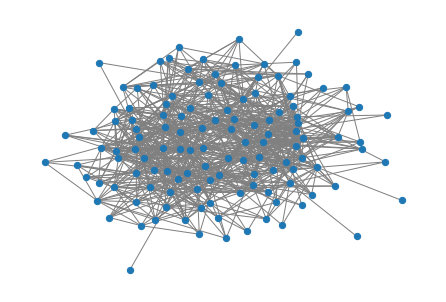

In [ ]:
nx.draw(G, pos = nx.kamada_kawai_layout(G), node_size = 40, edge_color = 'grey')

##Testing Strategy _0

In [ ]:
pop=125
steps=100
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = G)
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


0.8890256881713867
      Susceptible  Exposed  Infected  Removed
Step                                         
0             120        0         5        0
1             106       14         5        0
2             100       20         5        0
3              96       24         3        2
4              92       28         3        2
5              90       30         3        2
6              90       30         2        3
7              89       31         2        3
8              68       38        15        4
9              46       54        20        5
10             32       64        21        8
11             27       65        23       10
12             22       68        23       12
13             17       73        21       14
14             16       73        19       17
15             13       55        38       19
16              9       37        54       25
17              7       25        65       28
18              5       22        66       32
19             

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  66
number_of_uninfected: 4


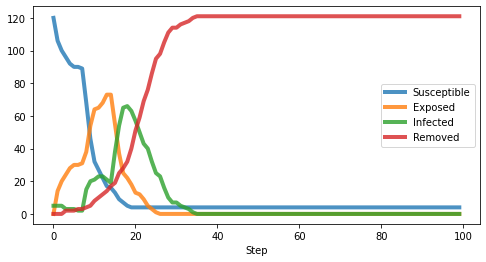

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
31                           14           16  0.433739
97                           10           22  0.515760
14                           10           48  0.184776
65                            9           28  0.399381
42                            8           25  0.316422
3                             7           24  0.389744
109                           6            7  0.346608
32                            6           20  0.079764
44                            5           12  0.532196
79                            4           19  0.497168
16                            4           10  0.432386
17                            4           31  0.068404
21                            3           18  0.260386
87                            3           11  0.306349
88                            3           25  0.379102
18                            2           10  0.085921
61                            2           24  0.097195
47                            2           18  0.086656
15                            1           32  0.025083
108                           1            7  0.127823

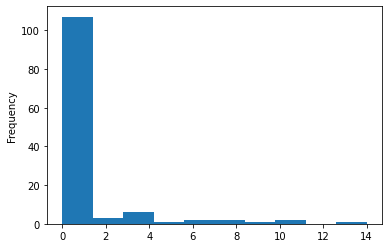

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

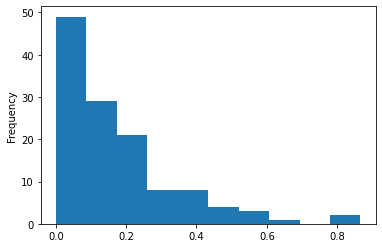

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=125
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
capacity = 37
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       2.191344               25         2098                  5   
1       2.076107               78         2098                  6   
2       2.176010               69         2098                  8   
3       2.118157               67         2098                  7   
4       2.138299               76         2098                  5   
..           ...              ...          ...                ...   
95      2.215278               60         2098                  7   
96      2.063601               59         2098                  8   
97      2.036127               67         2098                  8   
98      1.947042               68         2098                  6   
99      2.054023               35         2098                  5   

    max_2_trans  num_of_S  
0            13        89  
1            24        25  
2            16        33  
3            18        36  
4            14        31  
..          ...       ...  
95           11        47  
96           13        51  
97           12        25  
98           16        34  
99           19        84  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  2.0793510484695434 0.008835206303558387
Average_found_positives:  63.59 1.2435770335543506
Average_total_tests:  2098.0 0.0
Average_max_outbreak_size:  8.0 0.2593698657761292
Average_max_2_trans: 16.15 0.4597704741377907
Average_number_of_uninfected: 39.18 1.8564863086329009


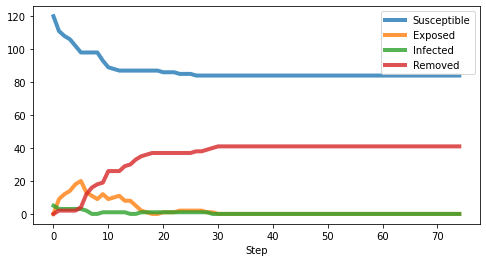

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


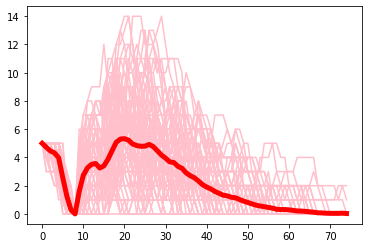

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

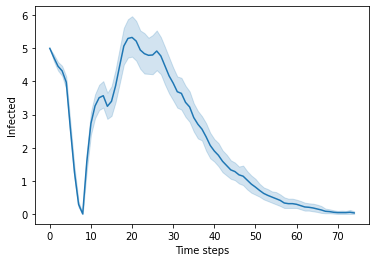

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
81                           19           21  0.294767
54                           11           19  0.334560
37                            3            6  0.109409
4                             2            4  0.098890
76                            1            5  0.032561
1                             0            9  0.341842
86                            0           11  0.027203
83                            0            7  0.236535
84                            0           16  0.032377
85                            0            7  0.000222
88                            0           25  0.030693
87                            0           11  0.142692
89                            0           14  0.459709
90                            0            7  0.003812
91                            0            7  0.078932
92                            0           11  0.089648
82                            0            9  0.301510
79                            0           19  0.087222
80                            0            5  0.155957
94                            0           11  0.434629

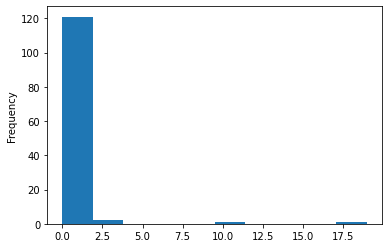

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

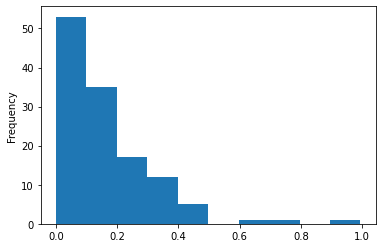

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=125
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 37
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       2.207967               44          441                  5   
1       2.168693               31          450                  5   
2       2.109377               15          440                  5   
3       2.180581               17          436                  5   
4       2.137087               47          456                  5   
..           ...              ...          ...                ...   
95      2.184064               41          446                  5   
96      2.047707               53          456                  5   
97      2.428962               26          436                  5   
98      2.138102               30          446                  5   
99      2.069118               64          459                  5   

    max_2_trans  num_of_S  
0            10        79  
1             8        92  
2             4       108  
3             5       105  
4            19        77  
..          ...       ...  
95           11        82  
96           17        72  
97            6        94  
98            8        93  
99           15        59  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  2.128970184326172 0.008140600411958639
Average_found_positives:  45.41 1.9480160848069676
Average_total_tests:  445.66 0.7622693391804143
Average_max_outbreak_size:  5.0 0.0
Average_max_2_trans: 12.1 0.5618332187193684
Average_number_of_uninfected: 77.45 1.9215616019006494


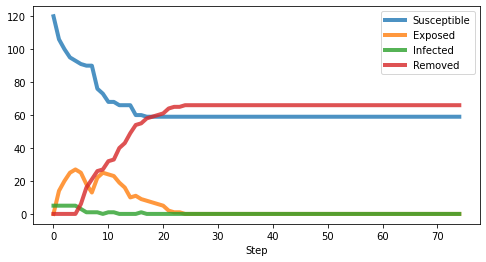

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


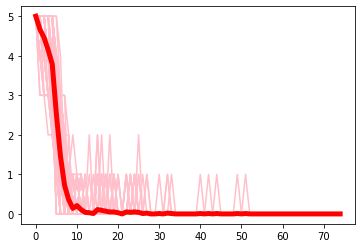

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


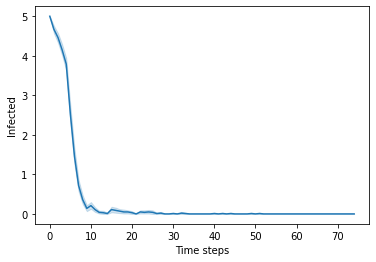

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
88                           15           25  0.139910
14                           14           48  0.276041
28                            8           17  0.139563
87                            4           11  0.443717
69                            3           17  0.033221
6                             3           16  0.546537
52                            2           12  0.016033
86                            2           11  0.372405
17                            2           31  0.063729
45                            2            3  0.376993
9                             2           18  0.255641
10                            1           12  0.155949
13                            1           11  0.149391
92                            1           11  0.041594
93                            1           15  0.098779
89                            0           14  0.049498
90                            0            7  0.025660
91                            0            7  0.030239
94                            0           11  0.017385
85                            0            7  0.100569

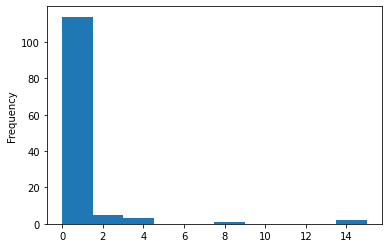

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

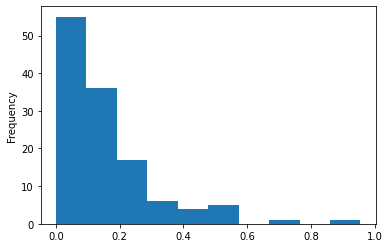

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=125
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 37
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       2.372923               71          436                  5   
1       2.619164               51          445                  5   
2       2.164175               53          445                  5   
3       2.177299               31          436                  5   
4       2.244298               16          451                  5   
..           ...              ...          ...                ...   
95      2.118070               53          448                  5   
96      2.446308               56          435                  5   
97      2.176269               31          440                  5   
98      2.212965               55          451                  5   
99      2.230043               60          444                  5   

    max_2_trans  num_of_S  
0            14        51  
1            10        72  
2            15        70  
3            15        89  
4             3       109  
..          ...       ...  
95           14        70  
96           10        65  
97           11        91  
98           15        69  
99           23        63  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  2.230301275253296 0.009758753394716848
Average_found_positives:  47.99 1.603688614325478
Average_total_tests:  446.54 0.700997845786975
Average_max_outbreak_size:  5.0 0.0
Average_max_2_trans: 13.69 0.5772969055622221
Average_number_of_uninfected: 75.09 1.5906986585215386


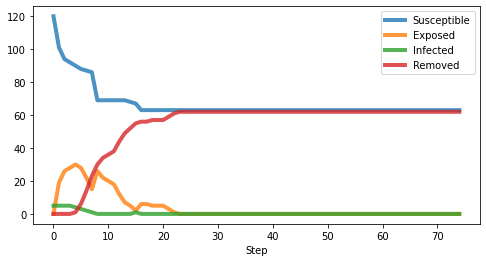

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


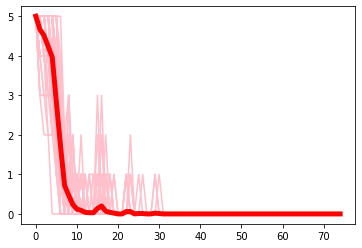

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


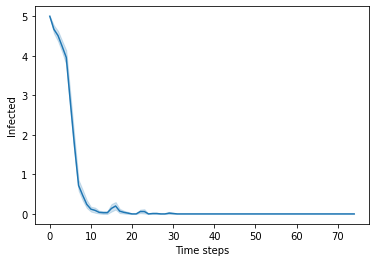

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
12                           23           25  0.482707
42                           14           25  0.598624
22                            7           10  0.276391
14                            5           48  0.119033
111                           4           11  0.132172
33                            3           24  0.102462
55                            1           14  0.037446
73                            0            8  0.040266
70                            0            4  0.103095
93                            0           15  0.139448
92                            0           11  0.060354
91                            0            7  0.262512
90                            0            7  0.016717
69                            0           17  0.353711
89                            0           14  0.047483
88                            0           25  0.176980
87                            0           11  0.465424
86                            0           11  0.093756
85                            0            7  0.497861
84                            0           16  0.005890

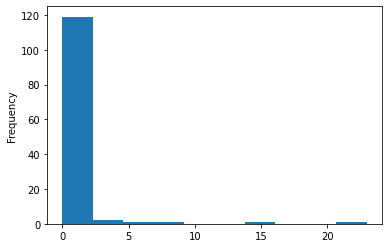

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

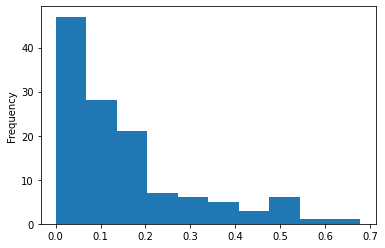

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=125
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 37
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       3.255106               61          470                  5   
1       3.280803               37          451                  5   
2       2.697712               20          436                  5   
3       3.081004               54          450                  5   
4       2.540867                7          436                  5   
..           ...              ...          ...                ...   
95      3.259751               64          461                  5   
96      2.949709               39          441                  5   
97      3.255350               55          451                  5   
98      3.326463               46          451                  5   
99      2.998216               36          441                  5   

    max_2_trans  num_of_S  
0            14        62  
1            11        85  
2             8       101  
3             9        68  
4             4       115  
..          ...       ...  
95           21        59  
96           15        83  
97           19        68  
98            9        76  
99           10        87  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  3.0819186210632323 0.024703281019324973
Average_found_positives:  43.82 1.909539052740057
Average_total_tests:  452.95 1.057954477644325
Average_max_outbreak_size:  5.0 0.0
Average_max_2_trans: 12.96 0.678816557835708
Average_number_of_uninfected: 79.22 1.90159847698634


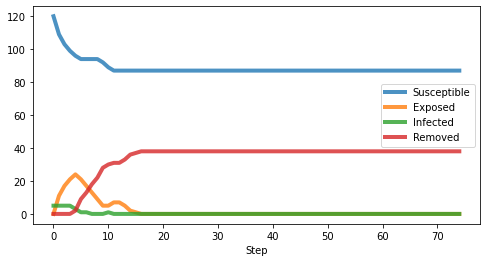

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


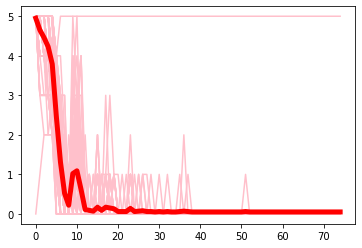

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


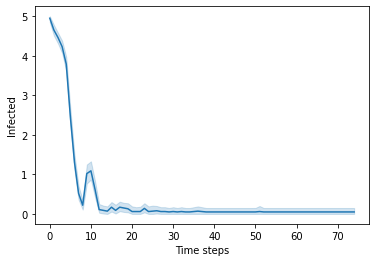

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
81                           10           21  0.147701
16                            6           10  0.250918
7                             5           23  0.105920
105                           5           15  0.104301
57                            5           23  0.257678
51                            2           21  0.182524
89                            0           14  0.018063
90                            0            7  0.185765
88                            0           25  0.120494
87                            0           11  0.112249
80                            0            5  0.082261
86                            0           11  0.069570
85                            0            7  0.032125
91                            0            7  0.513850
84                            0           16  0.055261
83                            0            7  0.167441
92                            0           11  0.185885
82                            0            9  0.063155
1                             0            9  0.101994
79                            0           19  0.072816

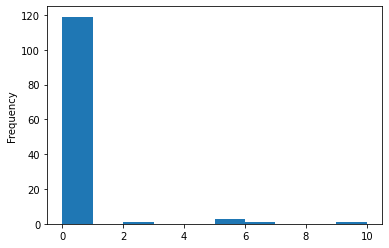

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

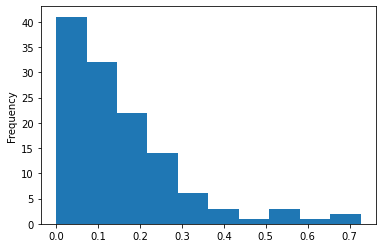

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(35, 13), (33, 13), (12, 13), (106, 14), (27, 15)]

In [ ]:
group_df

Group  Degree  Intra_C     order  record  flag
15    [107, 78, 65, 70, 120]      52        5  0.000041      17     1
8        [0, 1, 112, 68, 71]      48        5  0.000023      17     1
23    [18, 113, 84, 98, 121]      40        2  0.000020      17     1
7      [122, 99, 46, 43, 44]      35        5  0.000018      17     1
19  [117, 108, 86, 101, 119]      28        3  0.000006      17     1
20     [80, 52, 54, 61, 104]      81        6  0.024566      18     1
2       [50, 21, 22, 59, 60]      98        6  0.021347      17     0
11      [75, 14, 10, 13, 76]     102        4  0.013121      17     0
18     [116, 69, 49, 47, 48]      66        4  0.001662      17     0
16     [87, 35, 42, 124, 64]      88        5  0.001628      17     0
4       [38, 30, 37, 63, 95]      81        9  0.001294      17     0
14      [27, 89, 34, 32, 33]      97        4  0.000991      17     0
13      [15, 16, 81, 62, 23]      74        4  0.000851      17     0
12        [11, 2, 3, 79, 17]      68        4  0.000565      17     0
17      [9, 25, 56, 83, 102]      78        4  0.000422      17     0
10    [105, 57, 73, 85, 115]      57        5  0.000378      17     0
6          [67, 29, 6, 4, 5]      56        5  0.000376      17     0
9      [28, 58, 118, 51, 55]      60        5  0.000321      17     0
22    [106, 41, 45, 110, 12]      62        4  0.000181      17     0
1     [88, 19, 20, 109, 114]      65        6  0.000111      17     0
3       [96, 24, 31, 72, 97]      71        7  0.000110      17     0
0         [82, 7, 8, 40, 94]      76        6  0.000081      17     0
21     [77, 111, 90, 36, 53]      45        3  0.000077      17     0
24   [100, 103, 123, 26, 39]      52        4  0.000067      17     0
5       [92, 66, 74, 91, 93]      64        7  0.000062      17     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
81                           10           21  0.147701
16                            6           10  0.250918
7                             5           23  0.105920
105                           5           15  0.104301
57                            5           23  0.257678
51                            2           21  0.182524
89                            0           14  0.018063
90                            0            7  0.185765
88                            0           25  0.120494
87                            0           11  0.112249
80                            0            5  0.082261
86                            0           11  0.069570
85                            0            7  0.032125
91                            0            7  0.513850
84                            0           16  0.055261
83                            0            7  0.167441
92                            0           11  0.185885
82                            0            9  0.063155
1                             0            9  0.101994
79                            0           19  0.072816

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=125
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 37
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       3.469213               79          519                  9   
1       3.269966               76          494                  8   
2       3.455368               68          491                  5   
3       2.882174               27          446                  5   
4       3.496542               86          481                  9   
..           ...              ...          ...                ...   
95      2.865664               24          441                  5   
96      3.315170               61          467                  6   
97      2.909123                1          431                  5   
98      3.258155               70          485                  8   
99      2.885476               11          436                  5   

    max_2_trans  num_of_S  
0            23        35  
1            15        32  
2            14        46  
3            11        94  
4            19        20  
..          ...       ...  
95            8        97  
96           15        54  
97            0       120  
98           12        41  
99            4       109  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  3.363281559944153 0.03460992593683552
Average_found_positives:  61.61 2.2933322322055143
Average_total_tests:  479.07 2.3254522748979998
Average_max_outbreak_size:  7.1 0.2879744657591935
Average_max_2_trans: 13.74 0.6748916860347205
Average_number_of_uninfected: 52.87 2.8007810959578308


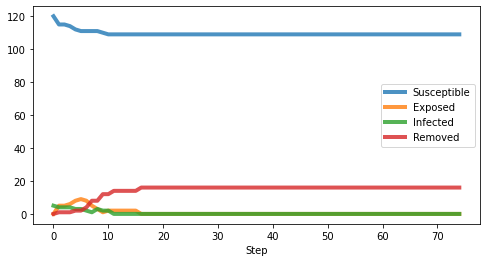

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


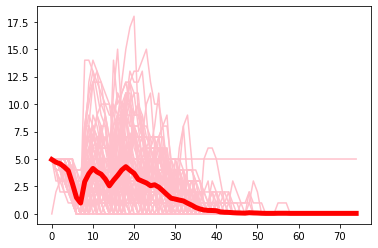

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


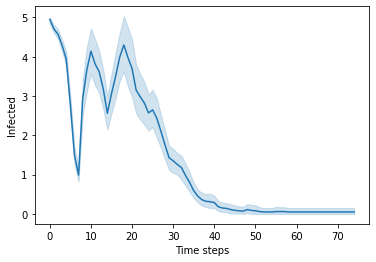

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
109                           4            7  0.062936
115                           3            6  0.152723
114                           2            5  0.168341
117                           2           12  0.055518
89                            0           14  0.007061
88                            0           25  0.504393
87                            0           11  0.109016
86                            0           11  0.159202
85                            0            7  0.092145
79                            0           19  0.369606
84                            0           16  0.121711
90                            0            7  0.203936
91                            0            7  0.030373
83                            0            7  0.022313
82                            0            9  0.501844
81                            0           21  0.242693
80                            0            5  0.129906
1                             0            9  0.131239
77                            0            9  0.136008
78                            0            6  0.036039

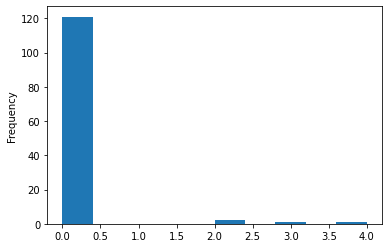

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

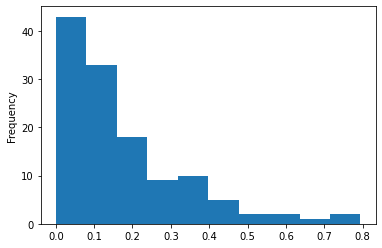

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(23, 8), (65, 8), (117, 10), (97, 15), (98, 15)]

In [ ]:
group_df

Group  Degree  Intra_C     order  record  flag
15    [107, 78, 65, 70, 120]      52        5  0.000011      16     1
0         [82, 7, 8, 40, 94]      76        6  0.000011      17     1
7      [122, 99, 46, 43, 44]      35        5  0.000011      18     1
5       [92, 66, 74, 91, 93]      64        7  0.000010      17     1
6          [67, 29, 6, 4, 5]      56        5  0.000010      17     1
4       [38, 30, 37, 63, 95]      81        9  0.000010      18     1
14      [27, 89, 34, 32, 33]      97        4  0.000019      18     0
12        [11, 2, 3, 79, 17]      68        4  0.000018      17     0
9      [28, 58, 118, 51, 55]      60        5  0.000017      17     0
10    [105, 57, 73, 85, 115]      57        5  0.000017      17     0
22    [106, 41, 45, 110, 12]      62        4  0.000017      17     0
8        [0, 1, 112, 68, 71]      48        5  0.000016      17     0
1     [88, 19, 20, 109, 114]      65        6  0.000016      19     0
11      [75, 14, 10, 13, 76]     102        4  0.000016      18     0
24   [100, 103, 123, 26, 39]      52        4  0.000016      17     0
23    [18, 113, 84, 98, 121]      40        2  0.000015      14     0
2       [50, 21, 22, 59, 60]      98        6  0.000015      17     0
18     [116, 69, 49, 47, 48]      66        4  0.000014      16     0
21     [77, 111, 90, 36, 53]      45        3  0.000014      15     0
17      [9, 25, 56, 83, 102]      78        4  0.000014      18     0
20     [80, 52, 54, 61, 104]      81        6  0.000013      17     0
19  [117, 108, 86, 101, 119]      28        3  0.000013      15     0
13      [15, 16, 81, 62, 23]      74        4  0.000013      17     0
16     [87, 35, 42, 124, 64]      88        5  0.000012      18     0
3       [96, 24, 31, 72, 97]      71        7  0.000011      19     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
109                           4            7  0.062936
115                           3            6  0.152723
114                           2            5  0.168341
117                           2           12  0.055518
89                            0           14  0.007061
88                            0           25  0.504393
87                            0           11  0.109016
86                            0           11  0.159202
85                            0            7  0.092145
79                            0           19  0.369606
84                            0           16  0.121711
90                            0            7  0.203936
91                            0            7  0.030373
83                            0            7  0.022313
82                            0            9  0.501844
81                            0           21  0.242693
80                            0            5  0.129906
1                             0            9  0.131239
77                            0            9  0.136008
78                            0            6  0.036039

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_4['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_4])
temp = temp.reset_index()

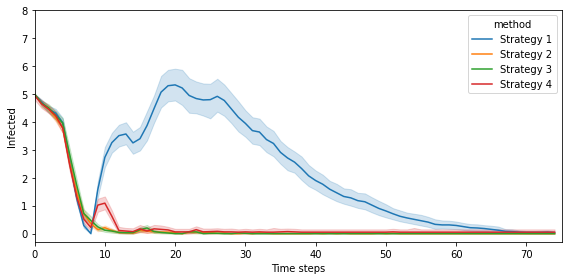

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
plt.ylim(top = 8)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/InVS13_infect_result_500.csv')

# InVS15

In [ ]:
#load data
file = '/content/drive/MyDrive/Colab Notebooks/Real_data/tij_InVS15.dat'
from io import StringIO

edge_list = pd.read_fwf(file, names = ['time', 'edge'])#.iloc[: , 1:]
edge_list['id1'] = [i.split('\t',1)[0] for i in edge_list['edge']]
edge_list['id2'] = [i.split('\t',1)[1] for i in edge_list['edge']]
edge_list = edge_list.drop_duplicates(subset=['id1', 'id2'], keep='last')
G_temp = nx.from_pandas_edgelist(edge_list, "id1", "id2")
G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
lar_cc = max(nx.connected_components(G), key=len)
print("Diameter: ", nx.diameter(G.subgraph(lar_cc)))
print("Average shortest path length: ", nx.average_shortest_path_length(G.subgraph(lar_cc)))
#edge_list
list(nx.isolates(G))
len(lar_cc)

# of nodes:  223
Average degree:  38.37668161434978
Diameter:  5
Average shortest path length:  1.9269583484830122


223

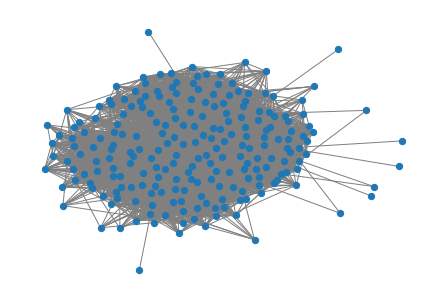

In [ ]:
nx.draw(G, pos = nx.kamada_kawai_layout(G), node_size = 40, edge_color = 'grey')

##Testing Strategy _0

In [ ]:
pop=223
steps=100
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = G)
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


7.959733247756958
      Susceptible  Exposed  Infected  Removed
Step                                         
0             218        0         5        0
1             206       12         5        0
2             201       17         5        0
3             195       23         5        0
4             189       29         4        1
5             185       33         2        3
6             184       34         2        3
7             179       39         2        3
8             135       71        14        3
9              98      103        17        5
10             75      120        22        6
11             55      134        28        6
12             31      154        28       10
13             24      160        27       12
14             20      159        27       17
15             12      123        68       20
16              5       93       101       24
17              5       70       112       36
18              3       52       120       48
19              

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  129
number_of_uninfected: 2


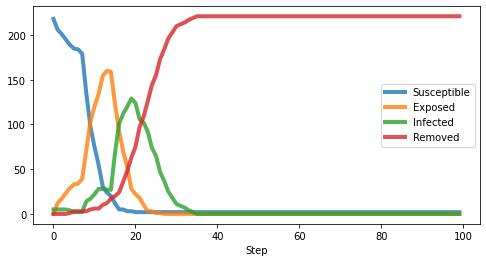

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
36                           23           61  0.186122
188                          20           43  0.063293
25                           15           46  0.209154
150                          14           32  0.170635
15                           14           54  0.084609
58                           13           38  0.098411
196                          10           33  0.203485
1                            10           73  0.182140
85                            8           66  0.378184
74                            7           58  0.053118
156                           6           33  0.146604
24                            6           51  0.023792
33                            6           50  0.096488
96                            5           54  0.091284
144                           5           49  0.203427
39                            4           28  0.141423
123                           4           35  0.085872
28                            4           67  0.017914
171                           3           55  0.019765
148                           3           27  0.263899

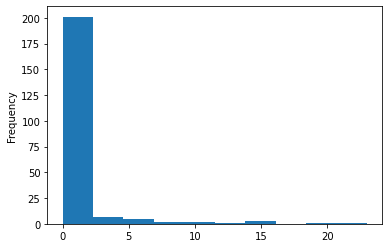

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

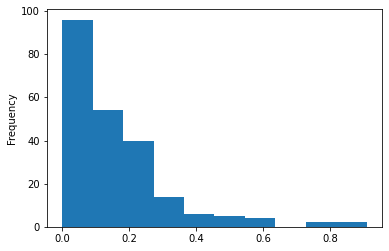

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=223
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
capacity = 67
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       7.754126              159         3722                 29   
1       7.641830              151         3722                 27   
2       7.451311              165         3722                 17   
3       9.170116              151         3722                 24   
4       7.620023              153         3722                 30   
..           ...              ...          ...                ...   
95      4.040683              171         3722                 12   
96      4.063825              153         3722                 26   
97      4.173834              152         3722                 16   
98      4.076088              154         3722                 19   
99      4.039101              161         3722                 22   

    max_2_trans  num_of_S  
0            25         7  
1            40        13  
2            48        11  
3            34         9  
4            26        13  
..          ...       ...  
95           51        13  
96           31        11  
97           36        20  
98           31        14  
99           45        10  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  5.4867303895950315 0.18327137452799244
Average_found_positives:  156.63 0.4879673362143426
Average_total_tests:  3722.0 0.0
Average_max_outbreak_size:  23.75 0.55
Average_max_2_trans: 35.53 0.949370338911028
Average_number_of_uninfected: 11.69 0.304410342409151


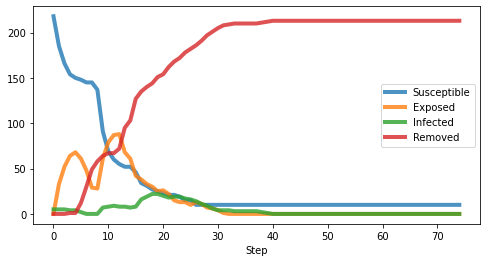

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


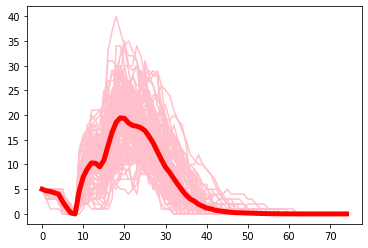

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

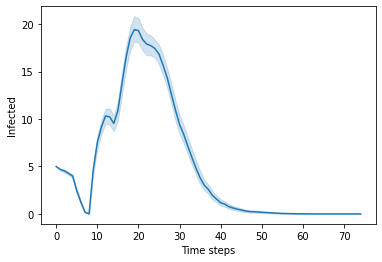

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
137                          45           51  0.485259
132                          24           58  0.740159
11                           22           51  0.087528
19                           18           67  0.357890
76                           16           84  0.266865
17                            9           37  0.520261
2                             7           57  0.932873
22                            7           46  0.444619
184                           6           23  0.041753
141                           5           40  0.744159
140                           4           77  0.163896
205                           4           49  0.152422
188                           3           43  0.104228
96                            3           54  0.035560
60                            3           65  0.505191
208                           3           30  0.562108
12                            3           21  0.213424
67                            3           43  0.124240
115                           2           50  0.213028
66                            2           48  0.034742

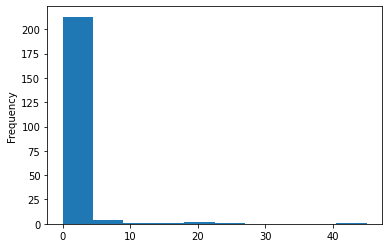

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

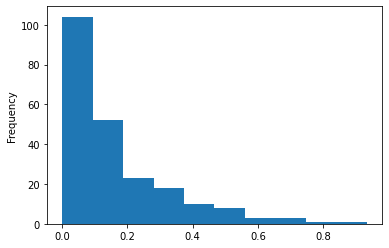

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=223
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 67
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       4.279070              153          466                  5   
1       4.151016              152          456                  5   
2       4.140936              139          456                  5   
3       4.238300               22          466                  5   
4       4.115359              156          466                  5   
..           ...              ...          ...                ...   
95      4.255405              146          456                  5   
96      6.046906              164          446                  5   
97      4.163686              105          445                  5   
98      4.130316              159          466                  5   
99      4.262018               18          456                  5   

    max_2_trans  num_of_S  
0            25        69  
1            41        69  
2            33        82  
3            12       200  
4            29        66  
..          ...       ...  
95           36        76  
96           27        56  
97           23       115  
98           40        63  
99            7       203  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  4.440374433994293 0.05976129856805682
Average_found_positives:  143.46 3.3577716275873057
Average_total_tests:  455.94 1.1068948286156917
Average_max_outbreak_size:  5.0 0.0
Average_max_2_trans: 31.92 1.117056015343072
Average_number_of_uninfected: 77.7 3.325035125507486


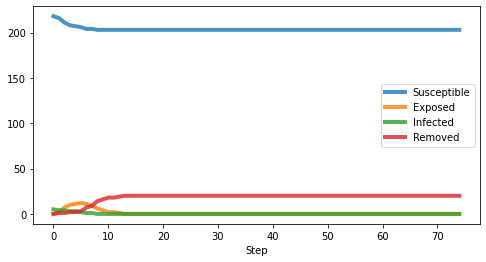

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


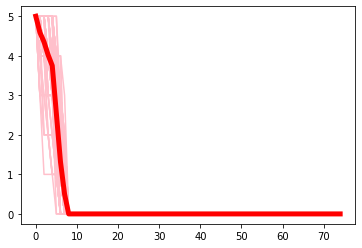

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


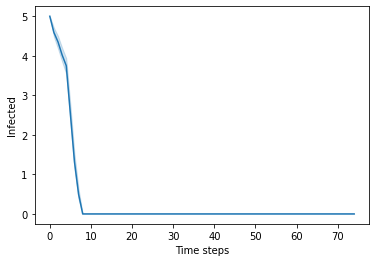

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
79                            7           40  0.023559
164                           6           19  0.060177
223                           1            7  0.034339
63                            1           56  0.042811
154                           0           40  0.177625
144                           0           49  0.046081
145                           0           58  0.088161
146                           0           54  0.022926
147                           0           61  0.061996
148                           0           27  0.108114
149                           0           49  0.253613
150                           0           32  0.091887
151                           0           13  0.282713
152                           0           34  0.055308
153                           0           53  0.319719
155                           0           61  0.032971
114                           0           10  0.185167
156                           0           33  0.094975
157                           0           23  0.316475
158                           0           54  0.046315

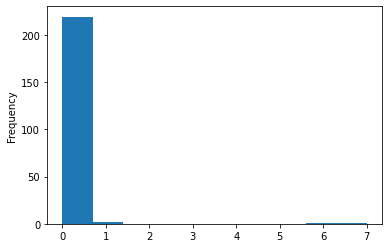

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

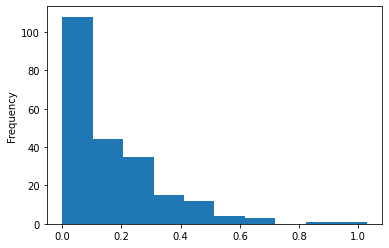

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=223
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 67
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       4.906777              160          456                  5   
1       4.811724               79          456                  5   
2       5.019853              168          456                  5   
3       4.834637               91          466                  5   
4       6.873379              146          456                  5   
..           ...              ...          ...                ...   
95      4.868318              141          466                  5   
96      6.873720              129          456                  5   
97      4.773924              137          466                  5   
98      4.969051              113          456                  5   
99      4.781412              146          435                  5   

    max_2_trans  num_of_S  
0            41        62  
1            21       142  
2            29        53  
3            17       131  
4            28        75  
..          ...       ...  
95           59        81  
96           28        93  
97           17        85  
98           20       108  
99           22        73  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  5.14943187713623 0.0675023909806751
Average_found_positives:  146.34 3.077589900548739
Average_total_tests:  456.75 0.96036346234016
Average_max_outbreak_size:  5.0 0.0
Average_max_2_trans: 31.75 1.0452755665856779
Average_number_of_uninfected: 74.9 3.068592939160003


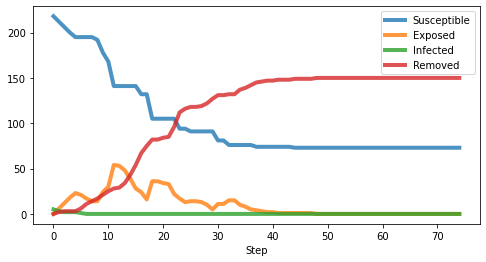

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


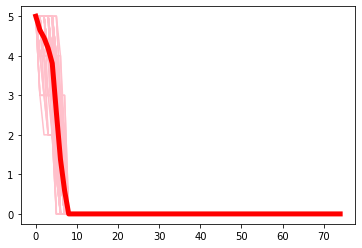

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


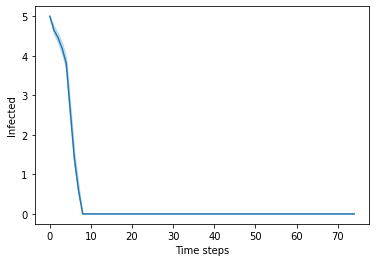

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
55                           22           52  0.150647
30                           20           62  0.452783
131                          13           51  0.405060
6                            10           34  0.626521
85                            8           66  0.191763
158                           8           54  0.289931
75                            8           49  0.435844
177                           7           47  0.523896
5                             6           62  0.136767
34                            5           73  0.390773
196                           5           33  0.241396
74                            5           58  0.259226
48                            4           52  0.294035
192                           4           38  0.087011
76                            4           84  0.046922
99                            3           43  0.077004
46                            3           31  0.119439
79                            2           40  0.072735
21                            2           52  0.127805
20                            2           53  0.075425

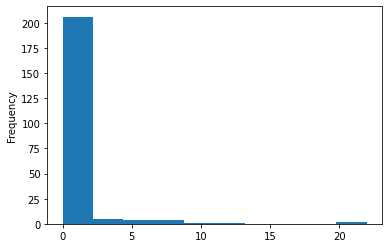

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

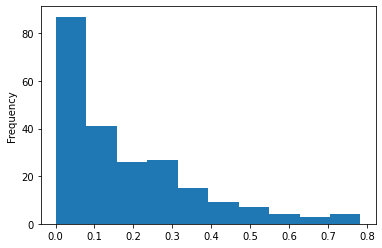

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=223
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 67
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       9.105058              143          469                  5   
1       9.820638              171          476                  5   
2      10.688283              149          466                  5   
3       8.773983              144          476                  5   
4       8.620763              139          448                  5   
..           ...              ...          ...                ...   
95      9.116877              157          506                  5   
96      6.099946               39          466                  5   
97      8.945553              145          476                  5   
98      9.098716              156          466                  5   
99     10.364118              136          456                  5   

    max_2_trans  num_of_S  
0            29        77  
1            39        50  
2            39        73  
3            30        76  
4            22        80  
..          ...       ...  
95           55        65  
96           18       182  
97           25        77  
98           50        65  
99           45        84  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  9.240035388469696 0.1450947281480141
Average_found_positives:  140.87 3.8344703188657787
Average_total_tests:  481.57 2.067607557081616
Average_max_outbreak_size:  5.06 0.034289321599553065
Average_max_2_trans: 32.17 1.2205359809559408
Average_number_of_uninfected: 79.98 3.8218928093896936


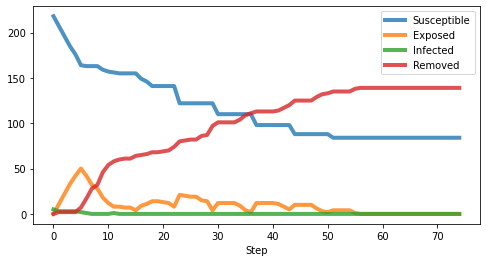

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


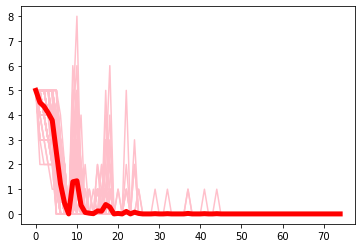

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


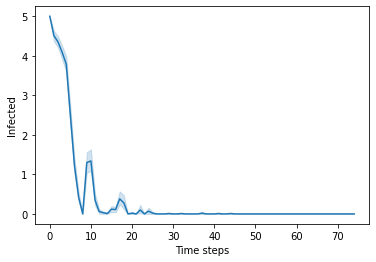

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
36                           45           61  0.199969
210                          14           34  0.534724
135                          12           26  1.177722
111                           9           36  0.338314
200                           9           39  0.048400
124                           6           35  0.096670
91                            5           41  0.274823
154                           5           40  0.117497
148                           5           27  0.212280
153                           4           53  0.169581
66                            3           48  0.104691
57                            3           39  0.323457
2                             3           57  0.185493
122                           2           45  0.056499
83                            2           57  0.059512
134                           2           41  0.052869
101                           1           23  0.075989
174                           1           25  0.147060
116                           1           30  0.110199
220                           1            1  0.080834

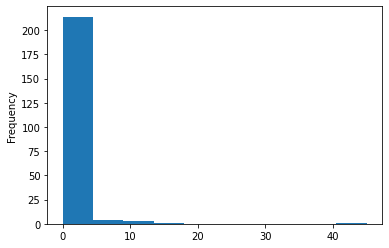

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

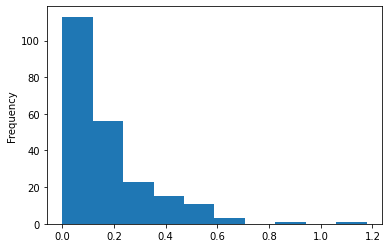

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(153, 50), (165, 54), (141, 54), (180, 54), (211, 55)]

In [ ]:
group_df

Group  Degree  Intra_C  \
21  [185, 170, 157, 169, 211, 176, 182, 214, 177, ...     388       16   
17  [119, 128, 131, 125, 127, 161, 129, 135, 158, ...     395       15   
6        [15, 11, 14, 221, 215, 74, 66, 68, 186, 117]     335       15   
13          [73, 61, 65, 64, 55, 58, 76, 67, 69, 121]     398       30   
12           [35, 44, 40, 41, 71, 45, 46, 56, 48, 51]     359       14   
0           [6, 2, 3, 150, 167, 18, 12, 17, 204, 206]     406       19   
8       [200, 50, 36, 37, 210, 107, 95, 99, 218, 104]     334       12   
2        [62, 52, 59, 196, 197, 82, 80, 81, 165, 178]     411       18   
15   [90, 160, 92, 118, 120, 102, 108, 149, 100, 109]     359       16   
4             [72, 60, 38, 39, 13, 9, 10, 20, 16, 19]     386       19   
20  [155, 162, 195, 168, 191, 190, 156, 163, 188, ...     335       13   
3    [145, 96, 139, 207, 209, 111, 98, 103, 171, 173]     370       17   
1        [30, 23, 24, 189, 194, 42, 31, 33, 126, 132]     421       18   
14           [70, 77, 86, 78, 79, 87, 84, 85, 91, 89]     342       12   
5     [174, 26, 22, 25, 216, 201, 198, 110, 112, 220]     311       10   
10   [217, 123, 93, 97, 219, 187, 172, 175, 213, 203]     269       14   
22                                    [202, 180, 183]     114        3   
11         [205, 208, 53, 28, 34, 29, 21, 27, 49, 32]     462       24   
7             [83, 88, 192, 4, 0, 1, 193, 75, 57, 63]     488       21   
19  [148, 143, 144, 159, 146, 154, 166, 147, 164, ...     473       19   
18  [136, 141, 133, 134, 142, 137, 138, 153, 140, ...     398       15   
9            [94, 101, 212, 8, 5, 7, 222, 54, 43, 47]     406       16   
16  [179, 113, 114, 115, 105, 106, 124, 116, 122, ...     398       21   

           order  record  flag  
21  1.418100e+15      19     1  
17  6.593641e+14      19     1  
6   2.478744e+14      19     1  
13  1.782668e+14      19     1  
12  9.760337e+13      19     1  
0   8.805562e+13      19     1  
8   5.707611e+13      18     0  
2   3.960470e+13      18     0  
15  2.883619e+13      18     0  
4   1.616252e+13      18     0  
20  1.573978e+12      18     0  
3   1.372812e+12      18     0  
1   2.020835e+11      18     0  
14  1.687726e+11      18     0  
5   2.774320e+10      18     0  
10  9.697825e+07      18     0  
22  4.768876e-01      18     0  
11  6.271583e+21      19     0  
7   1.353545e+21      19     0  
19  9.728899e+19      19     0  
18  1.884273e+17      19     0  
9   3.845964e+16      19     0  
16  1.738523e+15      19     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
36                           45           61  0.199969
210                          14           34  0.534724
135                          12           26  1.177722
111                           9           36  0.338314
200                           9           39  0.048400
124                           6           35  0.096670
91                            5           41  0.274823
154                           5           40  0.117497
148                           5           27  0.212280
153                           4           53  0.169581
66                            3           48  0.104691
57                            3           39  0.323457
2                             3           57  0.185493
122                           2           45  0.056499
83                            2           57  0.059512
134                           2           41  0.052869
101                           1           23  0.075989
174                           1           25  0.147060
116                           1           30  0.110199
220                           1            1  0.080834

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=223
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 67
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       8.810787              147          540                 32   
1       8.717208              151          551                 31   
2       8.827478              152          565                 33   
3      12.050874              147          505                 41   
4       8.693999              145          560                 38   
..           ...              ...          ...                ...   
95      8.840191              148          502                 31   
96      8.883651              144          523                 37   
97      9.099198              154          520                 30   
98     10.631229              141          494                 42   
99      8.670679              139          484                 47   

    max_2_trans  num_of_S  
0            28         8  
1            32         8  
2            34        12  
3            30         8  
4            23        11  
..          ...       ...  
95           25         9  
96           31         7  
97           44         6  
98           32         7  
99           33         7  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  9.285606381893158 0.09291840427153693
Average_found_positives:  145.03 0.9691665689569767
Average_total_tests:  515.19 3.1251244823691473
Average_max_outbreak_size:  37.02 0.7431818027368485
Average_max_2_trans: 33.46 0.839242082314318
Average_number_of_uninfected: 8.52 0.26722668468942434


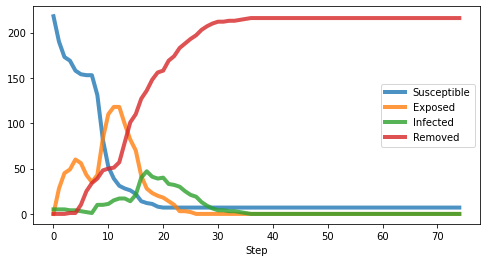

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


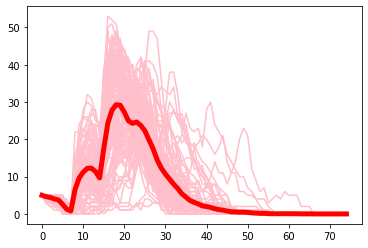

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


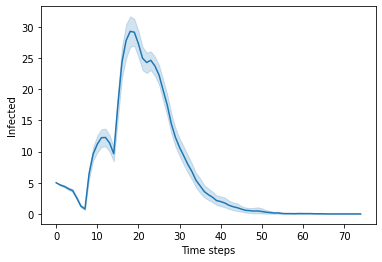

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
8                            33           54  0.446097
121                          19           57  1.074847
183                          14           43  0.228802
150                          13           32  0.470646
94                           11           40  0.051388
199                          10           48  0.604236
136                          10           35  0.285032
145                          10           58  0.199932
200                           9           39  0.066184
53                            9           62  0.194174
146                           9           54  0.032934
188                           7           43  0.153997
149                           6           49  0.201263
81                            5           45  0.146965
208                           5           30  0.211226
96                            5           54  0.155413
128                           4           40  0.095525
27                            4           68  0.098913
180                           3           57  0.103473
78                            3           33  0.455166

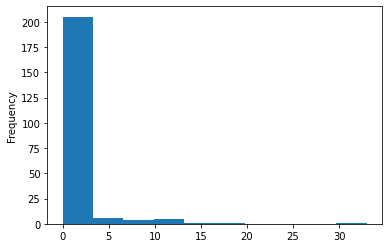

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

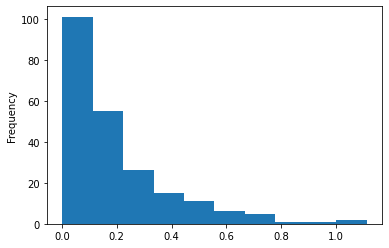

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(45, 22), (72, 22), (47, 22), (209, 24), (92, 28)]

In [ ]:
group_df

Group  Degree  Intra_C  \
7             [83, 88, 192, 4, 0, 1, 193, 75, 57, 63]     488       21   
11         [205, 208, 53, 28, 34, 29, 21, 27, 49, 32]     462       24   
13          [73, 61, 65, 64, 55, 58, 76, 67, 69, 121]     398       30   
18  [136, 141, 133, 134, 142, 137, 138, 153, 140, ...     398       15   
19  [148, 143, 144, 159, 146, 154, 166, 147, 164, ...     473       19   
15   [90, 160, 92, 118, 120, 102, 108, 149, 100, 109]     359       16   
0           [6, 2, 3, 150, 167, 18, 12, 17, 204, 206]     406       19   
8       [200, 50, 36, 37, 210, 107, 95, 99, 218, 104]     334       12   
1        [30, 23, 24, 189, 194, 42, 31, 33, 126, 132]     421       18   
16  [179, 113, 114, 115, 105, 106, 124, 116, 122, ...     398       21   
4             [72, 60, 38, 39, 13, 9, 10, 20, 16, 19]     386       19   
17  [119, 128, 131, 125, 127, 161, 129, 135, 158, ...     395       15   
6        [15, 11, 14, 221, 215, 74, 66, 68, 186, 117]     335       15   
3    [145, 96, 139, 207, 209, 111, 98, 103, 171, 173]     370       17   
5     [174, 26, 22, 25, 216, 201, 198, 110, 112, 220]     311       10   
10   [217, 123, 93, 97, 219, 187, 172, 175, 213, 203]     269       14   
22                                    [202, 180, 183]     114        3   
9            [94, 101, 212, 8, 5, 7, 222, 54, 43, 47]     406       16   
2        [62, 52, 59, 196, 197, 82, 80, 81, 165, 178]     411       18   
12           [35, 44, 40, 41, 71, 45, 46, 56, 48, 51]     359       14   
21  [185, 170, 157, 169, 211, 176, 182, 214, 177, ...     388       16   
20  [155, 162, 195, 168, 191, 190, 156, 163, 188, ...     335       13   
14           [70, 77, 86, 78, 79, 87, 84, 85, 91, 89]     342       12   

           order  record  flag  
7   3.529902e+18      36     1  
11  6.890167e+16      36     1  
13  3.295226e+14      36     1  
18  2.225725e+13      21     1  
19  2.161325e+13      34     1  
15  2.009037e+13       8     1  
0   3.943990e+13      22     0  
8   3.699257e+13       6     0  
1   3.575110e+13      25     0  
16  3.521199e+13      12     0  
4   3.469147e+13      24     0  
17  3.439778e+13      18     0  
6   3.341522e+13      14     0  
3   1.031487e+12       0     0  
5   5.753958e+11       1     0  
10  2.220761e+11       0     0  
22  6.761702e+03       0     0  
9   6.717964e+13      35     0  
2   2.851539e+13      19     0  
12  2.719504e+13      24     0  
21  2.663265e+13      20     0  
20  2.335156e+13      22     0  
14  2.322212e+13      13     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
8                            33           54  0.446097
121                          19           57  1.074847
183                          14           43  0.228802
150                          13           32  0.470646
94                           11           40  0.051388
199                          10           48  0.604236
136                          10           35  0.285032
145                          10           58  0.199932
200                           9           39  0.066184
53                            9           62  0.194174
146                           9           54  0.032934
188                           7           43  0.153997
149                           6           49  0.201263
81                            5           45  0.146965
208                           5           30  0.211226
96                            5           54  0.155413
128                           4           40  0.095525
27                            4           68  0.098913
180                           3           57  0.103473
78                            3           33  0.455166

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

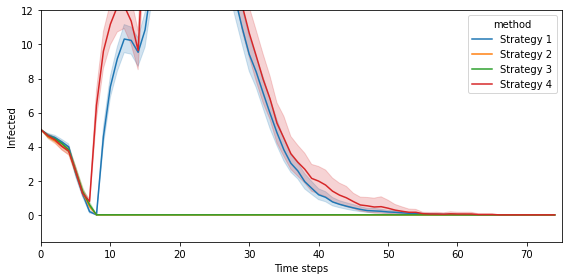

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
##plt.ylim(top = 12)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/InVS15_infect_result_500.csv')

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_4['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_4])
temp = temp.reset_index()

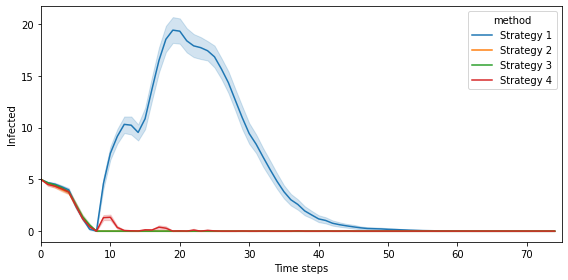

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
##plt.ylim(top = 12)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/InVS15_infect_result_2.csv')

# LH10

In [ ]:
#load data
file = '/content/drive/MyDrive/Colab Notebooks/Real_data/tij_LH10.dat'
from io import StringIO

edge_list = pd.read_fwf(file, names = ['time', 'id1', 'id2'])#.iloc[: , 1:]
#edge_list['id1'] = [i.split('\t',1)[0] for i in edge_list['edge']]
#edge_list['id2'] = [i.split('\t',1)[1] for i in edge_list['edge']]
edge_list = edge_list.drop_duplicates(subset=['id1', 'id2'], keep='last')
G_temp = nx.from_pandas_edgelist(edge_list, "id1", "id2")
G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
lar_cc = max(nx.connected_components(G), key=len)
print("Diameter: ", nx.diameter(G.subgraph(lar_cc)))
print("Average shortest path length: ", nx.average_shortest_path_length(G.subgraph(lar_cc)))
#edge_list
list(nx.isolates(G))
len(lar_cc)

# of nodes:  94
Average degree:  22.02127659574468
Diameter:  3
Average shortest path length:  1.6110304789550072


53

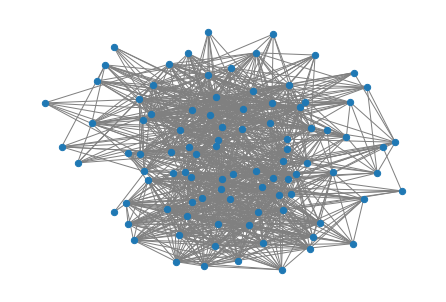

In [ ]:
nx.draw(G, pos = nx.kamada_kawai_layout(G), node_size = 40, edge_color = 'grey')

##Testing Strategy _0

In [ ]:
pop=94
steps=100
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = G)
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


0.8747725486755371
      Susceptible  Exposed  Infected  Removed
Step                                         
0              89        0         5        0
1              82        7         4        1
2              75       14         4        1
3              72       17         4        1
4              72       17         3        2
5              71       18         2        3
6              71       18         1        4
7              71       18         1        4
8              33       49         7        5
9              12       63        13        6
10              9       63        15        7
11              4       68        15        7
12              2       69        11       12
13              1       70        10       13
14              1       70         8       15
15              1       32        42       19
16              0       12        61       21
17              0        9        60       25
18              0        4        57       33
19             

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  61
number_of_uninfected: 0


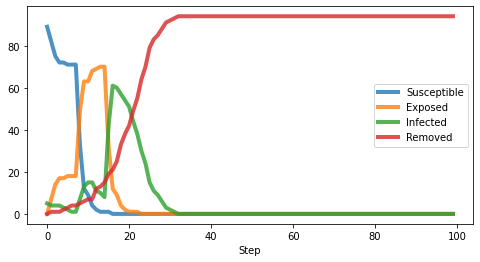

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
81                           15           28  0.614969
31                           15           39  0.395379
21                           13           38  0.258620
5                            10           16  0.217005
58                            7           38  0.230204
54                            6           23  0.036918
41                            5           36  0.454932
77                            3           36  0.217171
23                            3           43  0.037955
46                            3           34  0.239130
68                            2           36  0.034566
65                            2           30  0.091492
84                            1           40  0.139467
27                            1           38  0.184461
56                            1           20  0.325252
63                            1           22  1.055220
4                             1           12  0.174003
67                            0           18  0.178825
66                            0           12  0.279040
69                            0           28  0.094565

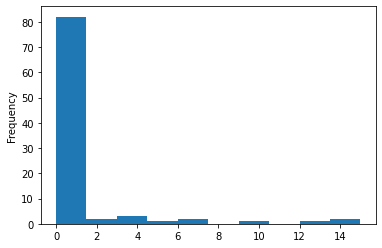

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

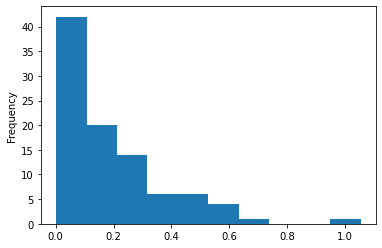

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=94
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
capacity = 28
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       2.094299               18         1574                  5   
1       2.020714               74         1574                  9   
2       1.989435               67         1574                 10   
3       2.027429               60         1574                  5   
4       2.046227               19         1574                  5   
..           ...              ...          ...                ...   
95      2.087417               35         1574                  7   
96      2.102524               33         1574                  5   
97      1.984237               35         1574                  5   
98      1.967567               34         1574                  5   
99      1.989130               49         1574                  5   

    max_2_trans  num_of_S  
0             7        75  
1            37         5  
2            28         4  
3            17        18  
4             7        72  
..          ...       ...  
95           18        46  
96           16        56  
97           22        57  
98           26        53  
99           13        32  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  2.014696674346924 0.009336413095232261
Average_found_positives:  54.39 1.5210904514906933
Average_total_tests:  1574.0 0.0
Average_max_outbreak_size:  7.46 0.23156036366399585
Average_max_2_trans: 20.18 0.715680082018481
Average_number_of_uninfected: 23.75 2.0138096466471933


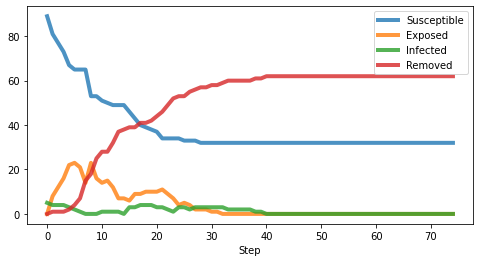

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


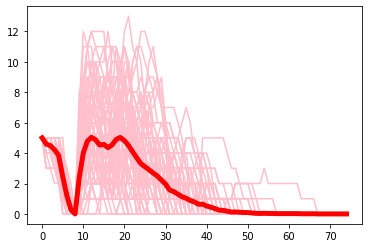

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

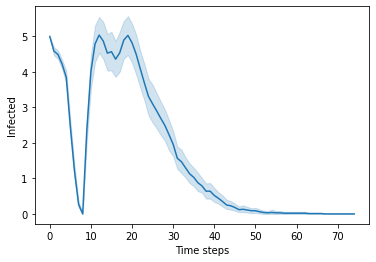

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
15                           13           32  0.135160
44                           12           29  0.484866
33                            7           27  0.403411
71                            7           16  0.178488
46                            6           34  0.075539
68                            4           36  0.043461
23                            4           43  0.121009
12                            2           18  0.091922
16                            1           18  0.272766
47                            1           23  0.966452
65                            0           30  0.030389
1                             0           11  0.007295
66                            0           12  0.064300
67                            0           18  0.442963
63                            0           22  0.018327
69                            0           28  0.118467
64                            0           32  0.024927
61                            0           22  0.704174
62                            0           23  0.062613
60                            0           28  0.172593

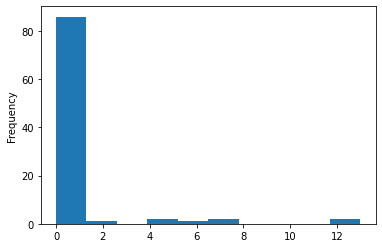

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

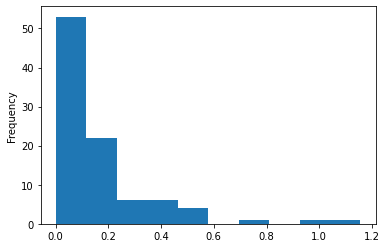

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=94
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 28
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       2.421724               75          326                  5   
1       2.017892               70          337                  5   
2       2.098892               66          325                  5   
3       2.060292               59          333                  5   
4       2.096143               81          324                  5   
..           ...              ...          ...                ...   
95      3.344402               46          321                  5   
96      3.056857               58          328                  5   
97      2.808357               53          310                  5   
98      3.615267               76          340                  5   
99      3.751124               42          307                  5   

    max_2_trans  num_of_S  
0            23        15  
1            14        23  
2            11        25  
3            17        32  
4            17        10  
..          ...       ...  
95           14        44  
96           11        35  
97           18        38  
98           19        16  
99           27        49  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  2.3856245350837706 0.05783797741724454
Average_found_positives:  65.18 1.628494998333111
Average_total_tests:  324.68 1.0680748280826762
Average_max_outbreak_size:  5.14 0.042687494916218996
Average_max_2_trans: 19.21 0.6956277595078993
Average_number_of_uninfected: 26.45 1.639806283212943


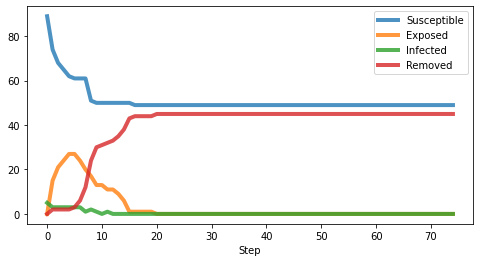

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


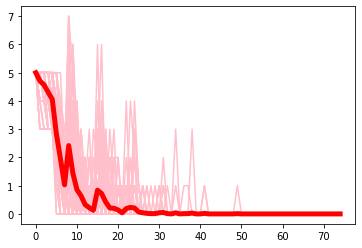

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


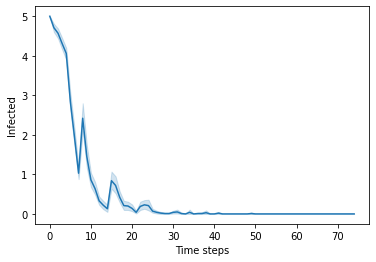

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
19                           27           30  0.455957
34                            4           18  0.738380
31                            3           39  0.114784
30                            1           26  0.069343
3                             1           10  0.094610
4                             1           12  0.077140
2                             1           18  0.055526
9                             1            9  0.900006
14                            1           35  0.076429
65                            0           30  0.826656
71                            0           16  0.369394
70                            0           33  0.091917
69                            0           28  0.349150
68                            0           36  0.646256
67                            0           18  0.055756
66                            0           12  0.041045
1                             0           11  0.119811
64                            0           32  0.051605
63                            0           22  0.077950
72                            0           32  0.260580

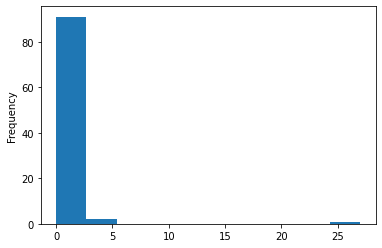

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

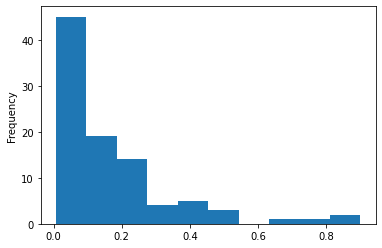

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=94
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 28
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       3.381337               86          329                  5   
1       2.545046               83          331                  5   
2       2.644425               58          309                  5   
3       2.587407               57          326                  5   
4       3.332337               73          314                  5   
..           ...              ...          ...                ...   
95      3.042830               74          320                  5   
96      2.819930               69          340                  5   
97      3.355828               15          293                  5   
98      3.195465               38          309                  5   
99      2.534847               83          318                  9   

    max_2_trans  num_of_S  
0            28         4  
1            19         9  
2            19        32  
3            12        34  
4            24        17  
..          ...       ...  
95           11        15  
96           14        22  
97            3        76  
98           16        53  
99           33        10  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  3.11213280916214 0.05005350620706926
Average_found_positives:  62.37 1.7838022606361126
Average_total_tests:  320.77 1.2099632684966561
Average_max_outbreak_size:  5.19 0.06918720031095843
Average_max_2_trans: 18.43 0.6733385838379147
Average_number_of_uninfected: 29.0 1.7911116124018647


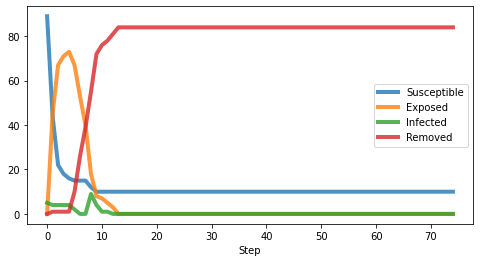

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


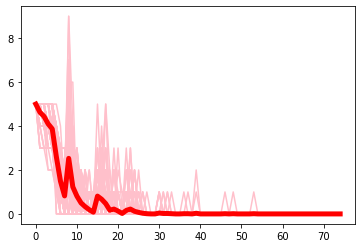

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


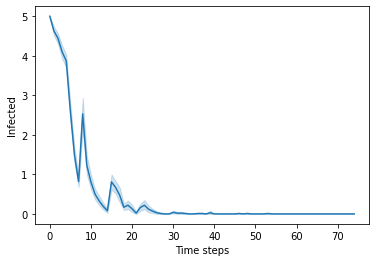

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
84                           33           40  0.600554
14                           25           35  0.523464
2                            11           18  0.314546
74                            5           26  0.201272
31                            2           39  0.173249
49                            1           19  0.347042
19                            1           30  0.220042
18                            1           38  0.072002
62                            0           23  0.184354
68                            0           36  0.145179
67                            0           18  0.024507
66                            0           12  0.134709
65                            0           30  0.030719
64                            0           32  0.032158
63                            0           22  0.330657
1                             0           11  0.113972
61                            0           22  0.653893
70                            0           33  0.003966
60                            0           28  0.154705
59                            0           16  0.371458

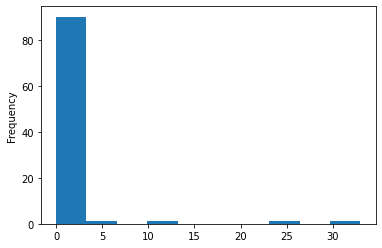

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

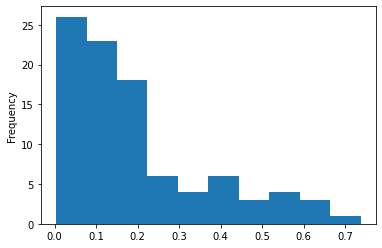

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=94
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 28
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       6.344089               65          333                  5   
1       5.138159               53          323                  5   
2       7.084941               71          337                  5   
3       4.325563               69          337                  6   
4       4.894559               48          319                  5   
..           ...              ...          ...                ...   
95      4.763412               40          323                  5   
96      4.741275               85          321                  5   
97      4.596565               74          326                  5   
98      4.541368               88          344                  5   
99      3.864971               44          318                  5   

    max_2_trans  num_of_S  
0            17        29  
1            14        37  
2            18        22  
3            13        23  
4            19        44  
..          ...       ...  
95           10        51  
96           28         5  
97           19        18  
98           33         5  
99           13        48  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  5.0266733288764955 0.08230628918996402
Average_found_positives:  62.0 1.7673240629364901
Average_total_tests:  328.78 1.7940744216177407
Average_max_outbreak_size:  5.75 0.17545035845739468
Average_max_2_trans: 18.43 0.7187608585038363
Average_number_of_uninfected: 29.28 1.767957218733736


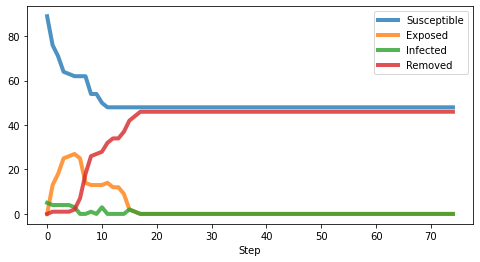

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


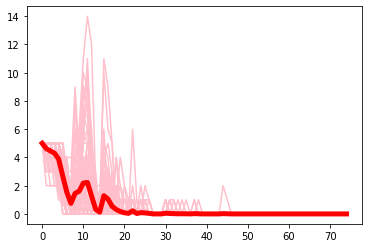

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


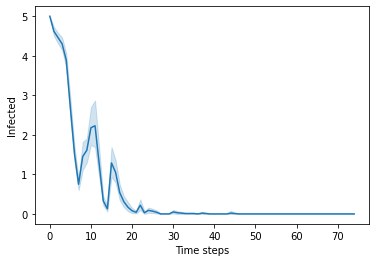

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
34                           13           18  0.368984
52                           12           21  0.360579
36                            4           36  0.146488
15                            3           32  0.322961
13                            3           37  0.182328
19                            2           30  0.169083
6                             1           24  0.031018
88                            1           20  0.042916
11                            1           17  0.046450
21                            1           38  0.066705
64                            0           32  0.082857
69                            0           28  0.292153
68                            0           36  0.351845
67                            0           18  0.613419
66                            0           12  0.323446
65                            0           30  0.252407
1                             0           11  0.035049
63                            0           22  0.136498
62                            0           23  0.116355
71                            0           16  0.384744

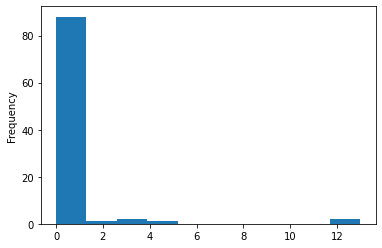

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

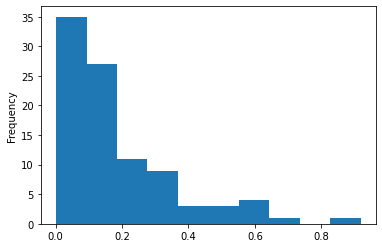

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(5, 14), (4, 15), (40, 15), (8, 16), (16, 16)]

In [ ]:
group_df

Group  Degree  Intra_C         order  record  flag
14  [63, 60, 61, 69, 62]     132        9      0.000029      15     1
7   [59, 55, 57, 91, 92]     115        7      0.000024      15     1
16  [70, 71, 75, 73, 74]     128        7      0.000021      15     1
6   [56, 53, 54, 88, 90]      89        6      0.000013      15     1
18      [81, 87, 85, 86]      67        5      0.000016      14     0
12  [28, 45, 41, 43, 46]     119        5  11254.038363      15     0
11  [40, 21, 38, 37, 23]     106        6   1246.976536      15     0
5    [29, 9, 26, 47, 49]     108        6    878.861381      15     0
4    [25, 8, 22, 31, 34]     109        6    614.801464      15     0
2     [18, 5, 6, 48, 51]     110        6    144.025322      15     0
8    [50, 17, 4, 14, 52]      96        5     37.777318      15     0
9   [30, 11, 27, 93, 89]     107        4      6.545516      15     0
1     [12, 2, 3, 33, 39]      98        7      2.100117      15     0
0     [13, 0, 1, 19, 32]      99        6      2.001010      15     0
10  [83, 84, 35, 10, 16]     128        4      0.802947      15     0
3    [20, 7, 15, 24, 36]      90        7      0.268536      15     0
13  [42, 44, 68, 58, 64]     100        4      0.000537      15     0
17  [79, 77, 78, 82, 80]     135       10      0.000034      15     0
15  [67, 72, 65, 66, 76]     134        9      0.000030      15     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
34                           13           18  0.368984
52                           12           21  0.360579
36                            4           36  0.146488
15                            3           32  0.322961
13                            3           37  0.182328
19                            2           30  0.169083
6                             1           24  0.031018
88                            1           20  0.042916
11                            1           17  0.046450
21                            1           38  0.066705
64                            0           32  0.082857
69                            0           28  0.292153
68                            0           36  0.351845
67                            0           18  0.613419
66                            0           12  0.323446
65                            0           30  0.252407
1                             0           11  0.035049
63                            0           22  0.136498
62                            0           23  0.116355
71                            0           16  0.384744

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=94
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 28
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       4.155929               49          318                  5   
1       3.741858               34          299                  5   
2       4.206542               39          294                 27   
3       5.289524               50          317                 21   
4       3.900828               29          289                 30   
..           ...              ...          ...                ...   
95      4.870612               43          304                 30   
96      4.581846               28          299                 31   
97      4.276862               43          307                  5   
98      4.696332               38          294                 23   
99      4.072442               55          308                 19   

    max_2_trans  num_of_S  
0            18        41  
1            11        58  
2            33         4  
3            31         3  
4            23        17  
..          ...       ...  
95           34         0  
96           13        19  
97           22        44  
98           20         6  
99           26         4  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  4.114932186603546 0.05932821536888812
Average_found_positives:  36.61 0.7475069676375375
Average_total_tests:  304.38 1.2313070988657426
Average_max_outbreak_size:  22.62 0.9079647570252934
Average_max_2_trans: 20.61 0.6832623762124435
Average_number_of_uninfected: 18.31 1.6885051065808168


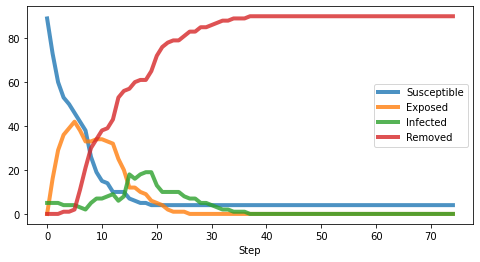

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


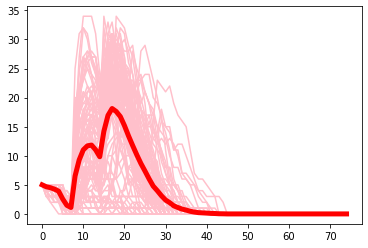

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


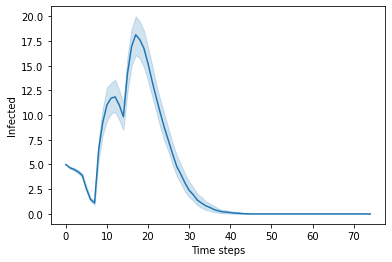

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
13                           26           37  0.216840
82                           10           20  0.129977
31                           10           39  0.556491
84                            8           40  0.269895
28                            7           29  0.090387
88                            7           20  0.116414
75                            4           23  0.439622
92                            3           19  0.989349
64                            2           32  0.022112
38                            2           22  0.063560
69                            1           28  0.024074
67                            1           18  0.397317
74                            1           26  0.116780
21                            1           38  0.079187
80                            1           24  0.370870
6                             1           24  0.147675
60                            0           28  0.218827
61                            0           22  0.464719
54                            0           23  0.088309
62                            0           23  0.135786

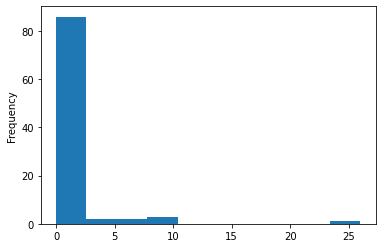

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

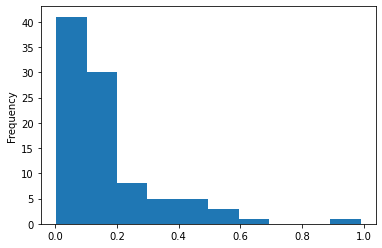

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(4, 13), (20, 15), (85, 18), (90, 19), (24, 20)]

In [ ]:
group_df

Group  Degree  Intra_C     order  record  flag
11  [40, 21, 38, 37, 23]     106        6  0.815644      24     1
13  [42, 44, 68, 58, 64]     100        4  0.762410       9     1
9   [30, 11, 27, 93, 89]     107        4  0.759902      21     1
1     [12, 2, 3, 33, 39]      98        7  0.728022      21     1
3    [20, 7, 15, 24, 36]      90        7  1.387840      10     0
18      [81, 87, 85, 86]      67        5  1.293894       3     0
14  [63, 60, 61, 69, 62]     132        9  1.287134       8     0
10  [83, 84, 35, 10, 16]     128        4  1.242909      17     0
6   [56, 53, 54, 88, 90]      89        6  1.238925       4     0
16  [70, 71, 75, 73, 74]     128        7  1.120425       8     0
15  [67, 72, 65, 66, 76]     134        9  1.080793       8     0
12  [28, 45, 41, 43, 46]     119        5  1.064994      26     0
4    [25, 8, 22, 31, 34]     109        6  1.037477      25     0
2     [18, 5, 6, 48, 51]     110        6  1.009587      19     0
5    [29, 9, 26, 47, 49]     108        6  0.993360      24     0
0     [13, 0, 1, 19, 32]      99        6  0.963425      20     0
7   [59, 55, 57, 91, 92]     115        7  0.869871       8     0
8    [50, 17, 4, 14, 52]      96        5  0.849990      21     0
17  [79, 77, 78, 82, 80]     135       10  0.849980       8     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
13                           26           37  0.216840
82                           10           20  0.129977
31                           10           39  0.556491
84                            8           40  0.269895
28                            7           29  0.090387
88                            7           20  0.116414
75                            4           23  0.439622
92                            3           19  0.989349
64                            2           32  0.022112
38                            2           22  0.063560
69                            1           28  0.024074
67                            1           18  0.397317
74                            1           26  0.116780
21                            1           38  0.079187
80                            1           24  0.370870
6                             1           24  0.147675
60                            0           28  0.218827
61                            0           22  0.464719
54                            0           23  0.088309
62                            0           23  0.135786

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_4['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_4])
temp = temp.reset_index()

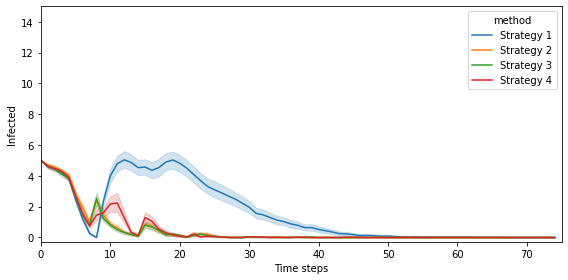

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
plt.ylim(top = 15)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/LH10_infect_result_500.csv')

# LyonSchool

In [ ]:
#load data
file = '/content/drive/MyDrive/Colab Notebooks/Real_data/tij_LyonSchool.dat'
from io import StringIO

edge_list = pd.read_fwf(file, names = ['time', 'id1', 'id2'])#.iloc[: , 1:]
#edge_list['id1'] = [i.split('\t',1)[0] for i in edge_list['edge']]
#edge_list['id2'] = [i.split('\t',1)[1] for i in edge_list['edge']]
edge_list = edge_list.drop_duplicates(subset=['id1', 'id2'], keep='last')
G_temp = nx.from_pandas_edgelist(edge_list, "id1", "id2")
G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
lar_cc = max(nx.connected_components(G), key=len)
print("Diameter: ", nx.diameter(G.subgraph(lar_cc)))
print("Average shortest path length: ", nx.average_shortest_path_length(G.subgraph(lar_cc)))
#edge_list
list(nx.isolates(G))
len(lar_cc)

# of nodes:  287
Average degree:  48.45296167247387
Diameter:  3
Average shortest path length:  1.8601875225387667


236

In [ ]:
len(lar_cc)

236

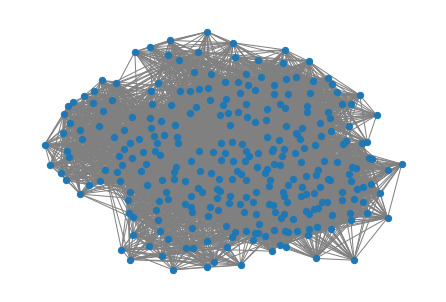

In [ ]:
nx.draw(G, pos = nx.kamada_kawai_layout(G), node_size = 40, edge_color = 'grey')

##Testing Strategy _0

In [ ]:
pop=287
steps=100
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = G)
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


5.891955375671387
      Susceptible  Exposed  Infected  Removed
Step                                         
0             282        0         5        0
1             261       21         5        0
2             247       35         5        0
3             238       44         5        0
4             230       52         5        0
5             224       58         5        0
6             218       64         4        1
7             214       68         4        1
8             132      129        24        2
9              95      152        37        3
10             71      167        43        6
11             56      174        48        9
12             43      181        53       10
13             32      186        51       18
14             24      190        46       27
15             10      122       117       38
16              4       91       144       48
17              3       68       151       65
18              2       54       153       78
19              

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  157
number_of_uninfected: 0


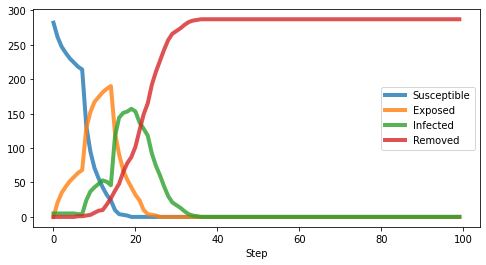

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
43                           42           60  0.217040
9                            29           70  0.247285
167                          21           68  0.594526
237                          19           44  0.367449
25                           14           21  0.165064
155                          13           69  0.228349
136                          13           71  0.292207
190                          12           70  0.273854
263                          12           39  0.134225
184                          11           49  0.218038
51                           10           78  0.117184
42                            9           78  0.335737
276                           9           48  0.135780
211                           8           67  0.016877
261                           6           34  0.022220
59                            6           85  0.088395
111                           5           60  0.251976
197                           3           65  0.137395
19                            3           22  0.290316
217                           2           66  0.044930

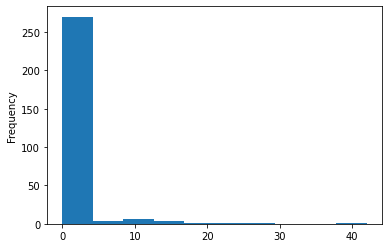

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

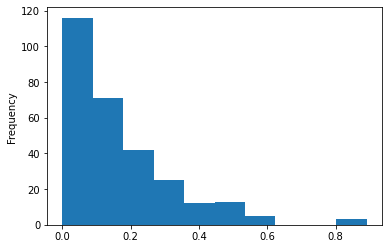

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=287
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
capacity = 86
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       5.765041              205         4795                 38   
1       5.700676              206         4795                 38   
2       6.754275              202         4795                 29   
3       5.694990              164         4795                 29   
4       5.657369              205         4795                 30   
..           ...              ...          ...                ...   
95      5.665115              220         4795                 26   
96      5.586719              172         4795                 24   
97      7.018351              217         4795                 28   
98      6.221438              214         4795                 42   
99      5.644008              174         4795                 30   

    max_2_trans  num_of_S  
0            48         4  
1            60         1  
2            19         1  
3            46        51  
4            35         1  
..          ...       ...  
95           68         4  
96           34        52  
97           66         4  
98           49         2  
99           34        51  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  5.993710200786591 0.06627451752398862
Average_found_positives:  191.12 2.4396257371518564
Average_total_tests:  4795.0 0.0
Average_max_outbreak_size:  28.65 0.6187924049340299
Average_max_2_trans: 46.43 1.3564849852289245
Average_number_of_uninfected: 29.87 3.2099169251970787


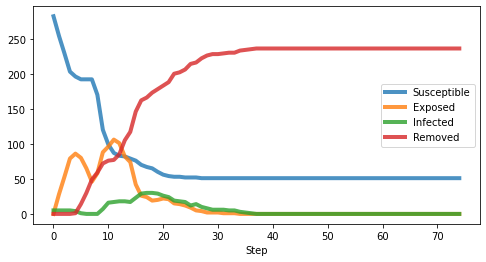

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


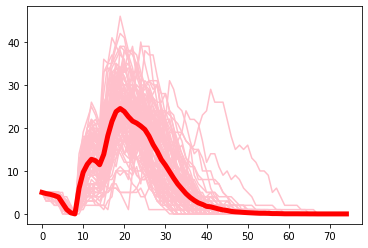

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

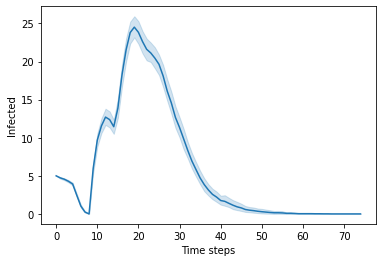

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
43                           34           60  0.345992
114                          33           59  0.179928
70                           28           75  0.374828
103                          14           66  1.253175
94                           12           50  0.090290
145                          12           27  0.835430
178                          11           69  0.378235
211                           9           67  0.280879
175                           9           81  0.361294
190                           8           70  0.307876
139                           7           72  0.335210
120                           6           36  0.053886
97                            5           50  0.017443
213                           5           62  0.320391
159                           4           27  0.402429
136                           4           71  0.190481
18                            4           42  0.339666
80                            3           70  0.331022
68                            3           61  0.212007
56                            3           37  0.051255

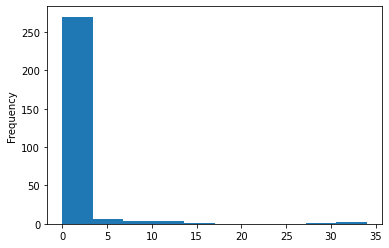

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

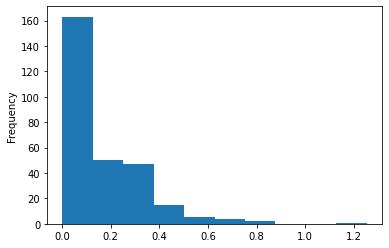

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=287
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 86
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       5.931072              236          548                  5   
1       5.708129              200          538                  5   
2       5.694509              238          568                  5   
3       5.680687              214          572                  5   
4       5.667591              177          552                  5   
..           ...              ...          ...                ...   
95      5.703554              252          551                  5   
96      5.659538              162          545                  5   
97      5.955260              268          571                  5   
98      5.701653              246          571                  5   
99      5.707218              210          562                  5   

    max_2_trans  num_of_S  
0            38        48  
1            30        84  
2            21        47  
3            40        72  
4            24       107  
..          ...       ...  
95           37        31  
96           47       122  
97           51        18  
98           42        40  
99           49        75  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  6.068262677192688 0.06519549979569919
Average_found_positives:  226.9 2.760306673051552
Average_total_tests:  558.11 1.6049730165452576
Average_max_outbreak_size:  5.0 0.0
Average_max_2_trans: 43.13 1.5138188381531905
Average_number_of_uninfected: 57.68 2.7392353131868936


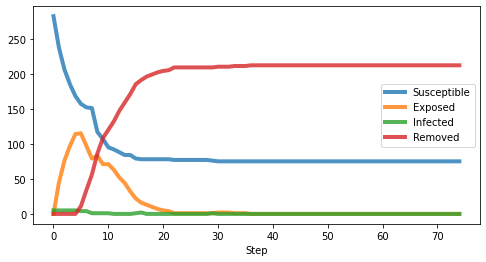

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


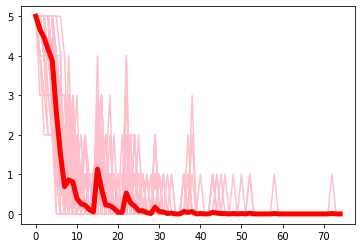

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


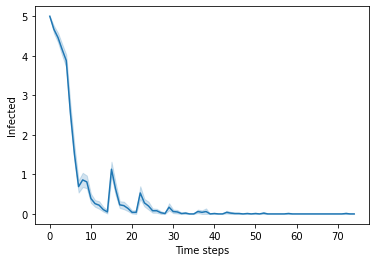

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
61                           49           73  0.253245
174                          37           91  0.081538
142                          19           29  0.352100
33                           16           27  0.173473
224                          10           49  0.060960
82                           10           63  0.672870
121                          10           64  0.345101
1                             8           55  0.668473
114                           7           59  0.350071
18                            4           42  0.237520
42                            3           78  0.126670
191                           3           48  0.182695
200                           3           69  0.241872
29                            3           82  0.158289
140                           2           27  0.431432
45                            2           73  0.057635
183                           2           38  0.224004
204                           2           21  0.480963
203                           2           70  0.032437
30                            2           73  0.458778

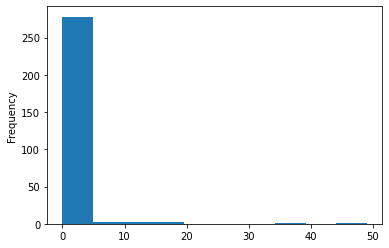

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

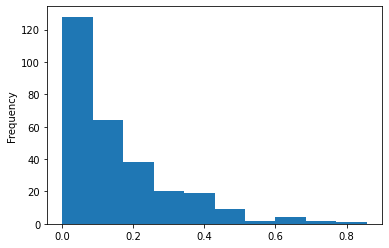

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=287
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 86
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       6.985106              258          571                  5   
1       8.904844              208          553                  5   
2       6.834125              235          548                  5   
3       7.091488              239          546                  5   
4       6.871197              203          572                  5   
..           ...              ...          ...                ...   
95      8.772868              211          565                  5   
96      6.965195              205          566                  5   
97      6.799219              253          581                  6   
98      6.805745              262          551                  5   
99      7.031702              258          574                  5   

    max_2_trans  num_of_S  
0            47        28  
1            50        76  
2            28        49  
3            55        46  
4            43        82  
..          ...       ...  
95           56        75  
96           33        81  
97           40        34  
98           74        23  
99           54        28  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  7.236282436847687 0.08038876998847591
Average_found_positives:  219.62 3.396426523761869
Average_total_tests:  556.28 1.6443401550331807
Average_max_outbreak_size:  5.07 0.03258245174347936
Average_max_2_trans: 42.67 1.5271320582164212
Average_number_of_uninfected: 65.32 3.368627691694724


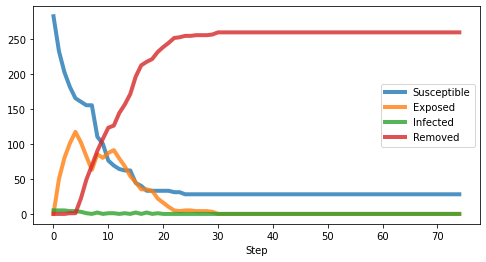

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


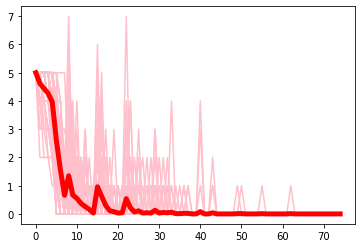

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


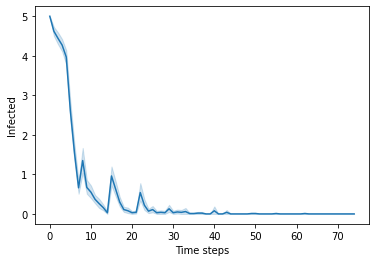

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
68                           54           61  0.455720
30                           30           73  0.103471
111                          26           60  0.784759
275                          26           46  0.232527
179                          18           87  0.300722
267                          17           31  0.207707
228                          16           65  0.529160
137                           6           53  0.436080
173                           4           75  0.209199
181                           4           54  0.188060
37                            4           57  0.269739
58                            4           61  0.171046
43                            3           60  0.096981
62                            3           42  0.074744
229                           3           45  0.070714
54                            3           33  0.202882
219                           3           58  0.637985
117                           3           71  0.107540
15                            3           60  0.189121
126                           2           27  0.173787

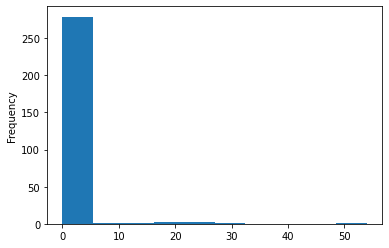

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

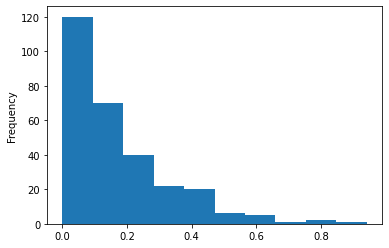

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=287
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 86
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      16.969183              249          615                  6   
1      15.208970              256          648                 13   
2      14.361994              219          604                 11   
3      15.182001              190          564                  5   
4      15.483149              267          674                 19   
..           ...              ...          ...                ...   
95     14.855298              236          632                  5   
96     16.211671              209          564                  5   
97     13.215497              177          526                  5   
98     14.182412              211          605                  5   
99     14.764303              231          592                  5   

    max_2_trans  num_of_S  
0            67        35  
1            37        29  
2            45        64  
3            33        94  
4            49        17  
..          ...       ...  
95           32        47  
96           57        75  
97           52       107  
98           36        75  
99           44        54  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  14.946403312683106 0.16236630008911754
Average_found_positives:  215.26 4.191396189839613
Average_total_tests:  599.89 4.479693689925189
Average_max_outbreak_size:  6.5 0.2706147136286629
Average_max_2_trans: 41.28 1.3343995736743257
Average_number_of_uninfected: 68.84 4.22067350650164


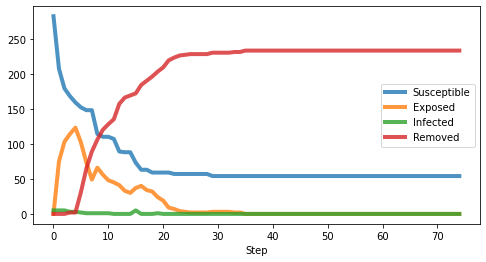

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


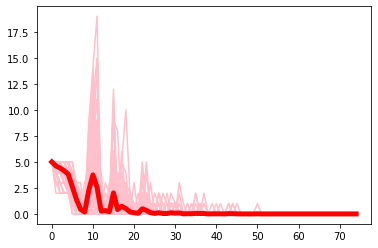

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


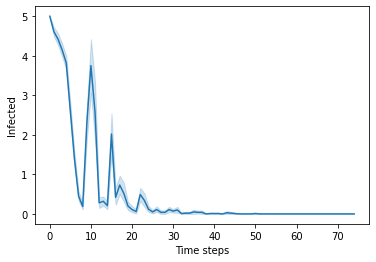

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
250                          44           45  0.602253
139                          42           72  0.203817
47                           25           61  0.329180
4                            21           25  0.307626
122                          16           52  0.646334
186                          11           98  0.169042
73                            8           49  0.341811
99                            8           49  0.303319
189                           8           49  0.251399
228                           7           65  0.249028
10                            5           43  0.253783
164                           4           45  0.399647
148                           4           23  0.266060
125                           3           36  0.066745
177                           3           90  0.216246
140                           2           27  0.238647
137                           2           53  0.209931
219                           2           58  0.009786
71                            2           23  0.255038
31                            2           46  0.138782

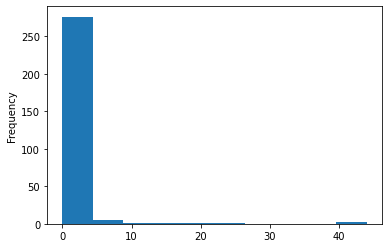

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

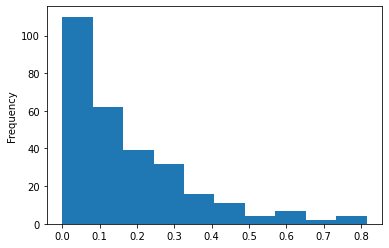

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(204, 28), (177, 28), (15, 32), (48, 34), (93, 34)]

In [ ]:
group_df

Group  Degree  Intra_C  \
3   [286, 284, 285, 239, 236, 237, 241, 238, 240, ...     379       28   
6             [9, 10, 33, 22, 32, 20, 14, 16, 23, 15]     447       24   
4     [203, 205, 214, 24, 17, 18, 229, 227, 228, 233]     344       18   
20  [177, 175, 176, 180, 178, 179, 200, 181, 189, ...     654       34   
19  [155, 162, 160, 161, 166, 164, 165, 174, 170, ...     619       21   
23  [219, 204, 210, 216, 212, 213, 225, 215, 220, ...     605       30   
7            [21, 44, 29, 30, 54, 38, 39, 45, 41, 42]     577       19   
21  [182, 183, 188, 185, 186, 195, 187, 190, 196, ...     529       24   
22  [193, 197, 192, 194, 202, 198, 199, 207, 201, ...     514       25   
10      [75, 103, 59, 100, 121, 105, 113, 66, 63, 64]     516       19   
15  [110, 118, 143, 117, 123, 163, 122, 157, 127, ...     507       19   
8           [120, 43, 55, 58, 46, 49, 62, 47, 48, 67]     538       19   
18  [149, 150, 172, 168, 171, 158, 151, 153, 159, ...     491       15   
13          [85, 95, 91, 94, 99, 92, 93, 101, 97, 98]     505       25   
17  [140, 136, 137, 152, 138, 145, 144, 139, 141, ...     485       27   
27  [264, 266, 271, 269, 270, 274, 272, 273, 277, ...     423       44   
12           [76, 89, 82, 78, 80, 88, 81, 83, 90, 84]     502       21   
16  [126, 130, 125, 128, 146, 131, 133, 142, 134, ...     481       29   
9            [50, 51, 65, 57, 60, 56, 52, 53, 86, 61]     481       17   
11           [72, 68, 70, 74, 69, 71, 79, 73, 77, 96]     478       29   
24  [217, 218, 224, 222, 223, 244, 242, 243, 247, ...     442       20   
25  [246, 250, 248, 249, 253, 251, 252, 256, 254, ...     406       37   
26  [259, 257, 258, 262, 260, 261, 268, 263, 265, ...     402       35   
14  [119, 114, 115, 111, 107, 108, 116, 109, 112, ...     441       42   
5               [28, 25, 26, 13, 6, 7, 12, 8, 11, 87]     538       18   
2     [35, 27, 34, 209, 211, 106, 102, 104, 167, 169]     466       19   
0              [2, 0, 1, 234, 235, 5, 3, 4, 226, 230]     424       21   
1       [132, 19, 40, 147, 148, 37, 31, 36, 231, 232]     417       16   
28                [276, 280, 278, 279, 283, 281, 282]     295       20   

           order  record  flag  
3   1.083807e+16      17     1  
6   5.560845e+15      17     1  
4   5.342606e+09      17     1  
20  4.893135e+38      18     1  
19  5.680633e+35      18     1  
23  9.326368e+34      18     1  
7   2.503329e+31      18     1  
21  2.797843e+30      17     0  
22  2.696297e+29      17     0  
10  3.653411e+28      17     0  
15  1.730968e+28      17     0  
8   4.273214e+27      17     0  
18  2.711724e+27      17     0  
13  9.349554e+26      17     0  
17  6.978828e+26      17     0  
27  5.824531e+26      17     0  
12  9.952912e+25      17     0  
16  7.110921e+25      17     0  
9   7.010023e+25      17     0  
11  4.920701e+25      17     0  
24  4.784086e+25      17     0  
25  4.325818e+25      17     0  
26  1.611467e+25      17     0  
14  6.562105e+23      17     0  
5   5.881161e+22      17     0  
2   2.304133e+20      17     0  
0   2.153040e+18      17     0  
1   4.406069e+17      17     0  
28  3.732717e+16      17     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
250                          44           45  0.602253
139                          42           72  0.203817
47                           25           61  0.329180
4                            21           25  0.307626
122                          16           52  0.646334
186                          11           98  0.169042
73                            8           49  0.341811
99                            8           49  0.303319
189                           8           49  0.251399
228                           7           65  0.249028
10                            5           43  0.253783
164                           4           45  0.399647
148                           4           23  0.266060
125                           3           36  0.066745
177                           3           90  0.216246
140                           2           27  0.238647
137                           2           53  0.209931
219                           2           58  0.009786
71                            2           23  0.255038
31                            2           46  0.138782

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=287
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 86
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.924206              164          566                 38   
1      11.968559              141          536                 44   
2      13.802378              147          556                 47   
3      14.501801              163          585                 57   
4      13.422690              184          605                 43   
..           ...              ...          ...                ...   
95     11.993611              138          537                 48   
96     12.775955              169          575                 33   
97     14.275431              153          581                 33   
98     12.482373              153          565                 75   
99     11.965436              147          546                 85   

    max_2_trans  num_of_S  
0            27        50  
1            40        58  
2            51        53  
3            37        23  
4            36        26  
..          ...       ...  
95           59        60  
96           66        51  
97           21        49  
98           62         0  
99           51         5  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  12.914223680496216 0.08918337983522417
Average_found_positives:  154.34 1.1179183396569778
Average_total_tests:  561.86 2.4347243844597335
Average_max_outbreak_size:  53.7 1.6169243780846538
Average_max_2_trans: 44.41 1.3796570354089945
Average_number_of_uninfected: 32.54 2.264411534142943


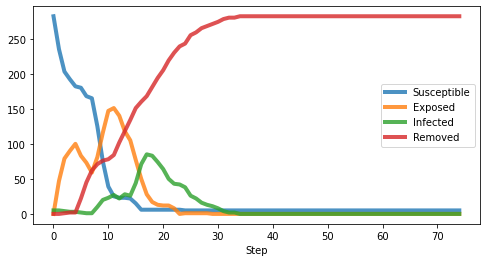

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


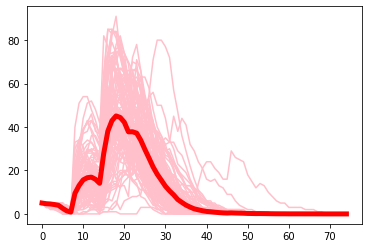

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


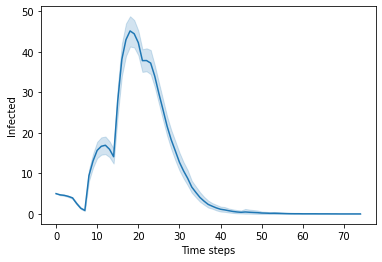

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
64                           51           70  0.186786
285                          45           48  0.555506
27                           25           78  0.497060
227                          23           65  0.359117
24                           20           69  0.296531
39                           18           40  0.326478
210                           9           29  0.436100
169                           8           74  0.317961
132                           7           21  0.637337
66                            7           38  0.416197
74                            6           30  0.578739
29                            5           82  0.080016
108                           5           28  0.316852
95                            5           69  0.109399
202                           4           33  0.031252
21                            4           33  0.159357
28                            3           32  0.142232
1                             3           55  0.108710
204                           3           21  0.731202
133                           3           40  0.255794

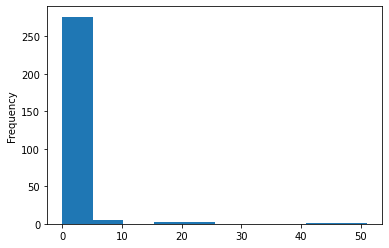

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

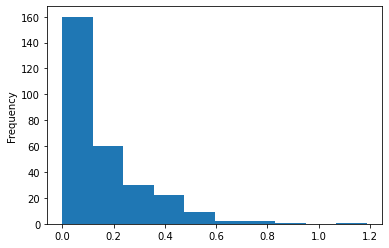

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(154, 19), (160, 19), (171, 28), (142, 33), (157, 33)]

In [ ]:
group_df

Group  Degree  Intra_C  \
20  [177, 175, 176, 180, 178, 179, 200, 181, 189, ...     654       34   
27  [264, 266, 271, 269, 270, 274, 272, 273, 277, ...     423       44   
25  [246, 250, 248, 249, 253, 251, 252, 256, 254, ...     406       37   
26  [259, 257, 258, 262, 260, 261, 268, 263, 265, ...     402       35   
23  [219, 204, 210, 216, 212, 213, 225, 215, 220, ...     605       30   
9            [50, 51, 65, 57, 60, 56, 52, 53, 86, 61]     481       17   
10      [75, 103, 59, 100, 121, 105, 113, 66, 63, 64]     516       19   
28                [276, 280, 278, 279, 283, 281, 282]     295       20   
3   [286, 284, 285, 239, 236, 237, 241, 238, 240, ...     379       28   
17  [140, 136, 137, 152, 138, 145, 144, 139, 141, ...     485       27   
19  [155, 162, 160, 161, 166, 164, 165, 174, 170, ...     619       21   
15  [110, 118, 143, 117, 123, 163, 122, 157, 127, ...     507       19   
16  [126, 130, 125, 128, 146, 131, 133, 142, 134, ...     481       29   
24  [217, 218, 224, 222, 223, 244, 242, 243, 247, ...     442       20   
13          [85, 95, 91, 94, 99, 92, 93, 101, 97, 98]     505       25   
5               [28, 25, 26, 13, 6, 7, 12, 8, 11, 87]     538       18   
14  [119, 114, 115, 111, 107, 108, 116, 109, 112, ...     441       42   
12           [76, 89, 82, 78, 80, 88, 81, 83, 90, 84]     502       21   
11           [72, 68, 70, 74, 69, 71, 79, 73, 77, 96]     478       29   
1       [132, 19, 40, 147, 148, 37, 31, 36, 231, 232]     417       16   
4     [203, 205, 214, 24, 17, 18, 229, 227, 228, 233]     344       18   
6             [9, 10, 33, 22, 32, 20, 14, 16, 23, 15]     447       24   
21  [182, 183, 188, 185, 186, 195, 187, 190, 196, ...     529       24   
18  [149, 150, 172, 168, 171, 158, 151, 153, 159, ...     491       15   
22  [193, 197, 192, 194, 202, 198, 199, 207, 201, ...     514       25   
2     [35, 27, 34, 209, 211, 106, 102, 104, 167, 169]     466       19   
7            [21, 44, 29, 30, 54, 38, 39, 45, 41, 42]     577       19   
8           [120, 43, 55, 58, 46, 49, 62, 47, 48, 67]     538       19   
0              [2, 0, 1, 234, 235, 5, 3, 4, 226, 230]     424       21   

           order  record  flag  
20  1.064904e+22      36     1  
27  8.087185e+18      36     1  
25  1.037883e+18      36     1  
26  6.681060e+17      36     1  
23  6.353192e+16      36     1  
9   3.224920e+14       6     1  
10  3.155879e+14      24     1  
28  6.279736e+14      20     0  
3   6.058073e+14      28     0  
17  5.564846e+14      13     0  
19  5.087069e+14      29     0  
15  4.799415e+14      26     0  
16  4.226713e+14       3     0  
24  4.204318e+14      34     0  
13  4.885348e+12       0     0  
5   3.355918e+12       0     0  
14  1.215186e+12       1     0  
12  1.209497e+11       0     0  
11  4.657407e+09       0     0  
1   4.144521e+09       0     0  
4   1.161534e+09       0     0  
6   3.886490e+08       0     0  
21  7.457874e+16      35     0  
18  4.177075e+14      23     0  
22  4.043590e+14      26     0  
2   3.834328e+14       7     0  
7   3.655021e+14      30     0  
8   3.428983e+14      10     0  
0   3.423507e+14       2     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
64                           51           70  0.186786
285                          45           48  0.555506
27                           25           78  0.497060
227                          23           65  0.359117
24                           20           69  0.296531
39                           18           40  0.326478
210                           9           29  0.436100
169                           8           74  0.317961
132                           7           21  0.637337
66                            7           38  0.416197
74                            6           30  0.578739
29                            5           82  0.080016
108                           5           28  0.316852
95                            5           69  0.109399
202                           4           33  0.031252
21                            4           33  0.159357
28                            3           32  0.142232
1                             3           55  0.108710
204                           3           21  0.731202
133                           3           40  0.255794

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

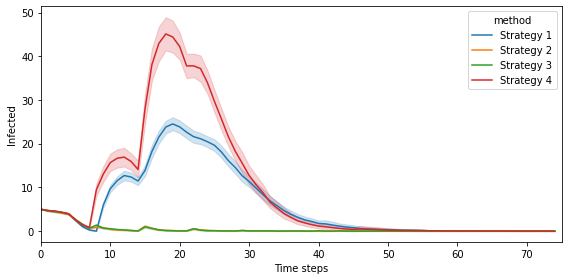

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
##plt.ylim(top = 12)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/LyonSchool_infect_result_500.csv')

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_4['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_4])
temp = temp.reset_index()

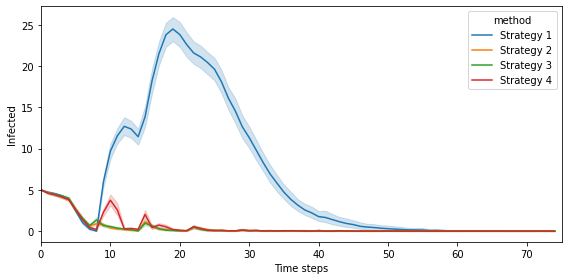

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
##plt.ylim(top = 12)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/LyonSchool_infect_result_2.csv')

# SFHH

In [ ]:
#load data
file = '/content/drive/MyDrive/Colab Notebooks/Real_data/tij_SFHH.dat'
from io import StringIO

edge_list = pd.read_fwf(file, names = ['time', 'id1','id2']).iloc[: , 1:]
G_temp = nx.from_pandas_edgelist(edge_list, "id1", "id2")
G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
lar_cc = max(nx.connected_components(G), key=len)
print("Diameter: ", nx.diameter(G.subgraph(lar_cc)))
print("Average shortest path length: ", nx.average_shortest_path_length(G.subgraph(lar_cc)))
#edge_list
list(nx.isolates(G))
len(lar_cc)

# of nodes:  403
Average degree:  47.468982630272954
Diameter:  4
Average shortest path length:  1.9530140858980531


403

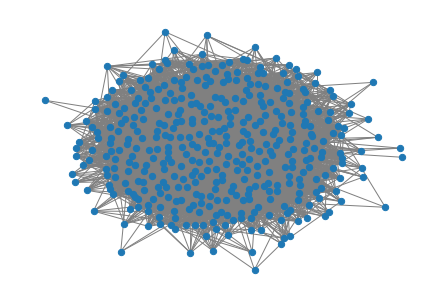

In [ ]:
nx.draw(G, pos = nx.kamada_kawai_layout(G), node_size = 40, edge_color = 'grey')

##Testing Strategy _0

In [ ]:
pop=403
steps=100
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = G)
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


12.126842498779297
      Susceptible  Exposed  Infected  Removed
Step                                         
0             398        0         5        0
1             377       21         5        0
2             363       35         5        0
3             356       42         4        1
4             352       46         3        2
5             349       49         3        2
6             348       50         3        2
7             347       51         3        2
8             226      151        20        6
9             118      245        32        8
10             79      277        35       12
11             59      293        33       18
12             49      300        35       19
13             42      306        32       23
14             38      309        26       30
15             12      214       134       43
16              6      112       226       59
17              6       73       249       75
18              4       55       246       98
19             

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  249
number_of_uninfected: 1


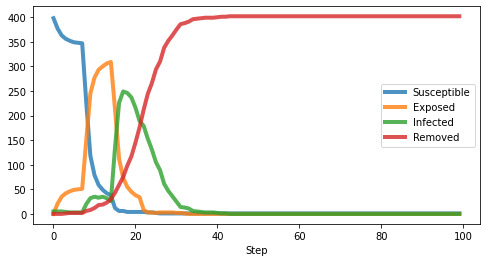

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
291                          28           55  0.289944
76                           25           91  0.605287
125                          24           93  0.257763
276                          22           42  0.729770
72                           18          163  0.124556
191                          17          122  0.085204
381                          16           60  0.335476
62                           15           80  0.388234
11                           14           85  0.172831
99                           14           72  0.123577
5                            13          108  0.243880
378                          12           19  0.105141
12                           11           63  0.098146
53                           11          108  0.122102
153                           9           87  0.231048
193                           9           84  0.126553
96                            9          116  0.038180
104                           9           35  0.698986
127                           9           47  0.036813
341                           8           53  0.134576

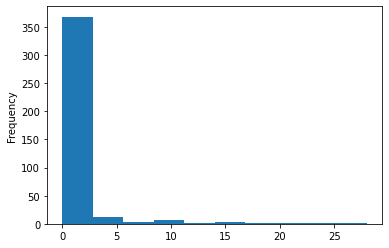

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

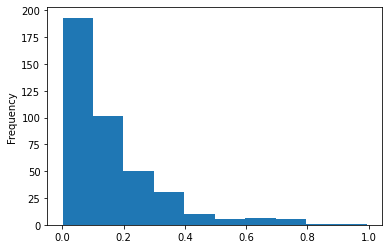

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=403
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
capacity = 80
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      13.405778              306         4602                 44   
1      13.354383              308         4602                 47   
2      13.373324              310         4602                 33   
3      13.267428              306         4602                 59   
4      13.323634              313         4602                 62   
..           ...              ...          ...                ...   
95      7.299649              308         4602                 33   
96      6.986497              313         4602                 41   
97      7.529269              316         4602                 31   
98      7.292304              314         4602                 40   
99      7.290275              305         4602                 36   

    max_2_trans  num_of_S  
0            63        18  
1            38        15  
2            57        18  
3            41        19  
4            38        13  
..          ...       ...  
95           44        16  
96           57         9  
97           41        15  
98           48        18  
99           42        17  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  7.7396384048461915 0.17253277805848227
Average_found_positives:  311.73 0.6522463127724468
Average_total_tests:  4602.0 0.0
Average_max_outbreak_size:  45.0 0.6621056096906583
Average_max_2_trans: 53.14 1.7533817253374906
Average_number_of_uninfected: 15.71 0.39804953754957983


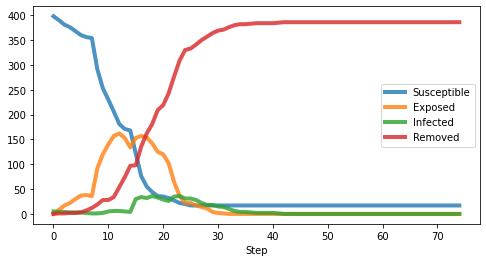

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


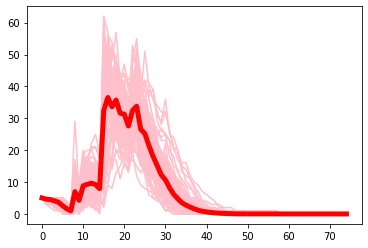

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

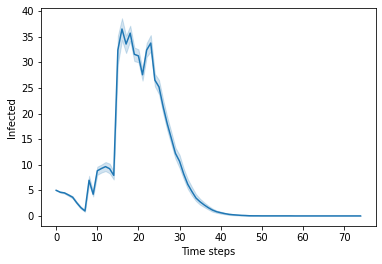

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
144                          42           63  0.590917
181                          34           59  0.442520
62                           22           80  0.229618
21                           22          169  0.245711
200                          21          101  0.049384
72                           19          163  0.147303
324                          14           48  0.102534
185                          12          104  0.186128
20                           12           65  0.224869
108                          11           28  0.079563
52                            9           53  0.111094
101                           9           68  0.277050
35                            7           81  0.198105
363                           7           50  0.080399
80                            6           39  0.081753
92                            5          156  0.143884
132                           5           99  0.179718
146                           5           42  0.107821
193                           5           84  0.085482
117                           5           56  0.107027

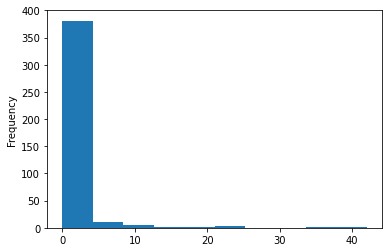

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

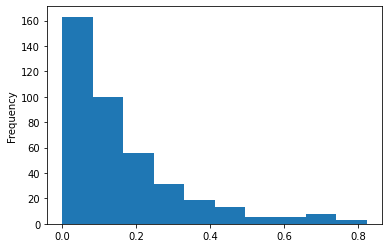

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=403
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 80
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       7.416090              360          867                 34   
1       7.153428              370          783                 51   
2       9.001023              363          882                 34   
3       7.137178              368          885                 37   
4       7.328769              367          845                 28   
..           ...              ...          ...                ...   
95      7.564652              366          935                 30   
96      7.478767              364          893                 24   
97      7.656627              377          895                 37   
98      7.594110              357          869                 20   
99      7.703466              369          865                 36   

    max_2_trans  num_of_S  
0            40        25  
1            37        20  
2            50        25  
3            86        21  
4            94        19  
..          ...       ...  
95           66        21  
96           25        24  
97           46        15  
98           22        33  
99           64        18  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  7.4789538788795475 0.04140984835994257
Average_found_positives:  367.51 0.5850830900156165
Average_total_tests:  880.43 4.1537923526689315
Average_max_outbreak_size:  30.7 0.7819297547824494
Average_max_2_trans: 53.95 2.110645217065917
Average_number_of_uninfected: 23.39 0.5194976205698902


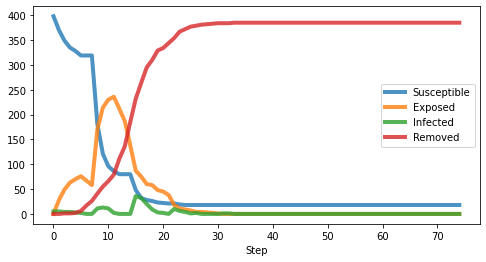

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


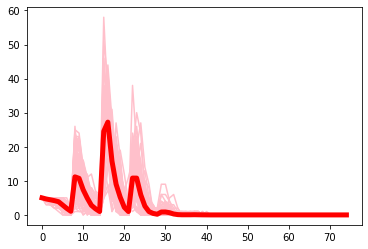

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


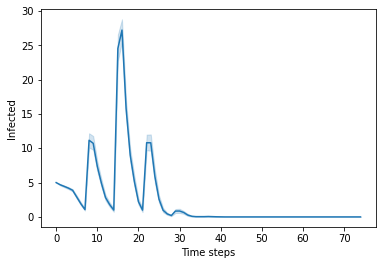

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
191                          64          122  0.161690
83                           60          119  0.594590
92                           30          156  0.196370
200                          29          101  0.468593
224                          16          101  0.199196
21                           15          169  0.137754
173                          14          121  0.241027
182                          11           53  0.412447
369                          10           12  0.224537
198                           9          168  0.127620
105                           9          127  0.048250
76                            6           91  0.057613
30                            6           70  0.286119
240                           6           70  0.091048
400                           6           45  0.140257
104                           5           35  0.614644
58                            4           63  0.260593
397                           4            4  0.208113
35                            3           81  0.527406
358                           3           76  0.169801

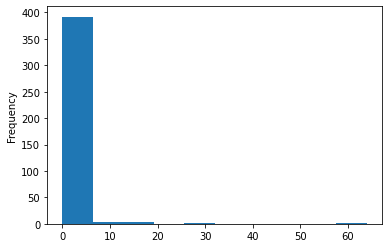

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

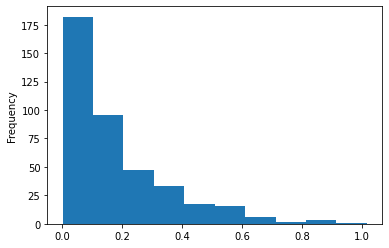

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=403
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 80
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       9.633255              370          830                 34   
1       9.440468              377          895                 35   
2       9.686567              355          804                 42   
3       9.469868              372          860                 34   
4      11.349012              373          833                 43   
..           ...              ...          ...                ...   
95     11.638029              370          784                 33   
96     11.816360              375          874                 43   
97     10.804271              376          907                 30   
98     10.929259              361          805                 37   
99     12.089915              365          834                 34   

    max_2_trans  num_of_S  
0           105        19  
1            37        24  
2            57        33  
3            67        16  
4            50        22  
..          ...       ...  
95           82        21  
96           44        16  
97           38        20  
98           37        24  
99           69        25  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  9.952938373088836 0.09470621018590764
Average_found_positives:  367.59 0.6703074825869999
Average_total_tests:  875.95 4.432031592893268
Average_max_outbreak_size:  31.97 0.7902761312581594
Average_max_2_trans: 52.07 1.9951079057423324
Average_number_of_uninfected: 22.94 0.5976080266657682


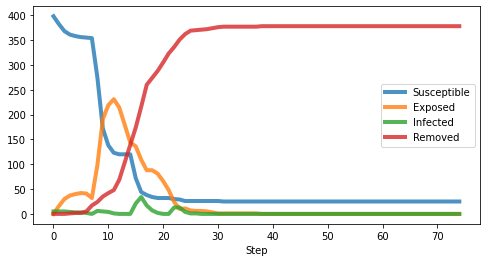

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


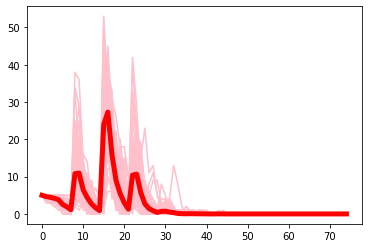

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


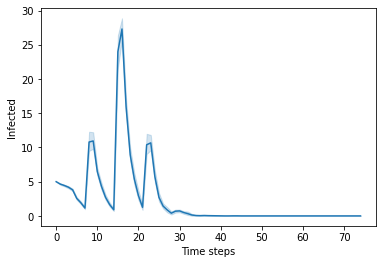

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
21                           69          169  0.538415
81                           26          158  0.151040
12                           24           63  0.547276
10                           21           74  0.376181
75                           20           53  0.512773
256                          19           29  0.165123
105                          16          127  0.159395
215                          14           89  0.204269
73                           10           24  0.109827
261                          10           54  0.048979
365                           7           77  0.221087
345                           6           63  0.248806
26                            6           74  0.178720
36                            6           82  0.269408
132                           6           99  0.199070
281                           5           33  0.033525
191                           5          122  0.094148
399                           5           60  0.493602
293                           5           83  0.086096
74                            5           25  0.491177

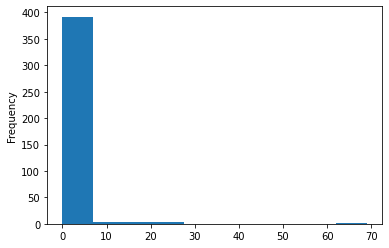

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

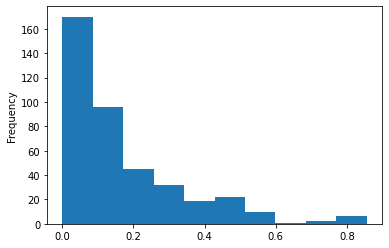

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=403
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 80
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      28.345083              367         1082                 26   
1      31.409964              364         1160                 23   
2      31.012412              361         1029                 47   
3      29.419379              372         1068                 35   
4      33.872104              365         1203                 28   
..           ...              ...          ...                ...   
95     23.126999              369         1071                 26   
96     23.546427              368         1124                 24   
97     24.441726              369         1122                 39   
98     22.483677              356         1081                 22   
99     23.326038              375         1050                 28   

    max_2_trans  num_of_S  
0            44        22  
1            26        24  
2            74        23  
3            66        18  
4            70        21  
..          ...       ...  
95           45        20  
96           47        24  
97           50        21  
98           42        31  
99           76        17  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  28.236335842609407 0.4265180098489515
Average_found_positives:  366.9 0.6829082195753953
Average_total_tests:  1100.63 5.8598902840764975
Average_max_outbreak_size:  27.41 0.6663779677927504
Average_max_2_trans: 52.7 1.8631731377985623
Average_number_of_uninfected: 23.17 0.5932371389506081


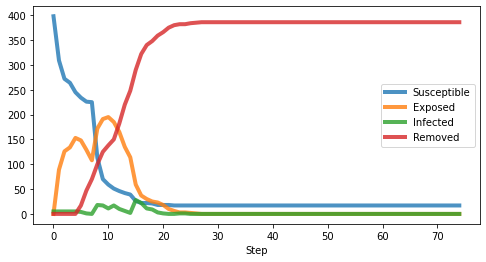

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


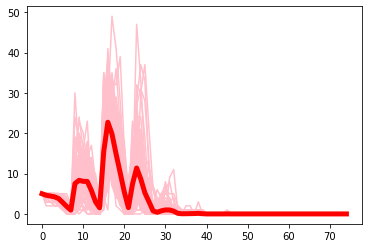

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


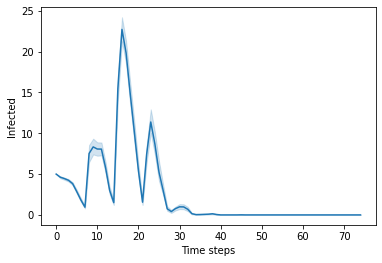

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
215                          76           89  0.601341
109                          52           75  0.306403
191                          42          122  0.130623
153                          16           87  0.631266
53                           15          108  0.243804
82                           13           77  0.308609
207                           8           42  0.510999
32                            8           94  0.317389
196                           8           76  0.471308
356                           7           97  0.297523
285                           6           61  0.253050
27                            6          104  0.462643
9                             5           79  0.316543
240                           5           70  0.166978
292                           5          118  0.153953
277                           5           62  0.139969
17                            5           74  0.430936
91                            5           37  0.291391
259                           5           58  0.320950
346                           5           61  0.180584

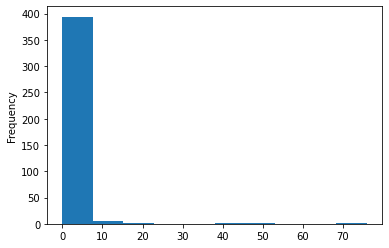

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

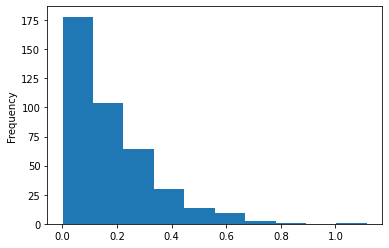

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(395, 22), (201, 24), (359, 24), (374, 25), (205, 26)]

In [ ]:
group_df

Group  Degree  Intra_C  \
38  [349, 386, 341, 365, 388, 346, 374, 352, 361, ...     277       11   
40                                    [396, 355, 395]     126        2   
8     [115, 86, 87, 153, 301, 102, 95, 100, 233, 262]     720       18   
31  [179, 187, 222, 180, 191, 247, 186, 211, 203, ...     641       17   
9    [124, 96, 101, 234, 250, 190, 97, 184, 225, 253]     627       16   
11  [125, 108, 113, 182, 189, 159, 123, 141, 229, ...     582       16   
19         [402, 104, 55, 78, 2, 0, 1, 157, 177, 335]     562       16   
22       [378, 91, 88, 89, 389, 70, 24, 32, 394, 289]     563       18   
0             [5, 3, 4, 148, 205, 10, 6, 7, 126, 127]     640       17   
20     [398, 328, 351, 390, 356, 27, 20, 23, 321, 56]     549       12   
3        [31, 22, 26, 155, 161, 39, 28, 29, 370, 380]     613       18   
13  [290, 139, 142, 270, 348, 197, 140, 145, 338, ...     521       16   
27  [138, 110, 121, 199, 119, 154, 188, 129, 146, ...     510       12   
4        [46, 35, 45, 287, 288, 60, 37, 48, 267, 364]     586       14   
1            [11, 8, 9, 75, 77, 14, 12, 13, 194, 196]     621       29   
33  [223, 218, 219, 379, 238, 256, 354, 241, 251, ...     507       13   
6       [135, 58, 65, 317, 347, 80, 63, 64, 236, 292]     535       13   
5          [59, 42, 43, 210, 252, 85, 50, 71, 92, 93]     577       22   
10  [128, 99, 116, 249, 360, 172, 103, 109, 166, 174]     479       15   
32  [202, 305, 200, 228, 331, 227, 231, 224, 214, ...     477       12   
15  [215, 208, 209, 254, 255, 369, 220, 243, 306, ...     463       20   
16  [366, 217, 259, 293, 304, 320, 232, 240, 353, ...     450       13   
34  [260, 261, 344, 273, 274, 327, 264, 275, 359, ...     443       15   
25    [263, 98, 38, 41, 371, 334, 336, 358, 143, 117]     438       11   
12  [324, 114, 144, 213, 325, 152, 130, 131, 309, ...     430       15   
7        [90, 67, 68, 339, 340, 84, 79, 83, 160, 175]     424       20   
24        [69, 30, 21, 25, 74, 72, 73, 299, 245, 246]     432       14   
17  [308, 239, 248, 310, 337, 363, 307, 311, 373, ...     429       14   
37   [277, 319, 342, 313, 316, 314, 52, 53, 372, 318]     416       12   
26   [118, 271, 44, 94, 195, 120, 122, 107, 105, 106]     396       12   
30  [326, 173, 176, 315, 162, 185, 171, 169, 170, ...     390       18   
36    [345, 282, 343, 283, 284, 312, 81, 62, 76, 303]     389       13   
18  [66, 198, 362, 111, 112, 237, 295, 276, 242, 265]     384       13   
23    [206, 235, 392, 393, 294, 391, 400, 61, 33, 34]     391       16   
21      [47, 49, 329, 357, 201, 204, 367, 57, 36, 51]     387       13   
2       [17, 15, 16, 212, 323, 207, 18, 19, 178, 192]     473       14   
14  [291, 164, 226, 296, 297, 266, 183, 221, 298, ...     357       16   
35  [302, 401, 278, 279, 350, 285, 286, 332, 280, ...     347       11   
39    [82, 40, 54, 384, 377, 382, 385, 387, 383, 397]     339       10   
29  [257, 150, 147, 149, 181, 163, 168, 167, 156, ...     333       10   
28  [132, 134, 268, 133, 165, 322, 136, 137, 258, ...     306       12   

           order  record  flag  
38  1.398180e+17      12     1  
40  6.459640e+04      12     1  
8   3.731714e+51      13     1  
31  1.328970e+45      13     1  
9   1.706520e+44      13     1  
11  3.783185e+40      13     1  
19  1.684121e+39      13     1  
22  2.533783e+39      12     0  
0   2.859869e+38      12     0  
20  5.043350e+37      12     0  
3   4.413625e+36      12     0  
13  8.973382e+35      12     0  
27  7.388081e+35      12     0  
4   7.155954e+35      12     0  
1   2.341184e+35      12     0  
33  1.802695e+35      12     0  
6   6.162908e+34      12     0  
5   4.064938e+33      12     0  
10  1.178156e+33      12     0  
32  4.897254e+32      12     0  
15  1.339837e+32      12     0  
16  5.293941e+30      12     0  
34  2.800866e+30      12     0  
25  1.574653e+30      12     0  
12  2.593707e+29      12     0  
7   1.848458e+29      12     0  
24  1.718822e+29      12     0  
17  1.429134e+2

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
215                          76           89  0.601341
109                          52           75  0.306403
191                          42          122  0.130623
153                          16           87  0.631266
53                           15          108  0.243804
82                           13           77  0.308609
207                           8           42  0.510999
32                            8           94  0.317389
196                           8           76  0.471308
356                           7           97  0.297523
285                           6           61  0.253050
27                            6          104  0.462643
9                             5           79  0.316543
240                           5           70  0.166978
292                           5          118  0.153953
277                           5           62  0.139969
17                            5           74  0.430936
91                            5           37  0.291391
259                           5           58  0.320950
346                           5           61  0.180584

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=403
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 80
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      17.217932              174          596                128   
1      16.709624              170          595                119   
2      17.426273              174          585                117   
3      16.813914              176          596                103   
4      18.483485              172          585                118   
..           ...              ...          ...                ...   
95     16.013780              162          555                119   
96     18.358035              173          606                124   
97     15.767785              152          546                132   
98     16.347009              166          557                122   
99     16.489838              170          575                119   

    max_2_trans  num_of_S  
0            84         6  
1            42         7  
2            27         6  
3            69         8  
4            77         6  
..          ...       ...  
95           41         4  
96           39         2  
97           85         6  
98           57         3  
99           37         5  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  16.41797771692276 0.062055695346827686
Average_found_positives:  166.03 0.6920114146311447
Average_total_tests:  579.94 2.140698460547374
Average_max_outbreak_size:  124.97 1.117035669470177
Average_max_2_trans: 54.66 2.0366450923818884
Average_number_of_uninfected: 5.48 0.17949423895541


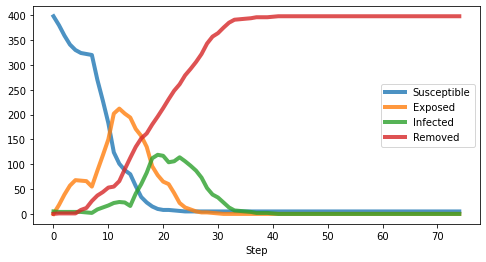

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


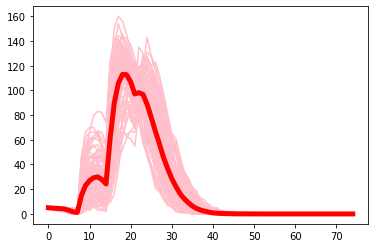

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


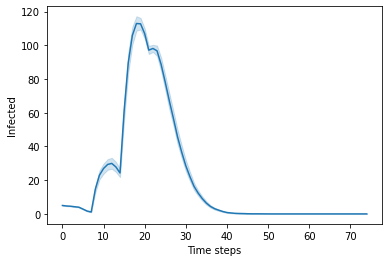

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
173                          37          121  0.101395
199                          36           42  0.324158
343                          34           40  0.309031
17                           33           74  1.220015
325                          19           60  0.180640
233                          17           60  0.230805
272                          14           57  0.171638
367                          14           78  0.095260
292                          13          118  0.032452
153                          11           87  0.417602
208                          11           77  0.282520
374                           9           39  0.240187
139                           9           83  0.116651
317                           8           51  0.149765
53                            7          108  0.193422
269                           6           47  0.151086
59                            6           59  0.150840
294                           6           40  0.221930
281                           6           33  0.225185
110                           6           40  0.222754

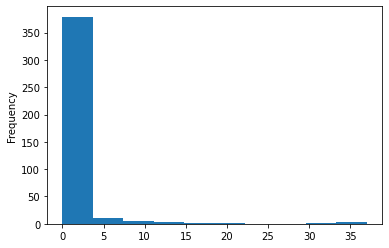

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

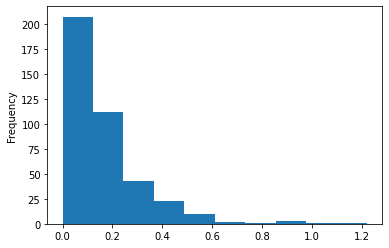

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(379, 22), (183, 23), (289, 23), (49, 23), (268, 23)]

In [ ]:
group_df

Group  Degree  Intra_C  \
8     [115, 86, 87, 153, 301, 102, 95, 100, 233, 262]     720       18   
31  [179, 187, 222, 180, 191, 247, 186, 211, 203, ...     641       17   
25    [263, 98, 38, 41, 371, 334, 336, 358, 143, 117]     438       11   
5          [59, 42, 43, 210, 252, 85, 50, 71, 92, 93]     577       22   
10  [128, 99, 116, 249, 360, 172, 103, 109, 166, 174]     479       15   
23    [206, 235, 392, 393, 294, 391, 400, 61, 33, 34]     391       16   
27  [138, 110, 121, 199, 119, 154, 188, 129, 146, ...     510       12   
22       [378, 91, 88, 89, 389, 70, 24, 32, 394, 289]     563       18   
19         [402, 104, 55, 78, 2, 0, 1, 157, 177, 335]     562       16   
20     [398, 328, 351, 390, 356, 27, 20, 23, 321, 56]     549       12   
7        [90, 67, 68, 339, 340, 84, 79, 83, 160, 175]     424       20   
21      [47, 49, 329, 357, 201, 204, 367, 57, 36, 51]     387       13   
18  [66, 198, 362, 111, 112, 237, 295, 276, 242, 265]     384       13   
36    [345, 282, 343, 283, 284, 312, 81, 62, 76, 303]     389       13   
26   [118, 271, 44, 94, 195, 120, 122, 107, 105, 106]     396       12   
16  [366, 217, 259, 293, 304, 320, 232, 240, 353, ...     450       13   
17  [308, 239, 248, 310, 337, 363, 307, 311, 373, ...     429       14   
4        [46, 35, 45, 287, 288, 60, 37, 48, 267, 364]     586       14   
9    [124, 96, 101, 234, 250, 190, 97, 184, 225, 253]     627       16   
34  [260, 261, 344, 273, 274, 327, 264, 275, 359, ...     443       15   
15  [215, 208, 209, 254, 255, 369, 220, 243, 306, ...     463       20   
33  [223, 218, 219, 379, 238, 256, 354, 241, 251, ...     507       13   
32  [202, 305, 200, 228, 331, 227, 231, 224, 214, ...     477       12   
11  [125, 108, 113, 182, 189, 159, 123, 141, 229, ...     582       16   
0             [5, 3, 4, 148, 205, 10, 6, 7, 126, 127]     640       17   
37   [277, 319, 342, 313, 316, 314, 52, 53, 372, 318]     416       12   
30  [326, 173, 176, 315, 162, 185, 171, 169, 170, ...     390       18   
14  [291, 164, 226, 296, 297, 266, 183, 221, 298, ...     357       16   
39    [82, 40, 54, 384, 377, 382, 385, 387, 383, 397]     339       10   
35  [302, 401, 278, 279, 350, 285, 286, 332, 280, ...     347       11   
29  [257, 150, 147, 149, 181, 163, 168, 167, 156, ...     333       10   
28  [132, 134, 268, 133, 165, 322, 136, 137, 258, ...     306       12   
38  [349, 386, 341, 365, 388, 346, 374, 352, 361, ...     277       11   
40                                    [396, 355, 395]     126        2   
6       [135, 58, 65, 317, 347, 80, 63, 64, 236, 292]     535       13   
13  [290, 139, 142, 270, 348, 197, 140, 145, 338, ...     521       16   
3        [31, 22, 26, 155, 161, 39, 28, 29, 370, 380]     613       18   
24        [69, 30, 21, 25, 74, 72, 73, 299, 245, 246]     432       14   
1            [11, 8, 9, 75, 77, 14, 12, 13, 194, 196]     621       29   
12  [324, 114, 144, 213, 325, 152, 130, 131, 309, ...     430       15   
2       [17, 15, 16, 212, 323, 207, 18, 19, 178, 192]     473       14   

           order  record  flag  
8   7.672860e+17      36     1  
31  1.069243e+16      36     1  
25  1.103782e+15       5     1  
5   1.076824e+15      19     1  
10  1.043722e+15       7     1  
23  1.029544e+15       2     1  
27  9.527195e+14      23     1  
22  1.852558e+15      23     0  
19  1.838371e+15      25     0  
20  1.820586e+15      30     0  
7   1.791190e+15       2     0  
21  1.767531e+15       1     0  
18  1.760336e+15       6     0  
36  1.707579e+15       0     0  
26  1.685260e+15       1     0  
16  1.603102e+15       7     0  
17  1.600240e+15       6     0  
4   1.597170e+15      18     0  
9   1.532724e+15      34     0  
34  1.519544e+15       8     0  
15  1.519004e+15      17     0  
33  1.494753e+15      19     0  
32  1.494500e+15      16     0  
11  1.440651e+15      28     0  
0   1.440587e+15      31     0  
37  1.426118e+15       6     0  
30  8.714199e+14       0     0  
14  6.068209e+1

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
173                          37          121  0.101395
199                          36           42  0.324158
343                          34           40  0.309031
17                           33           74  1.220015
325                          19           60  0.180640
233                          17           60  0.230805
272                          14           57  0.171638
367                          14           78  0.095260
292                          13          118  0.032452
153                          11           87  0.417602
208                          11           77  0.282520
374                           9           39  0.240187
139                           9           83  0.116651
317                           8           51  0.149765
53                            7          108  0.193422
269                           6           47  0.151086
59                            6           59  0.150840
294                           6           40  0.221930
281                           6           33  0.225185
110                           6           40  0.222754

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

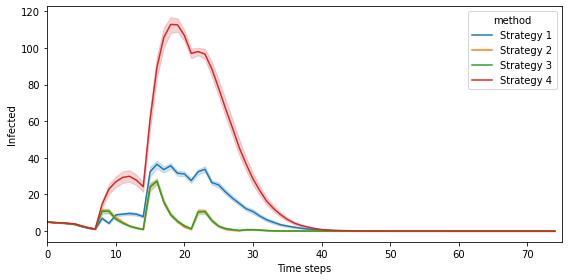

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
#plt.ylim(top = 12)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/SFHH_infect_result_500.csv')

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_4['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_4])
temp = temp.reset_index()

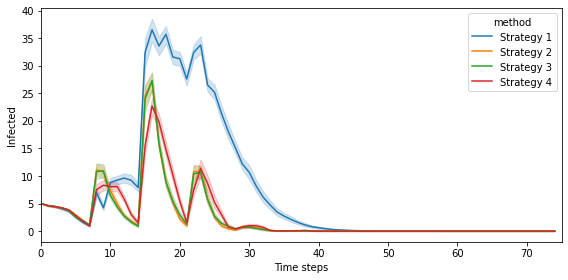

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
#plt.ylim(top = 12)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/SFHH_infect_result_2.csv')

# Thiers13

In [ ]:
#load data
file = '/content/drive/MyDrive/Colab Notebooks/Real_data/tij_Thiers13.dat'
from io import StringIO

edge_list = pd.read_fwf(file, names = ['time', 'edge'])#.iloc[: , 1:]
edge_list['id1'] = [i.split('\t',1)[0] for i in edge_list['edge']]
edge_list['id2'] = [i.split('\t',1)[1] for i in edge_list['edge']]
edge_list = edge_list.drop_duplicates(subset=['id1', 'id2'], keep='last')
G_temp = nx.from_pandas_edgelist(edge_list, "id1", "id2")
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
lar_cc = max(nx.connected_components(G), key=len)
print("Diameter: ", nx.diameter(G.subgraph(lar_cc)))
print("Average shortest path length: ", nx.average_shortest_path_length(G.subgraph(lar_cc)))
#edge_list

# of nodes:  345
Average degree:  34.71304347826087
Diameter:  4
Average shortest path length:  2.193663633299629


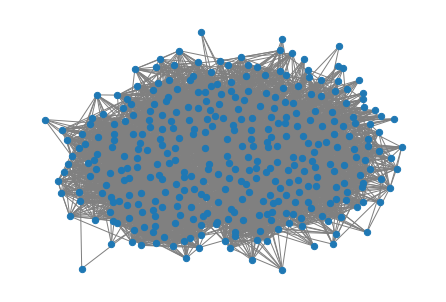

In [ ]:
nx.draw(G, pos = nx.kamada_kawai_layout(G), node_size = 40, edge_color = 'grey')

##Testing Strategy _0

In [ ]:
pop=345
steps=100
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = G)
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


4.056326627731323
      Susceptible  Exposed  Infected  Removed
Step                                         
0             340        0         5        0
1             309       31         5        0
2             288       52         4        1
3             270       70         4        1
4             261       79         3        2
5             254       86         3        2
6             254       86         0        5
7             254       86         0        5
8             162      147        29        7
9             113      175        47       10
10             76      194        59       16
11             56      205        67       17
12             40      214        65       26
13             33      221        58       33
14             27      227        54       37
15             12      150       132       51
16              6      107       161       71
17              4       72       182       87
18              2       54       180      109
19              

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  182
number_of_uninfected: 1


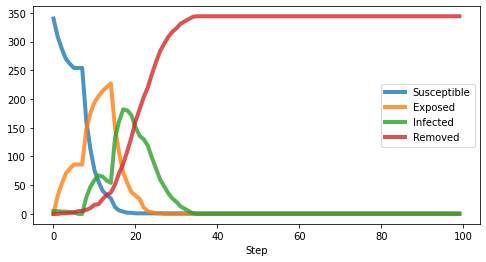

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
214                          32           45  0.400899
26                           30           60  0.440345
178                          26           49  0.199268
83                           23           33  0.499109
31                           19           67  0.229963
38                           19           72  0.233537
58                           13           51  0.061009
130                          12           42  0.204007
99                           12           35  0.315478
93                           10           29  0.547828
66                           10           75  0.179289
166                           8           39  0.048113
217                           7           40  0.281717
227                           7           46  0.282164
5                             7           42  0.231941
184                           6           44  0.188607
72                            5           51  0.308523
277                           5           39  0.380377
242                           4           59  0.439666
120                           4           38  0.149125

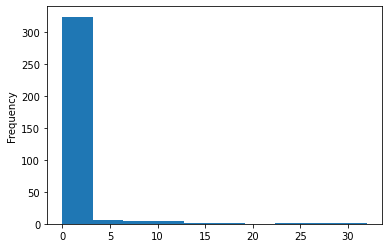

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

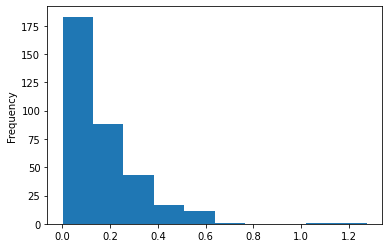

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=345
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
capacity = 103
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       5.354912              245         5772                 37   
1       5.391462              245         5772                 24   
2       5.539679              241         5772                 34   
3       5.389199              240         5772                 38   
4       5.397008              237         5772                 41   
..           ...              ...          ...                ...   
95      5.380947              236         5772                 41   
96      5.200316              249         5772                 35   
97      5.335197              239         5772                 28   
98      5.527617              232         5772                 36   
99      5.294237              235         5772                 39   

    max_2_trans  num_of_S  
0            44        15  
1            34        15  
2            47         7  
3            37         8  
4            46        17  
..          ...       ...  
95           25         8  
96           66        14  
97           28         6  
98           34        13  
99           43        11  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  5.44448805809021 0.030866903649369982
Average_found_positives:  238.19 2.388977000959011
Average_total_tests:  5772.0 0.0
Average_max_outbreak_size:  31.2 0.6252272314199782
Average_max_2_trans: 37.39 1.0093397181656267
Average_number_of_uninfected: 16.16 3.233902480367219


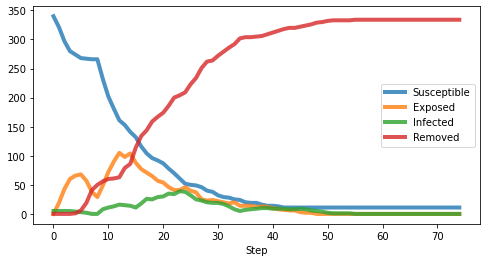

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


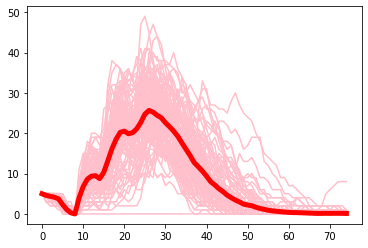

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

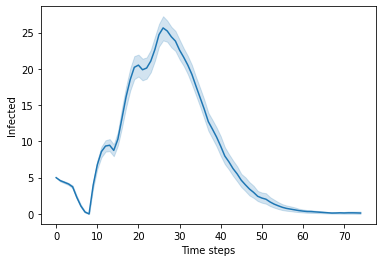

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
126                          43           86  0.167753
187                          30           41  0.211954
52                           26           42  0.444801
257                          17           52  0.166874
238                          17           68  0.118557
148                          16           51  0.110624
38                           14           72  0.256413
125                          14           61  0.085907
191                          14           57  0.237533
332                          14           14  0.167678
325                           9           41  0.236643
128                           9           63  0.428207
274                           9           32  0.117131
97                            8           52  0.032561
59                            6           36  0.231297
235                           6           41  0.342320
36                            6           54  0.084110
199                           6           40  0.152119
220                           5           48  0.095664
288                           5           24  0.049290

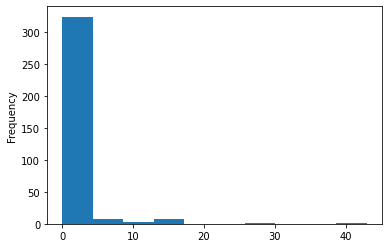

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

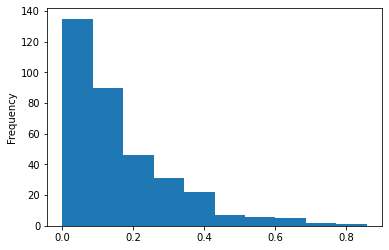

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=345
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 103
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       5.343863              121          659                  5   
1       5.605697              202          679                  5   
2       5.406233              132          664                  5   
3       5.398328              201          679                  5   
4       5.587419              257          669                  5   
..           ...              ...          ...                ...   
95      5.182138              177          678                  5   
96      5.373401              122          679                  5   
97      5.238864              162          669                  5   
98      5.232617              127          669                  5   
99      5.427887              169          669                  5   

    max_2_trans  num_of_S  
0            36       221  
1            37       142  
2            18       211  
3            47       143  
4            33        86  
..          ...       ...  
95           45       167  
96           28       222  
97           58       181  
98           25       216  
99           27       174  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  5.510229573249817 0.03111808320034673
Average_found_positives:  174.03 5.071497995581968
Average_total_tests:  669.1 1.0091000090589772
Average_max_outbreak_size:  5.0 0.0
Average_max_2_trans: 33.21 1.1886920917078942
Average_number_of_uninfected: 169.09 5.0704351017651454


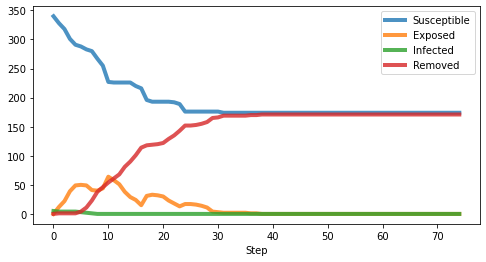

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


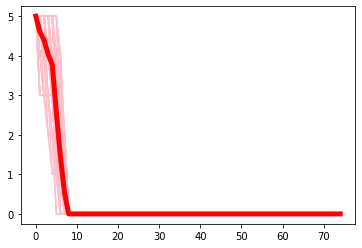

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


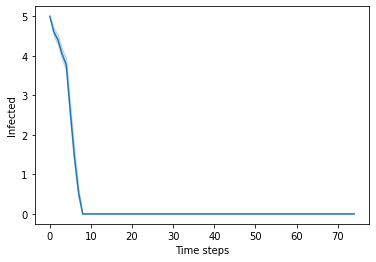

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
106                          27           27  0.321932
337                          14           22  0.240150
63                           12           58  0.761878
154                          11           56  0.335028
104                          11           56  0.024145
316                          10           32  0.029765
173                           9           76  0.141434
307                           9           41  0.690926
59                            7           36  0.262009
77                            7           48  0.390275
292                           5           57  0.171692
258                           4           43  0.297402
245                           4           41  0.261018
143                           4           45  0.610093
14                            3           62  0.077835
334                           3           22  0.371112
221                           3           43  0.196001
229                           3           41  0.516268
120                           3           38  0.077378
269                           2           32  0.224511

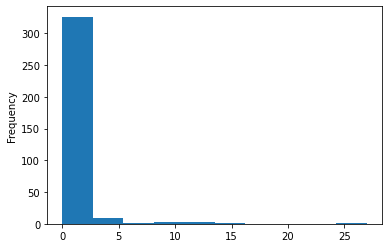

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

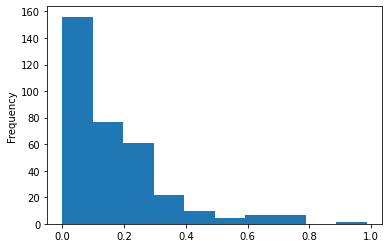

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=345
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 103
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       7.645767              150          689                  5   
1       6.252862              100          679                  5   
2       6.369216              280          679                  5   
3       6.190766              171          668                  5   
4       6.186282              192          689                  5   
..           ...              ...          ...                ...   
95      6.149724              205          659                  5   
96      6.072687              212          649                  5   
97      6.303356              135          649                  5   
98      6.203721              243          679                  5   
99      6.137754              210          669                  5   

    max_2_trans  num_of_S  
0            32       195  
1            15       244  
2            44        64  
3            25       172  
4            27       153  
..          ...       ...  
95           32       137  
96           56       129  
97           14       206  
98           47       101  
99           24       133  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  6.325978209972382 0.033276324623203284
Average_found_positives:  176.89 4.677128856834537
Average_total_tests:  670.01 1.0620634575574042
Average_max_outbreak_size:  5.0 0.0
Average_max_2_trans: 32.97 1.1464001628285532
Average_number_of_uninfected: 166.31 4.6889230095938865


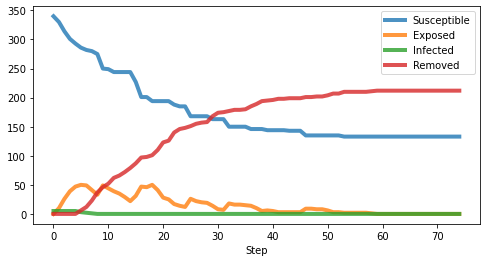

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


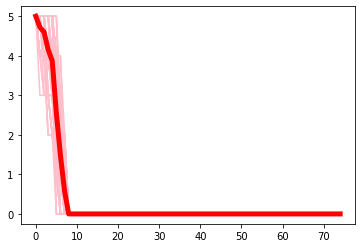

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


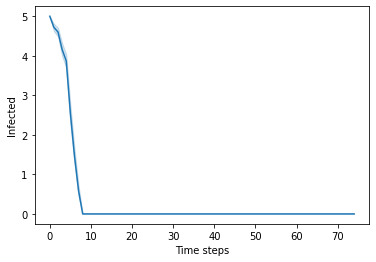

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
287                          24           33  0.205557
214                          18           45  0.568536
126                          17           86  0.293564
143                          17           45  0.073974
14                           17           62  0.612160
201                          10           54  0.042318
238                           9           68  0.115537
224                           8           27  0.565041
178                           8           49  0.266373
15                            6           56  0.282170
18                            6           37  0.526136
152                           6           31  0.357067
303                           5           53  0.215139
242                           5           59  0.289474
147                           5           42  0.279424
124                           5           40  0.024110
228                           5           44  0.200393
26                            5           60  0.145213
170                           4           20  0.067823
317                           4           47  0.238320

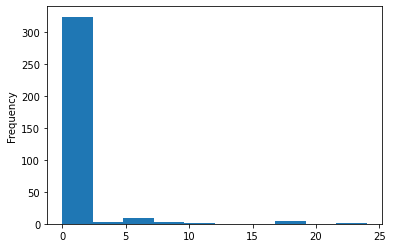

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

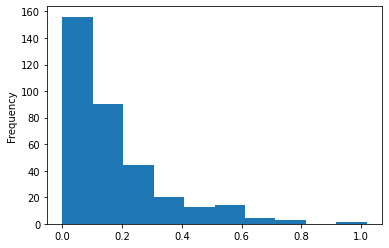

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=345
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 103
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.400734              244          747                  5   
1      13.714170              224          709                  5   
2      11.784152              215          709                  5   
3      12.812236              246          717                  5   
4      11.082540              169          719                  5   
..           ...              ...          ...                ...   
95     13.141858              245          739                  7   
96     12.593924              237          737                  5   
97     12.767214              235          728                  5   
98     11.219667              181          694                  5   
99     11.330046              173          699                  5   

    max_2_trans  num_of_S  
0            32       100  
1            44       120  
2            30       130  
3            20        97  
4            48       176  
..          ...       ...  
95           46        99  
96           48       106  
97           52       107  
98           31       161  
99           23       171  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  11.395227200984955 0.14233589411689365
Average_found_positives:  174.56 5.6217708127161385
Average_total_tests:  710.53 2.8326186264353135
Average_max_outbreak_size:  5.14 0.05688904671695279
Average_max_2_trans: 32.56 1.0865867232166546
Average_number_of_uninfected: 168.25 5.629384935095019


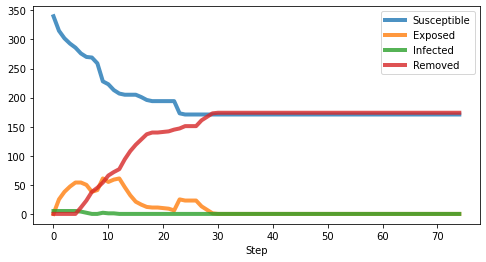

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


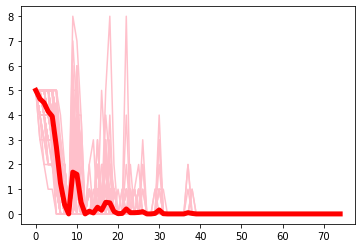

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


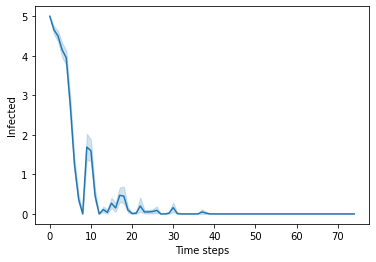

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
111                          23           37  0.175428
94                           22           42  0.129779
286                          21           35  0.573683
326                          16           38  0.694567
16                           15           52  0.271158
253                          11           54  0.053008
102                           9           35  0.271470
67                            9           53  0.120407
280                           8           22  0.141711
182                           7           20  0.046196
259                           5           17  0.489760
134                           5           22  0.434833
225                           4           37  0.343042
140                           3           44  0.330272
254                           2           13  0.336687
124                           2           40  0.144271
71                            2           29  0.097424
83                            2           33  0.190288
139                           1           28  0.047092
197                           1           49  0.210387

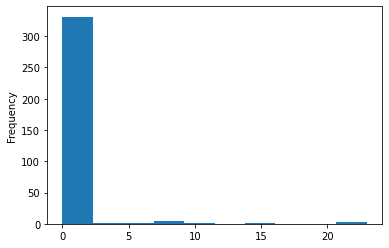

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

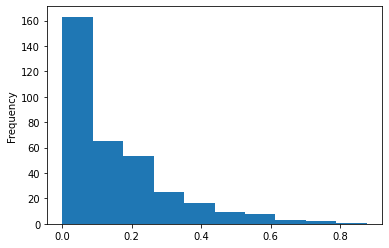

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(278, 28), (284, 28), (226, 28), (204, 28), (113, 29)]

In [ ]:
group_df

Group  Degree  Intra_C  \
19          [76, 66, 69, 101, 77, 82, 97, 79, 80, 99]     359       20   
13  [134, 144, 281, 196, 139, 161, 325, 287, 295, ...     345       18   
22  [195, 111, 194, 189, 157, 172, 129, 116, 123, ...     433       12   
31  [279, 248, 254, 313, 253, 298, 258, 250, 252, ...     343       15   
11       [51, 52, 333, 110, 55, 56, 330, 127, 40, 65]     376       24   
32  [259, 262, 276, 255, 256, 285, 277, 283, 270, ...     387       16   
3        [70, 49, 50, 306, 321, 64, 59, 60, 204, 257]     296       22   
26  [193, 202, 225, 175, 176, 184, 182, 183, 220, ...     382       14   
27  [217, 206, 198, 199, 289, 205, 288, 324, 214, ...     302       14   
17        [29, 37, 136, 16, 135, 54, 32, 45, 122, 31]     356       12   
6     [326, 125, 33, 41, 340, 237, 190, 228, 280, 39]     404       16   
14    [291, 294, 292, 146, 140, 142, 328, 53, 46, 47]     345       13   
25  [173, 150, 151, 177, 155, 168, 251, 163, 178, ...     355       11   
24  [170, 242, 171, 180, 223, 137, 166, 208, 179, ...     291       14   
7       [12, 26, 327, 30, 25, 28, 307, 162, 141, 153]     378       15   
18       [44, 181, 72, 74, 263, 61, 126, 148, 81, 93]     248       15   
30   [234, 265, 243, 244, 240, 278, 314, 103, 67, 71]     361       13   
20        [85, 96, 209, 84, 92, 104, 86, 87, 130, 95]     344       14   
10  [323, 216, 169, 174, 337, 218, 158, 167, 332, 68]     337       17   
15  [331, 128, 164, 334, 143, 88, 100, 341, 316, 319]     266       12   
21  [112, 156, 147, 152, 114, 98, 113, 145, 108, 138]     336       16   
12   [335, 154, 42, 43, 342, 305, 241, 247, 343, 160]     329       16   
28  [232, 207, 213, 222, 211, 212, 245, 221, 238, ...     393       12   
29  [226, 227, 267, 231, 266, 282, 246, 249, 236, ...     390       13   
23  [165, 200, 132, 121, 131, 293, 159, 187, 224, ...     402       12   
1          [10, 7, 9, 260, 261, 24, 13, 15, 301, 315]     415       19   
8          [336, 73, 57, 58, 309, 94, 90, 91, 312, 8]     349       13   
16              [2, 0, 1, 23, 21, 22, 20, 11, 14, 48]     441       21   
0          [17, 3, 4, 272, 275, 27, 18, 19, 303, 304]     317       25   
2       [38, 34, 35, 317, 318, 102, 36, 62, 271, 274]     346       15   
4    [344, 329, 149, 75, 78, 105, 191, 117, 109, 115]     299       12   
33  [269, 302, 290, 300, 310, 273, 284, 311, 286, ...     340       10   
5    [120, 118, 119, 185, 188, 338, 124, 63, 89, 339]     300       14   
9       [5, 6, 320, 107, 83, 106, 322, 219, 186, 192]     327       19   
34                          [235, 210, 230, 239, 296]      84        5   

           order  record  flag  
19  1.398429e+16      19     1  
13  9.811661e+14      19     1  
22  3.908024e+12      19     1  
31  3.522174e+12      19     1  
11  1.827621e+12      19     1  
32  1.562800e+12      19     1  
3   3.702856e+11      19     1  
26  7.537201e+10      19     1  
27  3.319707e+10      19     1  
17  4.320193e+10      18     0  
6   3.330264e+10      18     0  
14  3.161795e+10      18     0  
25  1.346876e+10      18     0  
24  6.124458e+09      18     0  
7   2.397660e+09      18     0  
18  3.354608e+08      18     0  
30  1.954922e+08      18     0  
20  1.416085e+08      18     0  
10  1.385007e+08      18     0  
15  1.343788e+08      18     0  
21  6.328362e+07      18     0  
12  6.283337e+07      18     0  
28  5.317214e+07      18     0  
29  1.889616e+07      18     0  
23  1.500093e+07      18     0  
1   4.256636e+06      18     0  
8   2.020274e+06      18     0  
16  1.580618e+06      18     0  
0   1.170634e+06      18     0  
2   2.547954e+05      18     0  
4   9.574071e+04      18     0  
33  4.200566e+04      18     0  
5   7.130964e+03      18     0  
9   4.868693e+01      18     0  
34  7.198589e-03      18     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
111                          23           37  0.175428
94                           22           42  0.129779
286                          21           35  0.573683
326                          16           38  0.694567
16                           15           52  0.271158
253                          11           54  0.053008
102                           9           35  0.271470
67                            9           53  0.120407
280                           8           22  0.141711
182                           7           20  0.046196
259                           5           17  0.489760
134                           5           22  0.434833
225                           4           37  0.343042
140                           3           44  0.330272
254                           2           13  0.336687
124                           2           40  0.144271
71                            2           29  0.097424
83                            2           33  0.190288
139                           1           28  0.047092
197                           1           49  0.210387

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=345
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 10
capacity = 103
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.050821              215          757                 54   
1      11.576427              202          698                 75   
2      12.903244              241          796                 52   
3      13.690975              218          767                 54   
4      11.996407              219          765                 63   
..           ...              ...          ...                ...   
95     13.083211              256          833                 39   
96     12.608185              233          805                 48   
97     13.496363              215          748                 78   
98     12.705796              228          814                 47   
99     12.078392              214          729                 64   

    max_2_trans  num_of_S  
0            41         3  
1            50         4  
2            29         8  
3            33         6  
4            30         7  
..          ...       ...  
95           28         9  
96           43         6  
97           34         5  
98           38        13  
99           41         7  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  12.424007260799408 0.05826641201457224
Average_found_positives:  220.84 1.462647385304255
Average_total_tests:  775.54 3.74007562177099
Average_max_outbreak_size:  53.9 1.0181682899534175
Average_max_2_trans: 37.01 0.8351489312534245
Average_number_of_uninfected: 10.07 0.4219375701822642


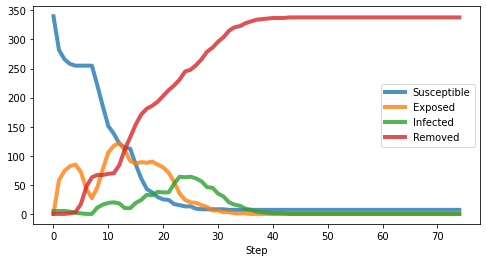

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


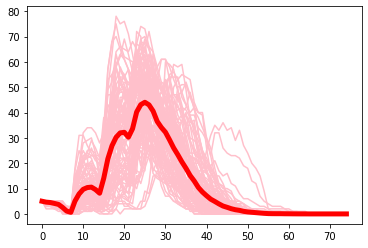

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


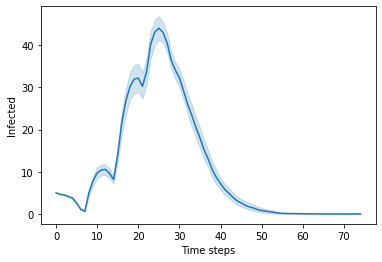

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
114                          41           41  1.028919
58                           20           51  0.288142
271                          15           46  0.123959
309                          15           33  0.331924
291                          14           43  0.080566
155                          14           51  0.084411
4                            11           29  0.593524
56                           11           44  0.361894
105                          10           40  0.218052
285                          10           29  0.305635
311                          10           40  0.076412
187                          10           41  0.051748
299                          10           49  0.204553
23                            9           67  0.078880
116                           8           34  0.305751
27                            7           51  0.293624
37                            7           33  0.763261
63                            7           58  0.385545
120                           6           38  0.077038
193                           6           27  0.272511

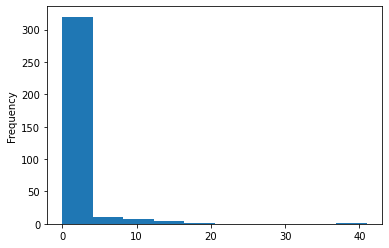

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

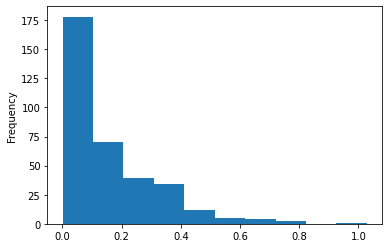

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(71, 31), (50, 31), (61, 31), (258, 31), (60, 35)]

In [ ]:
group_df

Group  Degree  Intra_C  \
28  [232, 207, 213, 222, 211, 212, 245, 221, 238, ...     393       12   
1          [10, 7, 9, 260, 261, 24, 13, 15, 301, 315]     415       19   
19          [76, 66, 69, 101, 77, 82, 97, 79, 80, 99]     359       20   
20        [85, 96, 209, 84, 92, 104, 86, 87, 130, 95]     344       14   
16              [2, 0, 1, 23, 21, 22, 20, 11, 14, 48]     441       21   
7       [12, 26, 327, 30, 25, 28, 307, 162, 141, 153]     378       15   
13  [134, 144, 281, 196, 139, 161, 325, 287, 295, ...     345       18   
17        [29, 37, 136, 16, 135, 54, 32, 45, 122, 31]     356       12   
30   [234, 265, 243, 244, 240, 278, 314, 103, 67, 71]     361       13   
31  [279, 248, 254, 313, 253, 298, 258, 250, 252, ...     343       15   
8          [336, 73, 57, 58, 309, 94, 90, 91, 312, 8]     349       13   
33  [269, 302, 290, 300, 310, 273, 284, 311, 286, ...     340       10   
27  [217, 206, 198, 199, 289, 205, 288, 324, 214, ...     302       14   
6     [326, 125, 33, 41, 340, 237, 190, 228, 280, 39]     404       16   
9       [5, 6, 320, 107, 83, 106, 322, 219, 186, 192]     327       19   
25  [173, 150, 151, 177, 155, 168, 251, 163, 178, ...     355       11   
14    [291, 294, 292, 146, 140, 142, 328, 53, 46, 47]     345       13   
21  [112, 156, 147, 152, 114, 98, 113, 145, 108, 138]     336       16   
4    [344, 329, 149, 75, 78, 105, 191, 117, 109, 115]     299       12   
24  [170, 242, 171, 180, 223, 137, 166, 208, 179, ...     291       14   
11       [51, 52, 333, 110, 55, 56, 330, 127, 40, 65]     376       24   
12   [335, 154, 42, 43, 342, 305, 241, 247, 343, 160]     329       16   
15  [331, 128, 164, 334, 143, 88, 100, 341, 316, 319]     266       12   
0          [17, 3, 4, 272, 275, 27, 18, 19, 303, 304]     317       25   
18       [44, 181, 72, 74, 263, 61, 126, 148, 81, 93]     248       15   
34                          [235, 210, 230, 239, 296]      84        5   
22  [195, 111, 194, 189, 157, 172, 129, 116, 123, ...     433       12   
32  [259, 262, 276, 255, 256, 285, 277, 283, 270, ...     387       16   
29  [226, 227, 267, 231, 266, 282, 246, 249, 236, ...     390       13   
26  [193, 202, 225, 175, 176, 184, 182, 183, 220, ...     382       14   
23  [165, 200, 132, 121, 131, 293, 159, 187, 224, ...     402       12   
5    [120, 118, 119, 185, 188, 338, 124, 63, 89, 339]     300       14   
10  [323, 216, 169, 174, 337, 218, 158, 167, 332, 68]     337       17   
2       [38, 34, 35, 317, 318, 102, 36, 62, 271, 274]     346       15   
3        [70, 49, 50, 306, 321, 64, 59, 60, 204, 257]     296       22   

           order  record  flag  
28  5.925567e+13      35     1  
1   4.385127e+13      36     1  
19  6.341825e+12      33     1  
20  3.077825e+12      32     1  
16  2.629845e+12      36     1  
7   6.608820e+11       7     1  
13  6.200067e+11      22     1  
17  5.972235e+11      15     1  
30  5.938704e+11      28     1  
31  1.179569e+12      19     0  
8   1.178579e+12       7     0  
33  1.165051e+12      18     0  
27  1.140075e+12      21     0  
6   1.067419e+12       8     0  
9   1.065008e+12      26     0  
25  1.027693e+12      32     0  
14  1.010130e+12      18     0  
21  9.903267e+11      33     0  
4   5.568237e+11       0     0  
24  2.286390e+10       4     0  
11  2.072861e+10       1     0  
12  7.782478e+09       0     0  
15  4.161006e+09       2     0  
0   1.340351e+09       1     0  
18  8.090435e+08       2     0  
34  4.600512e+00       0     0  
22  1.474651e+16      35     0  
32  3.809632e+15      33     0  
29  5.606370e+14      35     0  
26  3.434500e+13      32     0  
23  3.239908e+12      35     0  
5   9.891008e+11       2     0  
10  8.483515e+11       2     0  
2   8.244442e+11       9     0  
3   6.634001e+11      20     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
114                          41           41  1.028919
58                           20           51  0.288142
271                          15           46  0.123959
309                          15           33  0.331924
291                          14           43  0.080566
155                          14           51  0.084411
4                            11           29  0.593524
56                           11           44  0.361894
105                          10           40  0.218052
285                          10           29  0.305635
311                          10           40  0.076412
187                          10           41  0.051748
299                          10           49  0.204553
23                            9           67  0.078880
116                           8           34  0.305751
27                            7           51  0.293624
37                            7           33  0.763261
63                            7           58  0.385545
120                           6           38  0.077038
193                           6           27  0.272511

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

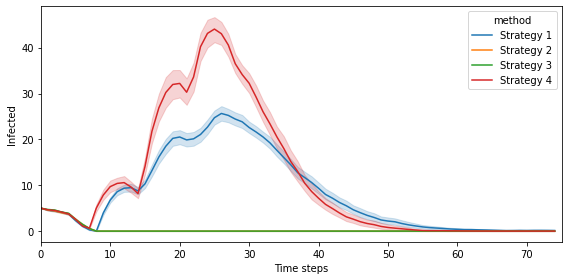

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
#plt.ylim(top = 12)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/Thiers13_infect_result_500.csv')

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_4['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_4])
temp = temp.reset_index()

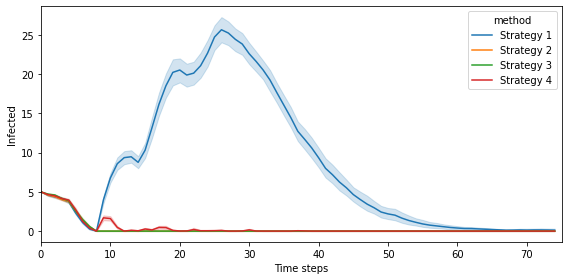

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
#plt.ylim(top = 12)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/Thiers13_infect_result_2.csv')

# Malawi

In [ ]:
#load data
file = '/content/drive/MyDrive/Colab Notebooks/Real_data/tnet_malawi_pilot2.csv'

edge_list = pd.read_csv(file).iloc[: , 3:]
G_temp = nx.from_pandas_edgelist(edge_list, "id1", "id2")
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())


# of nodes:  86
Average degree:  8.069767441860465


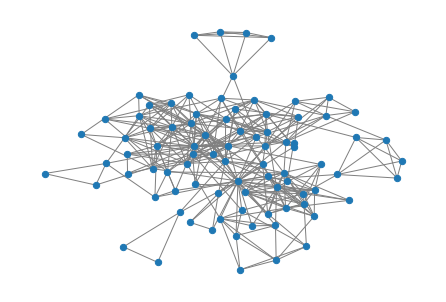

In [ ]:
nx.draw(G, pos = nx.kamada_kawai_layout(G), node_size = 40, edge_color = 'grey')

##Testing Strategy _0

In [ ]:
pop=86
steps=100
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = G)
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


0.3212399482727051
      Susceptible  Exposed  Infected  Removed
Step                                         
0              81        0         5        0
1              79        2         5        0
2              77        4         4        1
3              77        4         3        2
4              76        5         3        2
5              73        8         2        3
6              73        8         1        4
7              73        8         1        4
8              71        8         2        5
9              60       17         4        5
10             52       25         4        5
11             47       29         5        5
12             40       33         8        5
13             38       35         8        5
14             38       35         6        7
15             33       38         8        7
16             30       30        17        9
17             26       26        24       10
18             24       23        27       12
19             

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  31
number_of_uninfected: 7


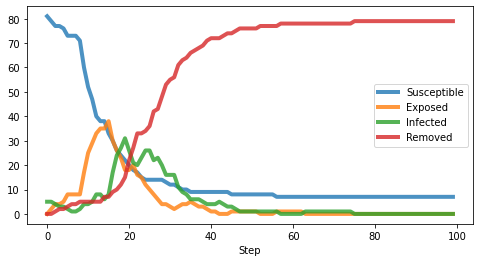

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
58                           22           31  0.348123
2                             8           26  0.076410
18                            4           12  0.150907
22                            3           14  0.493854
56                            3            6  0.193004
9                             3            9  0.122645
10                            3           11  0.059992
74                            2            8  0.152719
75                            2           12  0.025978
77                            2            5  0.079964
80                            2           17  0.135914
81                            2            9  0.244239
30                            2            4  0.295759
70                            2           11  0.342656
27                            1            9  0.284781
65                            1           18  0.027842
64                            1            5  0.263646
63                            1            5  0.082510
68                            1            5  0.410321
48                            1           16  0.158840

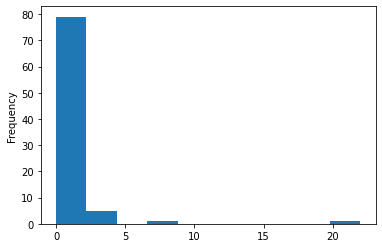

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

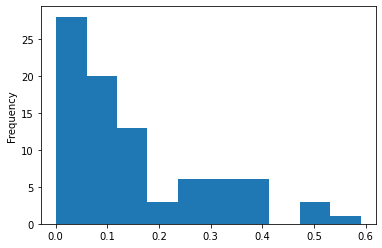

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=86
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
capacity = 25
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       1.725007               19         1453                  5   
1       1.461663               16         1453                  5   
2       1.460499                4         1453                  5   
3       1.481501               41         1453                  5   
4       1.481344               23         1453                  5   
..           ...              ...          ...                ...   
95      1.383909               40         1453                  5   
96      1.401585               16         1453                  5   
97      1.374566               24         1453                  5   
98      1.389646               18         1453                  5   
99      1.366141               13         1453                  5   

    max_2_trans  num_of_S  
0             8        63  
1             4        63  
2             2        77  
3            13        28  
4             8        53  
..          ...       ...  
95           12        30  
96            5        61  
97            6        56  
98            6        66  
99            4        72  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  1.4609756302833556 0.011456603429413634
Average_found_positives:  24.49 1.0184653735752225
Average_total_tests:  1453.0 0.0
Average_max_outbreak_size:  5.15 0.04793724854411023
Average_max_2_trans: 8.75 0.4056108997798284
Average_number_of_uninfected: 53.9 1.4247806848775006


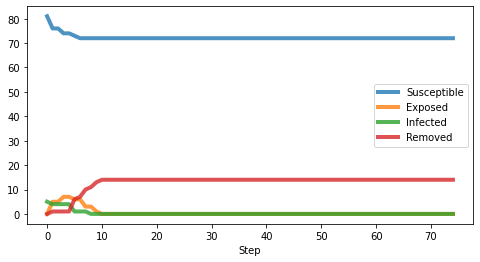

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


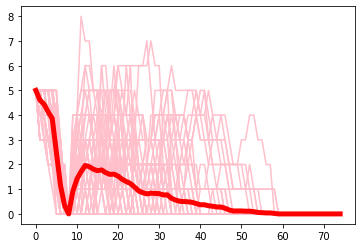

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

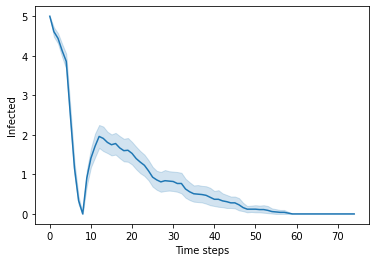

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
39                            4           15  0.134186
44                            3            8  0.179605
24                            2            5  0.119223
48                            0           16  0.275630
57                            0           13  0.876073
64                            0            5  0.016692
63                            0            5  0.076297
62                            0            3  0.146936
61                            0            4  0.282461
60                            0           15  0.020042
59                            0            8  0.008531
58                            0           31  0.219242
56                            0            6  0.094417
49                            0            5  0.261955
45                            0            6  0.063849
54                            0           12  0.234286
53                            0            3  0.000476
52                            0            6  0.414411
51                            0            4  0.502597
47                            0           14  0.007817

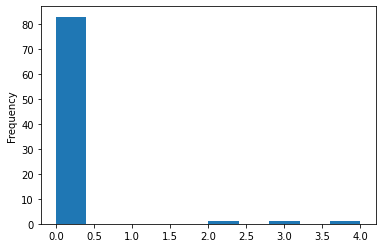

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

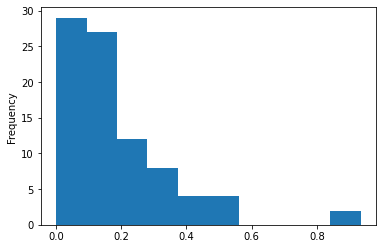

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=86
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 25
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       1.451045               28          312                  5   
1       1.423580               40          321                  5   
2       1.428741               29          309                  5   
3       1.437081               38          326                  5   
4       1.447520               33          320                  5   
..           ...              ...          ...                ...   
95      1.279887               39          307                  5   
96      1.297595                8          304                  5   
97      1.305853               24          299                  5   
98      1.394954               23          308                  5   
99      1.432168               35          332                  5   

    max_2_trans  num_of_S  
0             9        57  
1            10        43  
2             4        56  
3            14        48  
4             9        51  
..          ...       ...  
95           10        45  
96            2        78  
97            9        59  
98            7        59  
99            8        50  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  1.4165668988227844 0.01232086727518649
Average_found_positives:  26.16 1.0842043118799103
Average_total_tests:  306.67 0.9154184338819646
Average_max_outbreak_size:  5.0 0.0
Average_max_2_trans: 8.44 0.3955101551519035
Average_number_of_uninfected: 57.7 1.0697398909751075


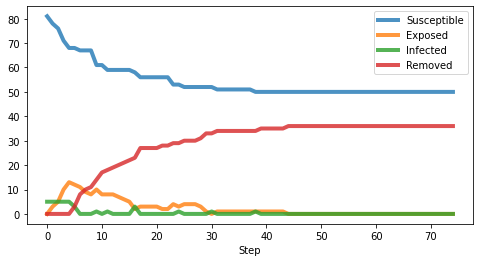

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


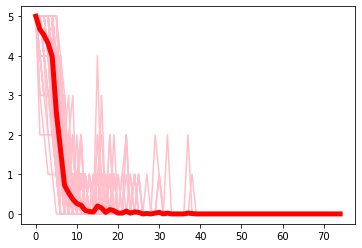

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


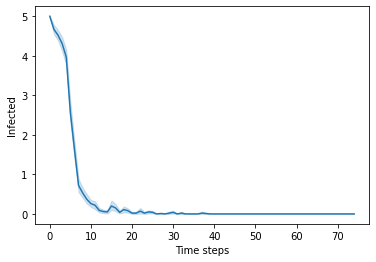

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
78                            8            8  0.398904
2                             6           26  0.263036
21                            4            8  0.132307
5                             3           11  0.345416
60                            2           15  0.178357
70                            2           11  0.093468
85                            1            1  0.607611
82                            1            8  0.185437
67                            1            3  0.020583
33                            1           16  0.162317
11                            1            7  0.114610
22                            1           14  0.055223
1                             0           12  0.638411
58                            0           31  0.040619
61                            0            4  0.644976
59                            0            8  0.048741
54                            0           12  0.150717
57                            0           13  0.098029
56                            0            6  0.152983
55                            0           12  0.267467

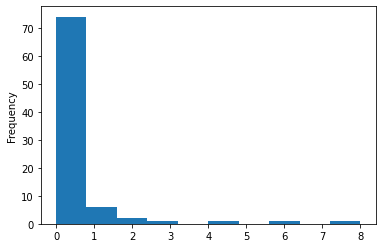

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

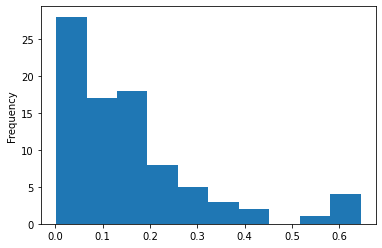

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=86
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 25
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       1.464058               34          311                  5   
1       1.733745               28          309                  5   
2       1.469998               13          299                  5   
3       1.438947               34          316                  5   
4       1.404023               21          299                  5   
..           ...              ...          ...                ...   
95      1.304168               27          294                  5   
96      1.309811               13          301                  5   
97      1.312251               27          302                  5   
98      1.357693               30          303                  5   
99      1.305184               24          305                  5   

    max_2_trans  num_of_S  
0             7        51  
1             8        57  
2             3        69  
3            21        50  
4             5        62  
..          ...       ...  
95           12        56  
96            7        71  
97            9        57  
98            8        55  
99            7        60  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  1.389774703979492 0.01228911232974995
Average_found_positives:  26.3 1.0778298435825442
Average_total_tests:  305.89 0.9038520259691211
Average_max_outbreak_size:  5.0 0.0
Average_max_2_trans: 8.59 0.45838870188978487
Average_number_of_uninfected: 57.58 1.0400252522186784


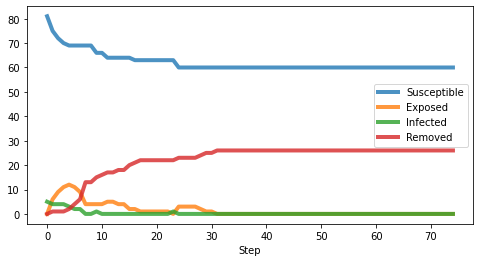

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


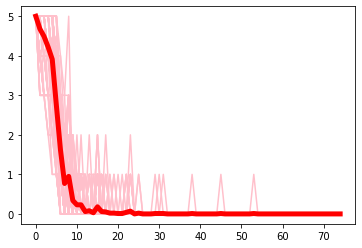

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


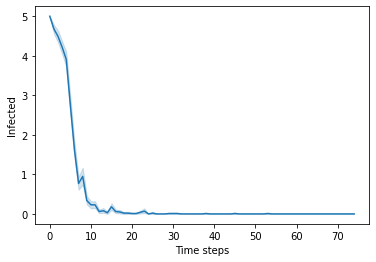

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
11                            7            7  0.434156
14                            3           10  0.424792
83                            3            8  0.532452
16                            3            6  0.240740
2                             2           26  0.092323
58                            1           31  0.072770
15                            1            8  0.049822
26                            1            4  0.030347
53                            0            3  0.185343
54                            0           12  0.144305
65                            0           18  0.270203
64                            0            5  0.174246
63                            0            5  0.275318
62                            0            3  0.039800
61                            0            4  0.362886
60                            0           15  0.109412
59                            0            8  0.097617
49                            0            5  0.151770
57                            0           13  0.265266
50                            0            3  0.004811

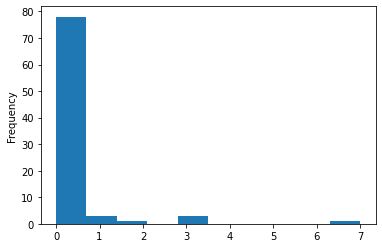

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

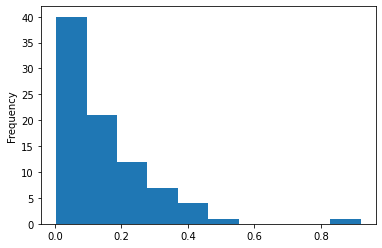

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=86
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 25
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       2.344505               15          299                  5   
1       1.821617               22          299                  5   
2       1.869454               22          299                  5   
3       1.782050               23          314                  5   
4       1.814393               14          293                  5   
..           ...              ...          ...                ...   
95      1.753061               31          312                  5   
96      1.825955               36          322                  5   
97      1.638515                5          298                  5   
98      1.655275                7          299                  5   
99      1.704222               19          304                  5   

    max_2_trans  num_of_S  
0            10        69  
1             5        62  
2             7        60  
3             7        60  
4             4        68  
..          ...       ...  
95            7        54  
96            9        48  
97            3        78  
98            2        76  
99            9        66  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  1.7804526686668396 0.013621492124876974
Average_found_positives:  21.88 0.8762039336440651
Average_total_tests:  303.91 0.8860415887359334
Average_max_outbreak_size:  5.01 0.009999999999999998
Average_max_2_trans: 7.21 0.3397250819605925
Average_number_of_uninfected: 61.99 0.8447694084987653


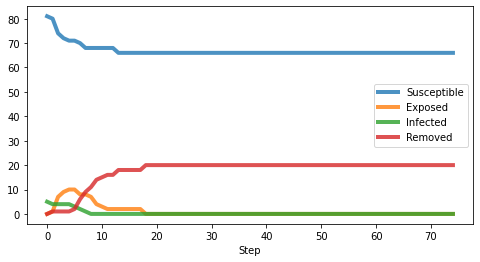

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


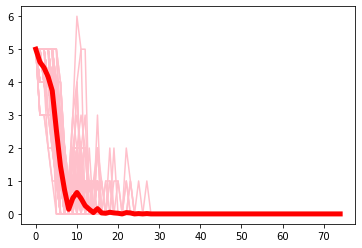

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


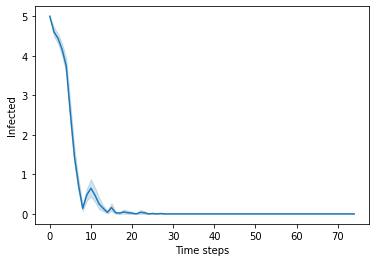

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
58                            9           31  0.061507
42                            3            6  0.079488
82                            2            8  0.152685
66                            1            2  0.156263
55                            0           12  0.127982
63                            0            5  0.289269
62                            0            3  0.448950
61                            0            4  0.023336
60                            0           15  0.066548
59                            0            8  0.348663
57                            0           13  0.001560
56                            0            6  0.189394
54                            0           12  0.248474
65                            0           18  0.105593
53                            0            3  0.375938
52                            0            6  0.149435
51                            0            4  0.353632
50                            0            3  0.082696
49                            0            5  0.202091
48                            0           16  0.273400

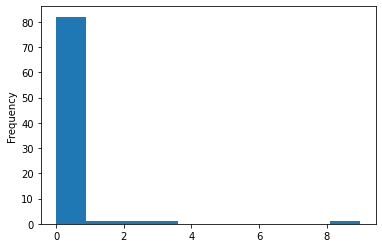

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

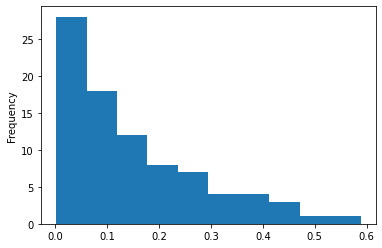

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(48, 10), (30, 12), (82, 12), (70, 17), (73, 17)]

In [ ]:
group_df

Group  Degree  Intra_C     order  record  flag
10    [17, 80, 10, 6, 7]      46        7  0.000024      16     1
6   [62, 52, 53, 71, 79]      43        5  0.000019      16     1
13  [19, 31, 22, 23, 39]      25        3  0.000018      16     1
11  [82, 75, 56, 74, 83]      44        4  0.000017      16     1
2   [55, 11, 12, 63, 67]      24       10  0.000034      15     0
14  [28, 29, 73, 36, 37]      28        4  0.000031      15     0
3   [30, 24, 25, 33, 45]      22       10  0.000028      15     0
17                  [85]       1        0  0.000003      15     0
7     [50, 57, 0, 1, 60]      77        4  0.000548      16     0
4   [40, 26, 27, 41, 51]      31        9  0.000511      16     0
8   [64, 14, 15, 77, 13]      50        9  0.000380      16     0
12  [54, 46, 47, 35, 18]      54        4  0.000065      16     0
0     [70, 2, 3, 58, 59]      43        6  0.000065      16     0
1     [21, 4, 5, 32, 34]      57       10  0.000057      16     0
9     [8, 9, 78, 20, 16]      47        4  0.000052      16     0
5   [68, 38, 42, 43, 44]      58        6  0.000048      16     0
15  [61, 48, 49, 76, 65]      18        4  0.000036      16     0
16  [66, 81, 69, 72, 84]      26        3  0.000027      16     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
58                            9           31  0.061507
42                            3            6  0.079488
82                            2            8  0.152685
66                            1            2  0.156263
55                            0           12  0.127982
63                            0            5  0.289269
62                            0            3  0.448950
61                            0            4  0.023336
60                            0           15  0.066548
59                            0            8  0.348663
57                            0           13  0.001560
56                            0            6  0.189394
54                            0           12  0.248474
65                            0           18  0.105593
53                            0            3  0.375938
52                            0            6  0.149435
51                            0            4  0.353632
50                            0            3  0.082696
49                            0            5  0.202091
48                            0           16  0.273400

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=86
steps=75
st=time.time()
model = NetworkInfectionModel(pop, data_G = G)

#for testing
group_size = 5
capacity = 25
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = G)

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0       1.762495               21          299                  5   
1       1.790720               26          308                  5   
2       1.716629               20          304                  5   
3       1.630912                4          284                  5   
4       1.606833               10          304                  5   
..           ...              ...          ...                ...   
95      1.661235               11          294                  5   
96      1.728972               19          298                  5   
97      1.672207               12          299                  5   
98      2.145116               40          314                  5   
99      1.617379                9          298                  5   

    max_2_trans  num_of_S  
0             8        58  
1            11        51  
2             9        64  
3             3        77  
4             3        74  
..          ...       ...  
95            6        71  
96           15        62  
97            3        71  
98           13        40  
99            3        75  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  1.7899131751060486 0.014419953222864134
Average_found_positives:  21.95 1.0793165626563146
Average_total_tests:  306.89 1.0044240522646184
Average_max_outbreak_size:  5.25 0.08804842561071295
Average_max_2_trans: 7.71 0.43999426075228465
Average_number_of_uninfected: 59.92 1.2606459783889696


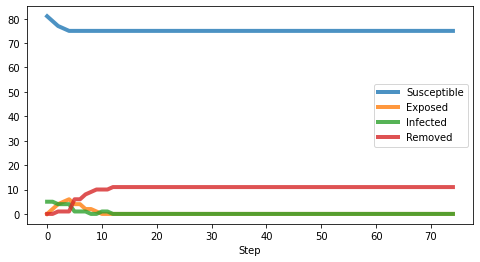

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


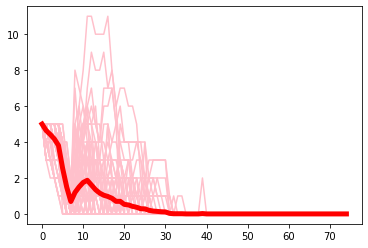

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


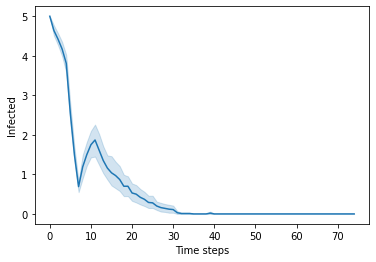

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
31                            3            4  0.304856
23                            2            5  0.161139
68                            1            5  0.080351
65                            0           18  0.212564
63                            0            5  0.056314
62                            0            3  0.144127
61                            0            4  0.132958
60                            0           15  0.004199
59                            0            8  0.147857
58                            0           31  0.135305
57                            0           13  0.051090
56                            0            6  0.066313
55                            0           12  0.046097
54                            0           12  0.162742
53                            0            3  0.265427
52                            0            6  0.009869
51                            0            4  0.077541
50                            0            3  0.179690
49                            0            5  0.183815
48                            0           16  0.088341

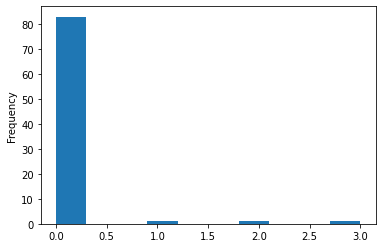

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

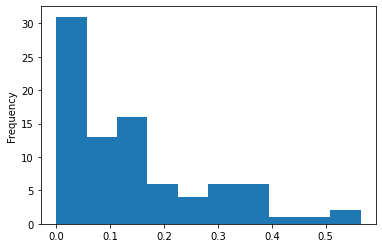

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(46, 4), (17, 6), (58, 6), (77, 8), (25, 11)]

In [ ]:
group_df

Group  Degree  Intra_C     order  record  flag
11  [82, 75, 56, 74, 83]      44        4  0.000014      16     1
3   [30, 24, 25, 33, 45]      22       10  0.000014      16     1
14  [28, 29, 73, 36, 37]      28        4  0.000013      16     1
9     [8, 9, 78, 20, 16]      47        4  0.000013      17     1
8   [64, 14, 15, 77, 13]      50        9  0.000025      16     0
17                  [85]       1        0  0.000024      12     0
4   [40, 26, 27, 41, 51]      31        9  0.000023      16     0
16  [66, 81, 69, 72, 84]      26        3  0.000021      15     0
13  [19, 31, 22, 23, 39]      25        3  0.000021      15     0
7     [50, 57, 0, 1, 60]      77        4  0.000021      16     0
0     [70, 2, 3, 58, 59]      43        6  0.000018      16     0
2   [55, 11, 12, 63, 67]      24       10  0.000017      16     0
5   [68, 38, 42, 43, 44]      58        6  0.000016      16     0
6   [62, 52, 53, 71, 79]      43        5  0.000016      16     0
1     [21, 4, 5, 32, 34]      57       10  0.000016      16     0
12  [54, 46, 47, 35, 18]      54        4  0.000015      16     0
10    [17, 80, 10, 6, 7]      46        7  0.000015      17     0
15  [61, 48, 49, 76, 65]      18        4  0.000014      16     0

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
31                            3            4  0.304856
23                            2            5  0.161139
68                            1            5  0.080351
65                            0           18  0.212564
63                            0            5  0.056314
62                            0            3  0.144127
61                            0            4  0.132958
60                            0           15  0.004199
59                            0            8  0.147857
58                            0           31  0.135305
57                            0           13  0.051090
56                            0            6  0.066313
55                            0           12  0.046097
54                            0           12  0.162742
53                            0            3  0.265427
52                            0            6  0.009869
51                            0            4  0.077541
50                            0            3  0.179690
49                            0            5  0.183815
48                            0           16  0.088341

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

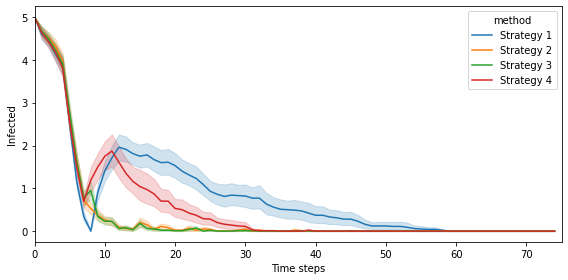

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
#plt.ylim(top = 12)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/Malawi_infect_result_500.csv')

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_4['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_4])
temp = temp.reset_index()

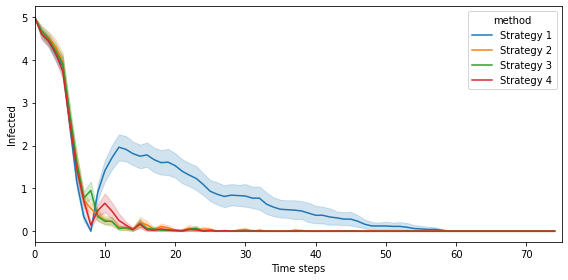

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 75)
#plt.ylim(top = 12)
plt.tight_layout()

In [ ]:
temp.to_csv('/content/drive/MyDrive/Colab Notebooks/1020_Updated_strategies/Malawi_infect_result_2.csv')